In [1]:
import operator, re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from neurotools.io.files import load_embedding_model
from neurotools.io.gdrive import download_sheets_doc
from neurotools.plot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from neurotools.language.simple_tokenizer import SimpleTokenizer
from wordcloud import WordCloud
from googletrans import Translator
import itertools
import ast
%matplotlib inline

In [2]:
sns.set_style("white")

In [3]:
import matplotlib as mpl
mpl.rc('font',family='Open Sans')

In [4]:
translator = Translator()

In [5]:
tokenizer = SimpleTokenizer('de') 

Extra characters read for de
Stopwords set read for de
Lemma lookup read for de


In [45]:
emb, word2rank_dict = load_embedding_model('../utils/002_de_de_commoncrawl_v1_20171209.bin')

In [6]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    return np.mean(words_in_emb, axis=0)

In [7]:
def get_idf_map(documents):
    tfidf = TfidfVectorizer(use_idf=True)
    tfidf.fit_transform(documents)
    word_to_idf = dict((x[0], tfidf.idf_[x[1]]) for x in sorted(tfidf.vocabulary_.items(), key=operator.itemgetter(1)))
    return word_to_idf

In [8]:
def get_idf_weighted_average_vector(words, word_to_idf, emb):
    """
        Average the idf-weighted word vectors of a list of words. (Map this function to every document)
    """
    # only consider words IN embedding model and in TFIDF vectorizer
    words = [word for word in words if word in word_to_idf.keys() and word in emb.vocab.keys()]
    weighted = [word_to_idf[word] * emb[word] for word in words]
    return np.mean(weighted, axis=0)

In [9]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [10]:
def get_similarity_with_dimensions(row, dimensions):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        dimensions : dataframe containing Neuroflash dimensions
    """
    for k in range(dimensions['dimension'].shape[0]):
        name = str(dimensions['label'].iloc[k])
        # define a new column for the cosine similarity of dimension k and the post text
        row[name] = cosine_similarity(row['wv'], dimensions['dimension'].iloc[k])
    return row

In [47]:
dimensions = pd.read_csv('../data/all_dimensions.csv')

In [48]:
dimensions.dimension = dimensions.dimension.map(lambda x: np.array(ast.literal_eval(x)))

In [49]:
dimensions['en'].iloc[84] = 'migration social justice'

In [50]:
dimensions['en'].iloc[85] = 'social justice vegan'

In [51]:
to_fill = dimensions[dimensions['en'].isnull()]['de'].map(lambda x: translator.translate(x, src='de').text).values

In [52]:
dimensions.loc[dimensions['en'].isnull(), 'en'] = to_fill

# Facebook Analysis

In [17]:
# because some display as 1.4K
def convert_K_to_num(x):
    if 'K' in str(x):
        num = float(str(x[:-1])) * 1000
    elif pd.isnull(x):
        num = 0
    else:
        num = float(x)
    return num

In [67]:
fb_paths=['../data/FB_AminataBelli.csv',
       '../data/FB_BenandJerrys.csv',
       '../data/FB_enormmagazin.csv',
       '../data/FB_GreenpeaceCH.csv',
       '../data/FB_GreenpeaceDE.csv',
       '../data/FB_jungundnaiv.csv',
       '../data/FB_MissesVlog.csv',
       '../data/FB_Victoria.van.Violence.csv']

In [68]:
def preprocess_facebook_data(path):
    fb_df = pd.read_csv(path) 
    fb_df['likes'] = fb_df['total_likes'].map(convert_K_to_num)
    fb_df['comments'] = fb_df['total_comments'].map(convert_K_to_num)
    fb_df['shares'] = fb_df['total_shares'].map(convert_K_to_num)
    fb_df['success'] = fb_df['likes'] + 2*fb_df['comments'] + 2*fb_df['shares']
    fb_df['tokens'] = fb_df['message'].astype(str).map(tokenizer.tokenize)
    fb_df = fb_df[~fb_df['message'].isnull()]
    fb_df = fb_df.reset_index()
    fb_df = fb_df[['message', 'tokens', 'success', 'likes', 'comments', 'shares', 'created_time']]
    fb_word_to_idf = get_idf_map(fb_df['tokens'].map(lambda x: ' '.join(x)).values)
    fb_df['wv'] = fb_df['tokens'].map(lambda x: get_idf_weighted_average_vector(x, fb_word_to_idf, emb))
    fb_df = fb_df[~fb_df['wv'].isnull()]
    fb_df = fb_df.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)
    fb_df['wv'] = fb_df['wv'].map(lambda x: str(list(x)))
    fb_df.to_csv('../processed/processed_' + path[8:], index=False)
    return fb_df

In [71]:
# for path in fb_paths:
#     print("Doing {}".format(path[8:]))
#     fb = preprocess_facebook_data(path)

Doing FB_AminataBelli.csv


/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Doing FB_BenandJerrys.csv
Doing FB_enormmagazin.csv
Doing FB_GreenpeaceCH.csv
Doing FB_GreenpeaceDE.csv
Doing FB_jungundnaiv.csv
Doing FB_MissesVlog.csv
Doing FB_Victoria.van.Violence.csv


### sidetrack: determine best threshold

In [57]:
fb = pd.read_csv('../processed/processed_FB_BenandJerrys.csv')
fb['wv'] = fb['wv'].map(ast.literal_eval)
fb['tokens'] = fb['tokens'].map(ast.literal_eval)

In [90]:
translator = Translator()

In [93]:
migration = fb[fb['social justice + migration'] >=0.2][['message', 'social justice + migration']].sort_values('social justice + migration')

In [97]:
trans = []
for index, x in enumerate(migration['message'].values):
    print("{}: {} out of {}".format(x, index, len(migration['message'].values)))
    try:
        trans.append(translator.translate(x, src = 'de').text)
    except:
        trans.append('FAILED TRANSLATION')       

Diesen Flyer haben wir unseren Händlern mitgegeben, in der Hoffnung unser Eis zu verkaufen...: 0 out of 242
ALLES KANN, NICHTS NUSS! JUCHHUUUUU!! Es gibt eine neue großartige Sorte von Ben & Jerry’s: "All Or Nut-ting". Und weil wir die mit euch ganz exklusiv Probelöffeln wollen, laden wir euch ein. (Leider nur) in Hamburg gehen wir euch am 11. Feburar mit dem neuen Core solange auf die Nüsse, bis der Überraschungsgast Charity Children Berlin die Bühne entert. Teilen lohnt sich! Erlebt mit uns die fairste Form der Kernspaltung!! Schickt diese Einladung gerne an eure Freunde weiter u...nd ladet sie zu dem neuen Ben & Jerry’s ein. Allerdings gibt es nur 250 Plätze. Wer zuerst kommt, löffelt zuerst!  Das Event startet pünktlich um 18:30 und endet um 20 Uhr. Einlass ist um 18:00 Uhr und nur für maximal 250 Personen. Wer also zum Island, Bankstr. 2A in 20097 Hamburg kommt, kriegt von uns exklusiv kostenlos (!) was auf den Löffel.  Kein Witz. Einfach Löffel mitbringen und dann verschenken wir

Ben&Jerry´s Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 28. Juni von 14-20 Uhr in Hannover! Wir stehen am Platz der Weltausstellung in Hannover. Wo der Bus auf den Meter genau steht, alle aktuellen News aus dem Bus und leckere Fotos seht ihr dann immer live auf www.benjerry.de: 37 out of 242
Bist Du der nächste Ben&Jerry´s ? Oder Du ? Wenn Ihr auch eine Idee für ein Sozialunternehmen habt, dann habt Ihr jetzt noch genau 7 Tage, um Euch zu bewerben! Also los! Teilnahmeschluß ist der 03.05. - Bewerben auf www.joinourcore.com/de: 38 out of 242
Welttierschutztag! Unsere Demo heute für bessere Haltungsbedingungen von Europas Milchkühen:: 39 out of 242
Ben&Jerry´s Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 15. Juni von 14-20 Uhr in Aachen! Wir stehen ab 14 Uhr am Templergraben/ Ecke Wüllnerstrasse in Aachen. Wo der Bus auf den Meter genau steht, alle aktuellen News aus dem Bus und leckere Fotos seht ihr dann immer live auf 

Ihr habt entschieden: Am 12.04. verschenken wir das neue Wich‘ in Hamburg, Berlin und München!: 80 out of 242
Hallo zusammen, bevor wir jetzt den Abend bei einem Eis ausklingen lassen... Wir sind Euch ja noch was schuldig. Hier also Euer Gewinner in Weltpremiere. Vielen Dank für Eure Hilfe!!!: 81 out of 242
Ben&Jerry´s Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 29. Juni von 13-19 Uhr in Bremen! Wir stehen vor der Uni Bremen am Glasbau. Wo der Bus auf den Meter genau steht, alle aktuellen News aus dem Bus und leckere Fotos seht ihr dann immer live auf www.benjerry.de: 82 out of 242
364 Tage im Leben gibt es nichts umsonst. Das Leben ist nicht immer fair - Ben & Jerry's schon. Denn heute sind wir in STUTTGART und verteilen Ben & Jerry's Ice Cream FOR FREE. Wo wir genau halten, erfahrt Ihr hier bei uns. Teil 3 unseres Videotagebuchs gibt's zur Einstimmung hier: http://youtu.be/f1Wncb6UPpo: 83 out of 242
Und die Gewinner sind... Kiel & Koblenz!!! Ihr beko

Berlin! Wir verschenken eine Busladung faires Eis am 25.7. an der Straße der Pariser Kommune 8. Alles zum Event steht hier: bit.ly/tasteandtunesinBerlin: 116 out of 242
Ben&Jerry´s Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 24. Juni von 14-20 Uhr in Dresden! Wir stehen vor der TU in der Bergstraße 51, vor der neuen Mensa in Dresden. Wo der Bus auf den Meter genau steht, alle aktuellen News aus dem Bus und leckere Fotos seht ihr dann immer live auf www.benjerry.de: 117 out of 242
Ben&Jerry´s Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 26. Juni von 14-20 Uhr in Berlin! Wir stehen vor der Technischen Universität, Straße des 17. Juni 135. Wo der Bus auf den Meter genau steht, alle aktuellen News aus dem Bus und leckere Fotos seht ihr dann immer live auf www.benjerry.de: 118 out of 242
Wir lieben unsere Milch, wir lieben unsere Kühe & ihr liebt unser Eis! Aber wie steht ihr eigentlich zum Thema artgerechte Tierhaltung? Eur

Auch direkt bei Ben&Jerry´s haben europaweit Nachwuchs-Sozialunternehmer die Chance auf 10.000€ und ein sechsmonatiges Business-Coaching von Ashoka, ein Trip in die Ben & Jerry’s Heimat Vermont als besonderen Clou werden die Firmenlogos der Jung-Unternehmer auf der neuen Ben & Jerry’s Sorte in 2014 abgebildet – ein echtes Privileg und ein einzigartiger Werbeeffekt!: 146 out of 242
Wir verschenken wieder Eis - beim FREE CONE DAY 2015! Diesmal in der Stadt, mit den meisten Zugriffen auf unsere Klimaschutz-Petition! Klick mit!: 147 out of 242
Vielfalt schmeckt besser als Einfalt. Wer das genauso sieht, darf sich auf eine neue Sorte Ben & Jerry’s freuen. Was da drin ist, erfahrt ihr hier...: 148 out of 242
Wir sind endlich wieder on the Road und freuen uns auf euch! Am 11. Juli 2017 kommen wir mit unserem YEStival nach Berlin. Einlass ist ab 18.00 Uhr und los geht’s ab 19.00 Uhr! Und natürlich haben wir wieder jede Menge Free Ice Cream und Filme fürs Open Air Kinoprogramm dabei.  In diesem

Es taut, wenn sich keiner traut! COP21, geht aufeinander zu und findet eine Einigung zum Klimaschutz. Es geht um unsere Zukunft!: 179 out of 242
WIR SIND SOOO STOLZ … ...auf unseren Gewinner des “Bist du der nächste Ben & Jerry's?“ Wettbewerbs. Yannick Sonnenberg konnte die europäische Jury in London mit seiner sozialen Geschäftsidee https://elefunds.de/ überzeugen. Ben & Jerry's Gründer Jerry Greenfield gratulierte persönlich! Mehr Infos gibts hier: www.joinourcore.com/de: 180 out of 242
Gemeinsam löffeln – in guten wie in schlechten Zeiten!: 181 out of 242
Globale Eiserwärmung stoppen! Jetzt! benjerry.de/klima: 182 out of 242
Wusstet ihr, dass gleichgeschlechtliche Paare in Deutschland immer noch nicht heiraten dürfen?!: 183 out of 242
Wir glauben an Eisliebe in jeder Beziehung.: 184 out of 242
Hilfe! Das Ben & Jerry’s Team braucht deine Unterstützung! Gesucht wird ein ausgewiesener Ben & Jerry’s Fan (Empfehlungsschreiben zwingend notwendig) der darüber hinaus BWL mit Schwerpunkt Mar

Ben & Jerry starten eine Initiative, die dazu aufruft 1% der nationalen Verteidigungsausgaben für Friedensprojekte auszugeben.: 207 out of 242
Wir verschenken faires Eis und zeigen "Monsieur Claude und seine Töchter". Open air & for free! Alle Infos auf www.benjerry.de/movienights Ben & Jerry’s gibt's ab 19 Uhr, das Filmprogramm startet nach Sonnenuntergang, ca. (!) 22 Uhr. Wir unterstützen während unserer Ben & Jerry’s Movie Nights Tour die Amadeu Antonio Stiftung, die soziale Projekte in ganz Deutschland betreut. In Rostock kannst auch du Teil von One Sweet World werden und bei einem Projekt in deiner Nachbarschaf...t helfen, dass deine Stadt noch schöner wird. Jetzt für das soziale Projekt anmelden auf www.benjerry.de/movienights#osw Location: Alte Zuckerfabrik Neubrandenburger Str. 6 18055 Rostock Anfahrt: Am besten zu Fuß oder mit dem Rad oder Öffentliche Verkehrsmittel: Bus Linie 23 vom Hbf. zum Weißen Kreuz oder S-Bahn vom Hbf. nach Rostock-Kassebohm Wichtige Infos zum Ablauf: B

So machst Du Deutschland vom Sofa aus gerechter: In wenigen Schritten für eine faire Gesellschaft.: 224 out of 242
Wir sagen 50.000 mal Danke für eure Unterstützung & erheben unsere Löffel für euer Engagement!: 225 out of 242
Wir verschenken Eis in deiner Stadt! Am liebsten an Klimaschützer...  Also unterzeichne jetzt diese Klima-Petition: www.benjerry.de/unsere-mission/werde-klimaschutzer! Denn die Stadt mit den meisten Zugriffen auf unsere Seite bekommt Eis geschenkt!: 226 out of 242
Wir haben schon 13.350 Unterschriften in Europa gesammelt!Danke! Unterstützt uns weiter für mehr glückliche Kühe in Europa! www.benjerry.de: 227 out of 242
Löffelt was ihr wollt. Heiratet wen ihr wollt.  benjerry.de/aktuelle-initiativen/ehe-fuer-alle/messenger: 228 out of 242
Glückliche Kühe auf dem Weg zur Großdemo “Wir haben es satt” in Berlin gesichtet! Unterschreibt bei unserer Kampagne http://www.happycows.eu/de für eine tiergerechte Haltung von Milchkühen in der ganzen EU.: 229 out of 242
Unser Her

In [99]:
migration['english'] = trans

In [101]:
migration.to_csv('../data/migration.csv', index=False)

In [103]:
vegan = fb[fb['social justice + dairy free vegan'] >=0.2][['message', 'social justice + dairy free vegan']].sort_values('social justice + dairy free vegan')

In [104]:
trans = []
for index, x in enumerate(vegan['message'].values):
    print("{}: {} out of {}".format(x, index, len(vegan['message'].values)))
    try:
        trans.append(translator.translate(x, src = 'de').text)
    except:
        trans.append('FAILED TRANSLATION')       
vegan['english'] = trans

Ben&Jerry´s Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 29. Juni von 13-19 Uhr in Bremen! Wir stehen vor der Uni Bremen am Glasbau. Wo der Bus auf den Meter genau steht, alle aktuellen News aus dem Bus und leckere Fotos seht ihr dann immer live auf www.benjerry.de: 0 out of 437
Wir kommen wieder auf Tour, schenken euch faires Eis und bringen sogar ein Open Air Kino mit! Morgen veröffentlichen wir  den Tourplan!: 1 out of 437
Ben & Jerry's jetzt auch als Sandwich! Unsere neue Erfindung: das Cookie Dough 'Wich. Ab jetzt im Handel!: 2 out of 437
Zum Muttertag wünschen wir allen Müttern heute gleich zwei Portionen Peace, Love & Icecream! Danke für alles!: 3 out of 437
Eis ab. Film läuft. Morgen starten die Ben & Jerry's Movie Nights in 11 deutschen Städten. benjerry.de/movienights: 4 out of 437
Eis for Free! Am 20. & 21. Juli verschenken wir Ben & Jerry's in Berlin. Sag uns, wo! Kommt vorbei und esst mit uns das vielleicht beste Eis der Welt! Und hier könn

Eis for Free! Am 26. Juni verschenken wir Ben & Jerry's in Wiesbaden. Sag uns, wo! Sag uns, wo! Kommt vorbei und esst mit uns das vielleicht beste Eis der Welt! Und hier könnt Ihr eigene Vorschläge machen, wo genau und warum wir anhalten sollen oder jederzeit LIVE (!) sehen, wo der Bus gerade ist: www.fairicetour.de: 44 out of 437
Eis for Free! Am 17. Juni verschenken wir Ben & Jerry's in Augsburg. Sag uns, wo! Sag uns, wo! Kommt vorbei und esst mit uns das vielleicht beste Eis der Welt! Und hier könnt Ihr eigene Vorschläge machen, wo genau und warum wir anhalten sollen oder jederzeit LIVE (!) sehen, wo der Bus gerade ist: www.fairicetour.de: 45 out of 437
Wir heben unsere Löffel für besonders schutzbedürftige Geflüchtete.: 46 out of 437
Vorsicht: Kann Spuren von Erdnüssen enthalten!: 47 out of 437
Da kann man schon mal mit der Tür ins Haus fallen! #verrücktnachcookiecore: 48 out of 437
Wir verschenken faires Eis und zeigen einen Blockbuster. Open air & for free! Alle Infos auf www.ben

Das sind die Stopps für unsere neuen Ben & Jerry‘s YEStivals 2017: Köln, Nürnberg, Berlin und Hamburg. Kommt alle und sagt JA zur Ehe für alle: benjerry.de/yestival: 78 out of 437
Vorsicht: Nicht erschrecken, wie lecker Ben & Jerry’s Cinnamon Buns schmeckt!: 79 out of 437
Genug ist genug ist Quatsch.: 80 out of 437
!!! V O F R E U D E !!!  Ab Donnerstag SCHENKT euch Ben & Jerry's in 24 deutschen Städten das fairste & leckerste Eis der Welt! Wir gehen auf Core Tour! Zur Einstimmung, wie es letztes Jahr war:  http://www.youtube.com/watch?v=QHL4mHault0: 81 out of 437
Mehr geht nicht? Topped, die Wette gilt!: 82 out of 437
So macht teilen Spaß.: 83 out of 437
Ben&Jerry´s und SenseCamp unterstützen europaweit Nachwuchs-Sozialunternehmer. Am 21.4. findet das europäische SenseCamp in Wiesbaden statt, alle Interessenten, die diesen Link bis Freitag um 12h teilen, haben die Chance auf ein exklusives Supporter Ticket.: 84 out of 437
Vier gewinnt!: 85 out of 437
Das ist ja ein Ding! Wer hätte d

Topped Stimmung beim YEStival garantiert! Komm am 4. Juli in Köln vorbei. Löffel mit uns dein neues Lieblings-Eis und sag JA zur EHE FÜR ALLE! benjerrys.de/yestival: 124 out of 437
Becher ist das!  Mit unserer Sorte „Save our Swirled“ setzten wir uns für die Klimagerechtigkeit ein: benjerry.de/klima Mach mit!: 125 out of 437
Wusstet ihr, dass gleichgeschlechtliche Paare in Deutschland immer noch nicht heiraten dürfen?!: 126 out of 437
Liebe Nachbarn in Bremen, am 10.8. könnte es etwas leckerer werden. Denn wir verschenken von 13-19 Uhr faires Eis im Skatepark, am Sommerdeich und bringen als Zugabe Live Musik mit! Alle Infos auf www.benjerry.de: 127 out of 437
Heute testen wir für euch schon mal die neuen Sorten für 2016: 128 out of 437
Ben&Jerry's Core Tour – wir verschenken Eis! Kommt vorbei und bringt eure Freunde mit! Am 22. Juni von 11-17 Uhr in Münster! Wir stehen ab 11 Uhr vor der Uni Mensa am Aasee, Bismarckallee 11. Wo der Bus auf den Meter genau steht und sich bewegt, alle akt

Bitte immer aufs richtige Klima achten...!  Nicht nur bei unserem Eis. Danke! benjerry.de/klima #eiskaltgegenklimawandel #saveourswirled: 173 out of 437
Unser Beitrag gegen die heutige Erderwärmung!: 174 out of 437
Das lässt keinen Eisliebhaber kalt.: 175 out of 437
Hast du ein nachhaltiges Sozialunternehmen gegründet? Freitag ist Bewerbungsschluss für unseren europaweiten Gründerwettbewerb! Nutze die Chance und gewinne mit deiner Geschäftsidee beim Finale in London - unter anderem mit Jury-Mitglied Samy Deluxe!  Alle Infos unter: http://www.joinourcore.com/de: 176 out of 437
Heute in HAMBURG ist der letzte Tag auf unserer Fair! Ice Tour. 35 Städte in 37 Tagen sind heute Geschichte!!! Danke, dass wir bei Euch zu Gast sein durften und Ihr uns überall so fair aufgenommen habt! Feiert mit uns heute (vielleicht:-)) 100.000 Facebook Fans und den Abschluss einer wahnsinnig coolen Tour durch Deutschland, Österreich und die Schweiz. Wir lassen uns auch nicht lumpen und geben Euch zur Feier des

Das trägt man jetzt in Berlin. Live vom #ClimateMarch in Berlin. Wir hoffen, du siehst das @COP21!: 222 out of 437
Könnt ihr uns schon hören? Die Ben & Jerry's Taste & Tunes Tour kommt am 8. Juli nach Freiburg! Es gibt faires Eis geschenkt und Live Musik von Pool! Kommt vorbei und bringt eure Freunde mit! Wann und wo wir genau stehen auf www.benjerry.de: 223 out of 437
Geteilte Freude ist doppelte Freude.: 224 out of 437
Je zwei Antworten sind eiskalt erfunden, eine ist richtig. Weißt du welche?: 225 out of 437
Der Bundestag hat die weitgehende steuerliche Gleichstellung der Ehe und der homosexuellen Lebenspartnerschaften beschlossen! We like!!! Ben & Jerry's unterstützt die gleichgeschlechtliche Liebe! http://www.benjerry.de/…/aktuelle…/gleichgeschlechtliche-ehe: 226 out of 437
Weil jeder ein ruhiges Plätzchen verdient hat.: 227 out of 437
Auf Grund Nr. 1 kommst du selber oder?! Mehr Ben & Jerry's für dich alleine!: 228 out of 437
So fair kann Vanille sein.: 229 out of 437
Letzte Woch

Revoluzzer bleibt Revoluzzer. Unser Gründer Jerry im Interview. http://www.welt.de/…/Ben-amp-Jerry-s-macht-Politik-mit-neue…: 264 out of 437
Pünktlich zur  Weihnachtszeit möchten wir euch den Fairtrade Adventskalender ans Herz legen.  Hier erfahrt ihr nicht nur jeden Tag etwas über Fairtrade sondern könnt auch  tolle Preise gewinnen. Ihr solltet euch den  23. Dezember schon mal in eurem Kalender markieren, denn kurz vor Weihnachten öffnet sich das Ben & Jerry’s Türchen im Fairtrade Kalenderund somit die Chance auf einen „köstlichen“ Gewinn!“: 265 out of 437
Minimalismus war noch nie unser Ding. Merkt ihr selber! Zum Beispiel wenn ihr unser neues Topped probiert.: 266 out of 437
Heute haben wir mal Torte statt Eis mitgebracht und feiern das Ergebnis des Deutschen Bundestag zur Ehe für alle. Danke für eure Unterstützung und schönes Wochenende! Peace, Love & Ehe für Alle!: 267 out of 437
Kernfusion jetzt ganz fair und lecker.: 268 out of 437
Jeder Blockbuster braucht einen Helden, der den

2016 hat nicht jedem geschmeckt. Aber es gab auch viel Positives zu vermelden!: 318 out of 437
Kieler Sprotten kommen aus Kiel, Milch & Sahne für Ben & Jerry’s Eis kommen nur von ausgewählten Bauern, die äußert fair behandelt und entlohnt werden! Alles andere wäre nicht fair, daher verschenken wir heute in KIEL Eis!!! Der vorletzte Tag unserer Tour, kommt vorbei: 11:30 Uhr auf der Holstenstraße und ab 14:30 im Bootshafen! Vorletzte Chance von uns ein Eis zu bekommen... Alle Infos gibt’s wie immer hier: http://on.fb.me/FairIceTour Bis gleich!: 319 out of 437
+++ Achtung +++ Achtung!! Wer sich heute in Leipzig kein faires Ben & Jerry's Eis schenken lässt, wird selber gefressen! www.fairicetour.de: 320 out of 437
Und auch Euch Peanut Butter-Fans sind wir eine Antwort schuldig: Leider mussten wir uns aufgrund der Verfügbarkeit der Fairtrade-Zutaten bereits vor einiger Zeit auf die 8 Sorten festlegen, die als Endrunden-Teilnehmer in unser Fair Flavour Voting kommen.: 321 out of 437
Die fair

Mit wem möchtest du heute gemeinsam löffeln?: 349 out of 437
Letzte Warnung: Wenn bei der COP21 nichts passiert, hat das fatale Folgen für’s Klima. Kommt alle zum Berlin: Global Climate March Hier geht's lang: benjerrys.co/marchberlin: 350 out of 437
Ein Bisschen mehr „One Love“ tut jeder Gesellschaft gut.: 351 out of 437
Du kannst noch mehr tun, außer faires Eis essen...: 352 out of 437
Morgen Kinder wird’s was geben….: 353 out of 437
Wie fair isst Du?: 354 out of 437
Ist das Kunst oder kann das rein?: 355 out of 437
Wir verschenken faires Eis und zeigen "Ziemlich beste Freunde". Open air & for free! Alle Infos auf www.benjerry.de/movienights Ben & Jerry’s gibt's ab 19 Uhr, das Filmprogramm startet nach Sonnenuntergang, ca. (!) 22 Uhr. Wir unterstützen während unserer Ben & Jerry’s Movie Nights Tour die Amadeu Antonio Stiftung, die soziale Projekte in ganz Deutschland betreut. In Hamburg kannst auch du Teil von One Sweet World werden und bei einem Projekt in deiner Nachbarschaft helfe

Weil die Welt Eis braucht. An den Polen.: 390 out of 437
Trotz eisiger Temperaturen haben wir auf der "Wir haben es Satt!" in Berlin für die Rechte von Europas Milchkühen demonstriert. Mit der Kampagne "Supporting Better Dairy" setzen wir uns schon länger für europaweite Mindeststandards in der Milchkuhhaltung ein. Unterstütze uns auf www.happycows.eu/de!: 391 out of 437
Fairtrade Schokoladen Tag – wir feiern mit Chocolate Fudge Brownie und gutem Gewissen mit! Und Ihr? www.fairtrade-deutschland.de/schokotag: 392 out of 437
Der Klimawandel ist so gar nicht zum Dahinschmelzen.: 393 out of 437
Die inneren Werte zählen.: 394 out of 437
Ab 25°C zählen nur noch die inneren Werte!: 395 out of 437
Unser Herz schlägt nicht nur für Eiscreme, sondern auch für die Initiative Ehe für alle. benjerry.de/aktuelle-initiativen/ehe-fuer-alle/messenger: 396 out of 437
Weil die Welt mehr als nur einen Geschmack braucht.: 397 out of 437
BIST DU DER NÄCHSTE BEN & JERRY´S? Du bist Jungunternehmer, setzt dic

COP21 ist eine der wichtigsten Entscheidungen unserer Zeit! Wenn der Klimawandel nicht gestoppt wird, betrifft das jeden von uns.: 426 out of 437
Gerechtigkeit ist keine Frage des Geschmacks.: 427 out of 437
Genial, dass die Politik den Klimawandel auf Eis legen will. Aber jetzt müssen auch Taten folgen, damit diese Sorten nicht aus dem Kühlschrank verschwinden.: 428 out of 437
Bloß nicht die Berliner Schnauze halten!  Kämpft mit uns für den Klimaschutz!: 429 out of 437
Hallo Münster! Ihr scheint genau zu wissen, was gut für Kühe ist: schließlich habt Ihr sogar ein ganzes Stadtviertel danach benannt: das Kuhviertel! Grund genug für uns heute vorbeizuschauen und Euch einen Tag lang mit FREE ICE zu beschenken!! Ist zwar schwer vorzustellen, dass allein der Genuss eines Bechers Ben & Jerry's die Welt ein bisschen besser macht - die Geschichte von Ben & Jerry’s aber zeigt: Das ist tatsächlich möglich. Mit Fairtrade zertifizierter Eiskrem, klimaneutraler Produktion und Projekten wie „Caring

In [105]:
vegan.to_csv('../data/vegan.csv', index=False)

## insta

In [ ]:
insta1 = pd.read_csv('../data/Insta_Ben_Jerrys/Instagram Data Link2 part 1.csv')
insta2 = pd.read_csv('../data/Insta_Ben_Jerrys/Instagram Data Link2 part 2.csv')
insta3 = pd.read_csv('../data/Insta_Ben_Jerrys/Instagram Data Link2 part 3.csv')
insta4 = pd.read_csv('../data/Insta_Ben_Jerrys/Instagram Data Link2 part 4.csv')
benandjerrys = pd.concat([insta1, insta2, insta3, insta4], axis=0, ignore_index=True)

insta1 = pd.read_csv('../data/Insta_MissesVlog//Instagram Data Link3 part 1.csv')
insta2 = pd.read_csv('../data/Insta_MissesVlog/Instagram Data Link3 part 2.csv')
insta3 = pd.read_csv('../data/Insta_MissesVlog/Instagram Data Link3 part 3.csv')
insta4 = pd.read_csv('../data/Insta_MissesVlog/Instagram Data Link3 part 4.csv')
insta5 = pd.read_csv('../data/Insta_MissesVlog/Instagram Data Link3 part 5.csv')
insta6 = pd.read_csv('../data/Insta_MissesVlog/Instagram Data Link3 part 6.csv')
insta7 = pd.read_csv('../data/Insta_MissesVlog/Instagram Data Link3 part 7.csv')
missesvlog = pd.concat([insta1, insta2, insta3, insta4, insta5, insta6, insta7], axis=0, ignore_index=True)

insta1 = pd.read_csv('../data/Insta_Aminatabelli/Instagram Data Link3 part one.csv')
insta2 = pd.read_csv('../data/Insta_Aminatabelli/Instagram Data Link3 part two.csv')
insta3 = pd.read_csv('../data/Insta_Aminatabelli/Instagram Data Link3 part three.csv')
aminatabelli = pd.concat([insta1, insta2, insta3], axis=0, ignore_index=True)

insta1 = pd.read_csv('../data/Insta_Jung_Naiv/Instagram Data Link 1 part one.csv')
insta2 = pd.read_csv('../data/Insta_Jung_Naiv/Instagram Data Link 1 part two.csv')
jung_naiv = pd.concat([insta1, insta2], axis=0, ignore_index=True)

greenpeace = pd.read_csv('../data/Insta_Greenpeace.csv')
lemonaid = pd.read_csv('../data/Insta_Lemonaid.csv')
victorisvanviolence = pd.read_csv('../data/Insta_VictorisVanViolence.csv')

In [ ]:
dfs = [benandjerrys, missesvlog, aminatabelli, jung_naiv, greenpeace, lemonaid, victorisvanviolence]
names = ['IG_BenandJerrys.csv', 'IG_MissesVlog.csv', 'IG_AminataBelli.csv', 'IG_jungundnaiv.csv', 'IG_Greenpeace.csv', 'IG_Lemonaid.csv', 'IG_Victoria.van.Violence.csv']
iterate = list(zip(dfs, names))

In [ ]:
def preprocess_insta_data(insta, name):
    num_of_comments = insta.groupby('Post ID')['Post Comment'].count() - 1
    num_of_comments.name = 'comments'
    insta_df = insta.groupby('Post ID').head(1).set_index('Post ID')
    insta_df['likes'] = insta_df['Post likes'].str.replace(',', '').str.extract('([0-9]+)').astype(int)
    insta_df = insta_df.join(num_of_comments, how='left')
    insta_df = insta_df.reset_index()
    insta_df['success'] = insta_df['likes'] + 2*insta_df['comments']
    insta_df['tokens'] = insta_df['Post Comment'].map(tokenizer.tokenize)
    insta_df = insta_df[['Post Comment','tokens', 'success', 'likes', 'comments', 'Post Time']]
    insta_df.columns = ['message', 'tokens', 'success', 'likes', 'comments', 'created_time']
    insta_word_to_idf = get_idf_map(insta_df['tokens'].map(lambda x: ' '.join(x)).values)
    insta_df['wv'] = insta_df['tokens'].map(lambda x: get_idf_weighted_average_vector(x, insta_word_to_idf, emb))
    insta_df = insta_df[~insta_df['wv'].isnull()]
    insta_df = insta_df.apply(lambda x: get_similarity_with_dimensions(x, dimensions), axis=1)
    insta_df['wv'] = insta_df['wv'].map(lambda x: str(list(x)))
    insta_df.to_csv('../processed/processed_' + name, index=False)

In [14]:
for df, name in iterate:
    print("Doing {}".format(name))
    preprocess_insta_data(df, name)

NameError: name 'iterate' is not defined

# (1) Overall Engagement

In [53]:
colors = {
    'likes': '#FFC9F5',
    'comments': '#B3DFE5',
    'shares': '#FFEFA4',
    'success': '#DCEDA0'
}

In [19]:
def get_label(string, spaced=False):
    """
        Convert feature names to 'more X association' labels
    """
    if string != 'success':
        if spaced == True:
            return re.sub(r'[ _0-9]', r' ', string).replace('rachel', '').replace(' ', '\n')
        return re.sub(r'[ _0-9]', r' ', string).replace('rachel', '')#.replace(' ', '\n')
    else:
        return string

In [20]:
def map_color(x):
    if x > 0:
        return 'limegreen'
    else:
        return 'lightcoral'

In [21]:
def get_top_ten_dim_with_spaze_dims(suc_df):
    top10 = list(suc_df.index[:10])
    if 'social justice + migration' in top10:
        if 'social justice + dairy free vegan' in top10:
            top10 = top10
        else:
            top10 = top10[:9] + ['social justice + dairy free vegan']
    else:
        if 'social justice + dairy free vegan' in top10:        
            top10 = top10[:9] + ['social justice + migration']
        else:
            top10 = top10[:8] + ['social justice + migration', 'social justice + dairy free vegan']
    return suc_df[[x for x in suc_df.index if x in top10]].sort_values(ascending=False)

In [22]:
def plot_overall_engagement(dat, name, metric = 'success', mode = 'default'):
    corrs = dat.corr()
    success = corrs[metric]
    success = success[[x for x in success.index if x not in ['success', 'likes', 'comments', 'shares']]].sort_values(ascending=False)
    xx = get_top_ten_dim_with_spaze_dims(success)
    top10 = xx.copy()
    exemplars = dimensions.set_index('label').loc[top10.index, 'en'].str.replace(',', '').map(lambda x: ' '.join(x.split()[:3])).str.replace(' ', ', ').values
    
    fig, ax = figure.init_figure()
    sns.despine()
    xx.index = [get_label(x) for x in xx.index]
    bar = xx.plot.bar(ax=ax, color = [map_color(x) for x in xx.values])
    # plt.xticks(range(10), [get_label(x) for x in np.array(to_bar.index)[5:]], size=15);
    for label in ax.get_xticklabels():
        label.set_rotation(30)
    for container in bar.containers:
        for index, rect in enumerate(container.get_children()):
            height = rect.get_height()
#             print(rect.get_x(), rect.get_width(), rect.get_height())
            dim = plt.text(rect.get_x() + rect.get_width()/2.0, height, r"$\bf{0}$".format(xx.index[index]) + '\n     (' + exemplars[index] + ')', ha='left', va='bottom', rotation = 30, bbox=dict(edgecolor='none', fc='none'))
    ax.set_ylabel('Association Strength', fontsize=15)
    plt.xticks(range(10), '')# [get_label(x) for x in np.array(to_bar.index)[5:]], size=15);
    plt.gca().tick_params(axis='y', length=7, which='major')
    plt.axhline(y=0, xmin=0, xmax=10, color='k', linewidth=1)
    plt.gca().spines['bottom'].set_visible(False)
    if mode != 'default':
        plt.savefig('../figs/thresholded_engagement/{}_{}.png'.format(name, mode), bbox_inches='tight', transparent=True)
    else:
        plt.savefig('../figs/overall_engagement/{}_{}.png'.format(name, mode), bbox_inches='tight', transparent=True)
        
    fig, ax = figure.init_figure()
    sns.despine()
    decoupled = corrs.loc[top10.index, ['likes', 'comments', 'shares']]
    decoupled.index = [get_label(x, True) for x in decoupled.index]
    decoupled.plot.bar(ax=ax, color = pd.Series(decoupled.columns).map(colors))
    # plt.xticks(range(10), [get_label(x) for x in np.array(to_bar.index)[5:]], size=15);
    for label in ax.get_xticklabels():
        label.set_rotation(30)
    ax.set_ylabel('Association Strength', fontsize=15)
    plt.gca().tick_params(axis='y', length=7, which='major')
    plt.axhline(y=0, xmin=0, xmax=10, color='k', linewidth=1)
    plt.gca().spines['bottom'].set_visible(False)
    if mode != 'default':
        plt.savefig('../figs/thresholded_engagement/{}_{}_decoupled.png'.format(name, mode), bbox_inches='tight', transparent=True)
    else:
        plt.savefig('../figs/overall_engagement/{}_{}_decoupled.png'.format(name, mode), bbox_inches='tight', transparent=True)        

In [20]:
!ls ../figs

Facebook_bj.png
Facebook_bot.png
Facebook_bot_bj.png
Facebook_corr.png
Facebook_corr_bj.png
Facebook_top.png
Facebook_top_bj.png
Instagram_bj.png
Instagram_bot.png
Instagram_corr.png
Instagram_top.png
facebook_temporal.png
heatmap_fb.png
heatmap_text_fb.png
insta_temporal.png
overall_engagement
threshold.png
thresholded_engagement
thresholded_line
wordcloud_Facebook.png
wordcloud_Facebook_.png
wordcloud_Facebook_social justice + dairy free vegan.png
wordcloud_Facebook_social justice + migration.png
wordcloud_Facebook_success.png
wordcloud_Instagram.png
wordcloud_Instagram_.png
wordcloud_Instagram_social justice + dairy free vegan.png
wordcloud_Instagram_social justice + migration.png
wordcloud_Instagram_success.png


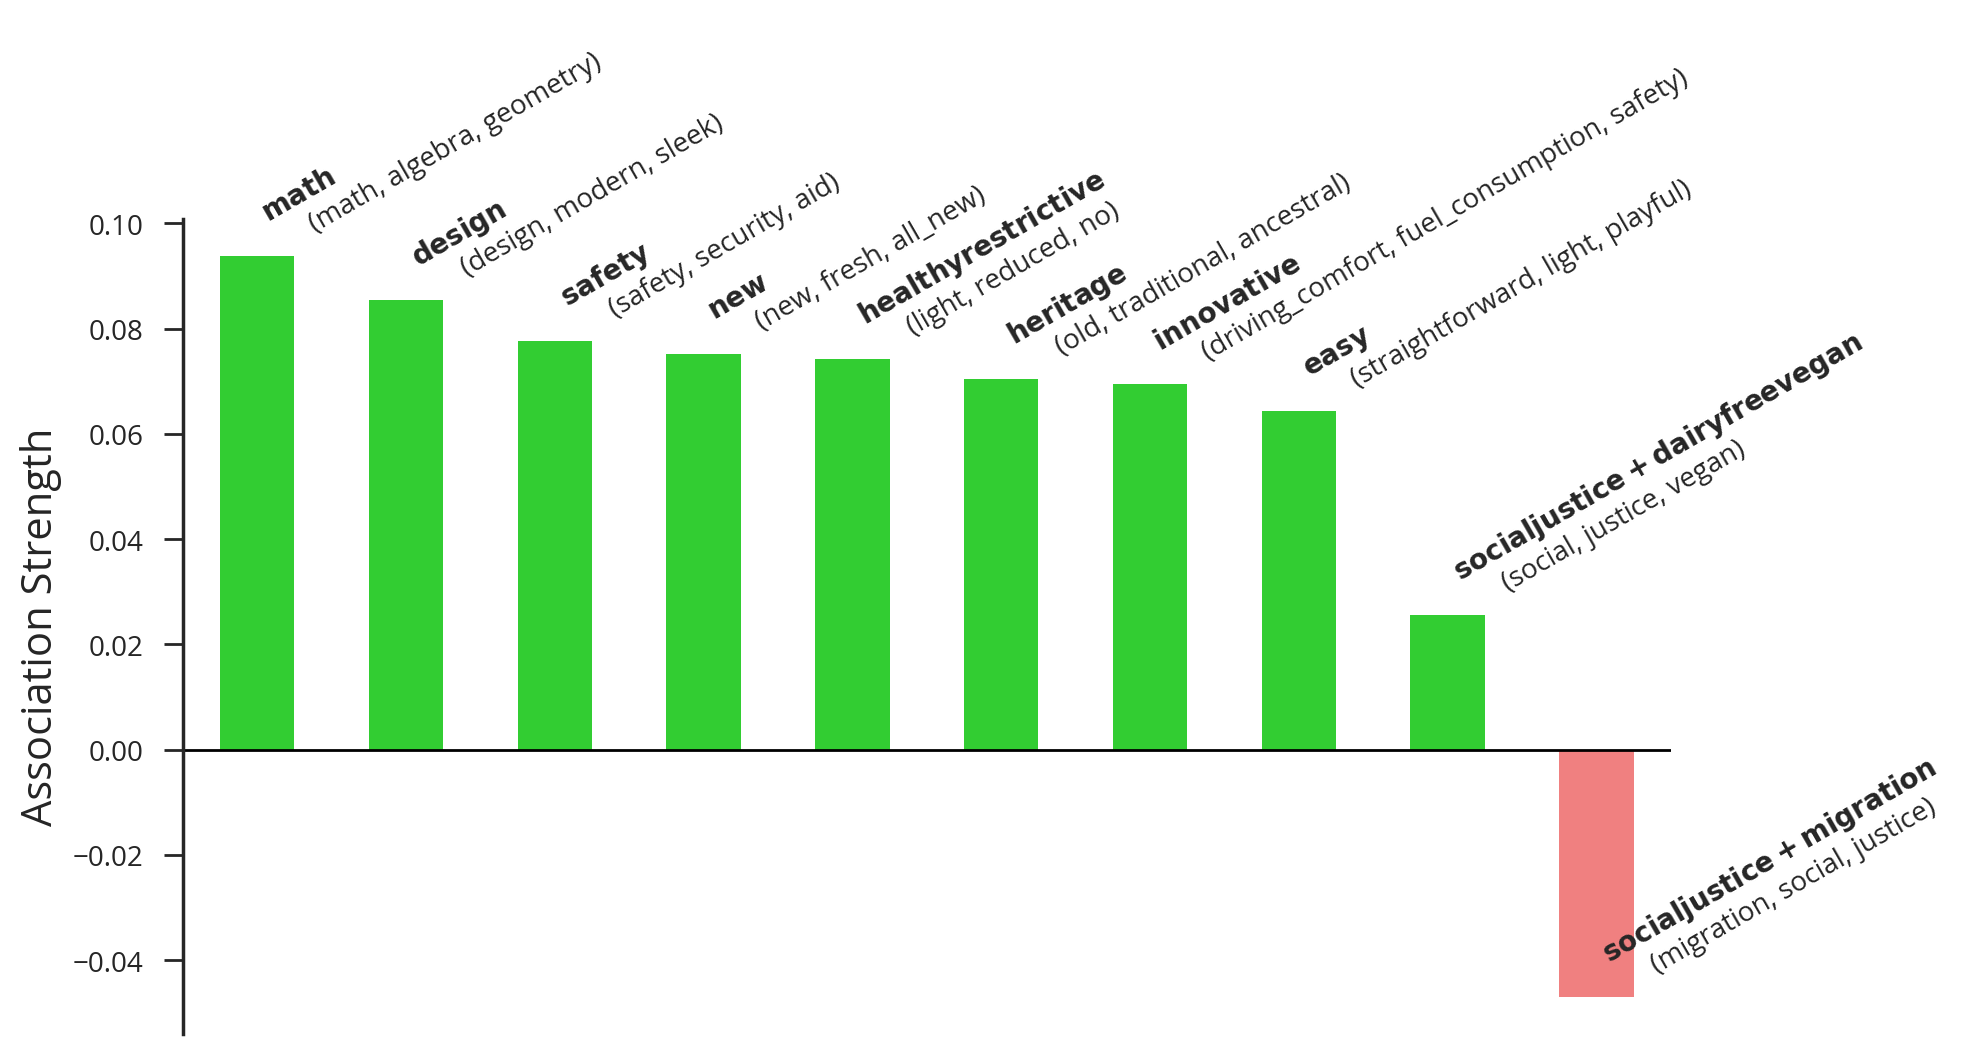

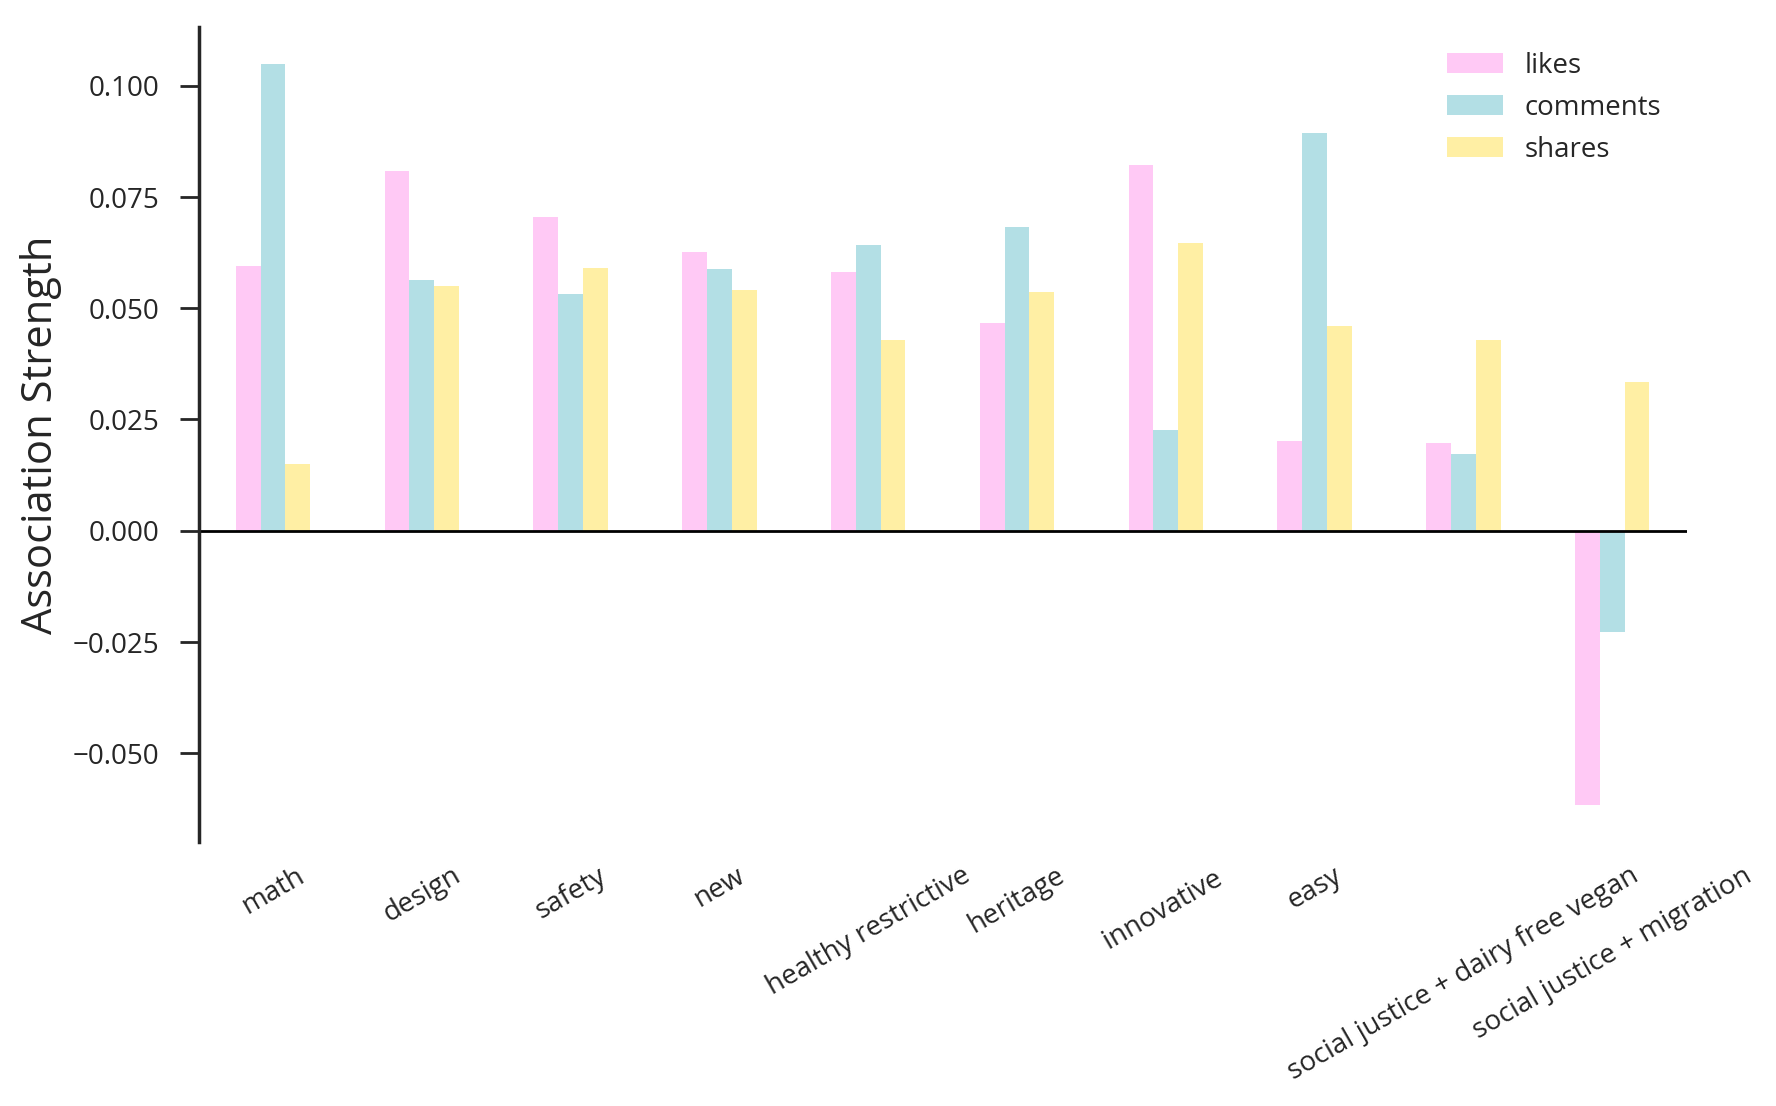

In [707]:
dat = fb
label = 'fb'
metric = 'success'
mode = 'default'
corrs = dat.corr()
success = corrs[metric]
success = success[[x for x in success.index if x not in ['success', 'likes', 'comments', 'shares']]].sort_values(ascending=False)
xx = get_top_ten_dim_with_spaze_dims(success)
top10 = xx.copy()
exemplars = dimensions.set_index('label').loc[top10.index, 'en'].str.replace(',', '').map(lambda x: ' '.join(x.split()[:3])).str.replace(' ', ', ').values

fig, ax = figure.init_figure()
sns.despine()
xx.index = [get_label(x) for x in xx.index]
bar = xx.plot.bar(ax=ax, color =  [map_color(x) for x in xx.values])
plt.xticks(range(10), '')# [get_label(x) for x in np.array(to_bar.index)[5:]], size=15);
for label in ax.get_xticklabels():
    label.set_rotation(30)

# ccs = []
# for container in bar.containers:
#     for index, rect in enumerate(container.get_children()):
#         height = rect.get_height()
# #         print(rect.get_x(), rect.get_width(), rect.get_height())
#         cc = plt.text(rect.get_x() + rect.get_width()/2.0, height, xx.index[index], ha='left', va='bottom', rotation = 30, bbox=dict(edgecolor='red', fc='red'))
#         ccs.append(cc)
# for cc in ccs:
#     bbox = cc.get_bbox_patch().get_extents()
#     extents = plt.gca().transData.inverted().transform(bbox)        
#     print(index, cc.get_text(), bbox, extents)
#     plt.text(extents[0,1], extents[0,0], exemplars[index], ha='left', va='bottom', rotation = 30)
    
for container in bar.containers:
    for index, rect in enumerate(container.get_children()):
        height = rect.get_height()
#         print(rect.get_x(), rect.get_width(), rect.get_height())
        dim = plt.text(rect.get_x() + rect.get_width()/2.0, height, r"$\bf{0}$".format(xx.index[index]) + '\n     (' + exemplars[index] + ')', ha='left', va='bottom', rotation = 30, bbox=dict(edgecolor='none', fc='none'))

ax.set_ylabel('Association Strength', fontsize=15)
plt.gca().tick_params(axis='y', length=7, which='major')
plt.axhline(y=0, xmin=0, xmax=10, color='k', linewidth=1)
plt.gca().spines['bottom'].set_visible(False)
# plt.savefig('../figs/overall_engagement/engagement_success_{}.png'.format(label), bbox_inches='tight', transparent=True)

fig, ax = figure.init_figure()
sns.despine()
decoupled = corrs.loc[top10.index, ['likes', 'comments', 'shares']]
decoupled.index = [get_label(x) for x in decoupled.index]
decoupled.plot.bar(ax=ax, color = pd.Series(likes.columns).map(colors))
# plt.xticks(range(10), [get_label(x) for x in np.array(to_bar.index)[5:]], size=15);
for label in ax.get_xticklabels():
    label.set_rotation(30)
ax.set_ylabel('Association Strength', fontsize=15)
plt.gca().tick_params(axis='y', length=7, which='major')
plt.axhline(y=0, xmin=0, xmax=10, color='k', linewidth=1)
plt.gca().spines['bottom'].set_visible(False)

label
math                                 math algebra geometry calculus equations compu...
design                               design modern sleek slender form idea layout v...
safety                               safety security aid first aid save saving save...
new                                                  new fresh all_new brand_new model
healthy_restrictive                  light reduced no added sugar low-carb choleste...
heritage                             old traditional ancestral hereditary brought h...
innovative_rachel                    driving_comfort fuel_consumption safety techno...
easy                                 straightforward light playful simple undemandi...
social justice + dairy free vegan                                 social justice vegan
social justice + migration                                    migration social justice
Name: en, dtype: object
-0.25 0.5 0.09385764443299988
0.75 0.5 0.08535334824034632
1.75 0.5 0.0776166239464484
2.75 0.5 0.07

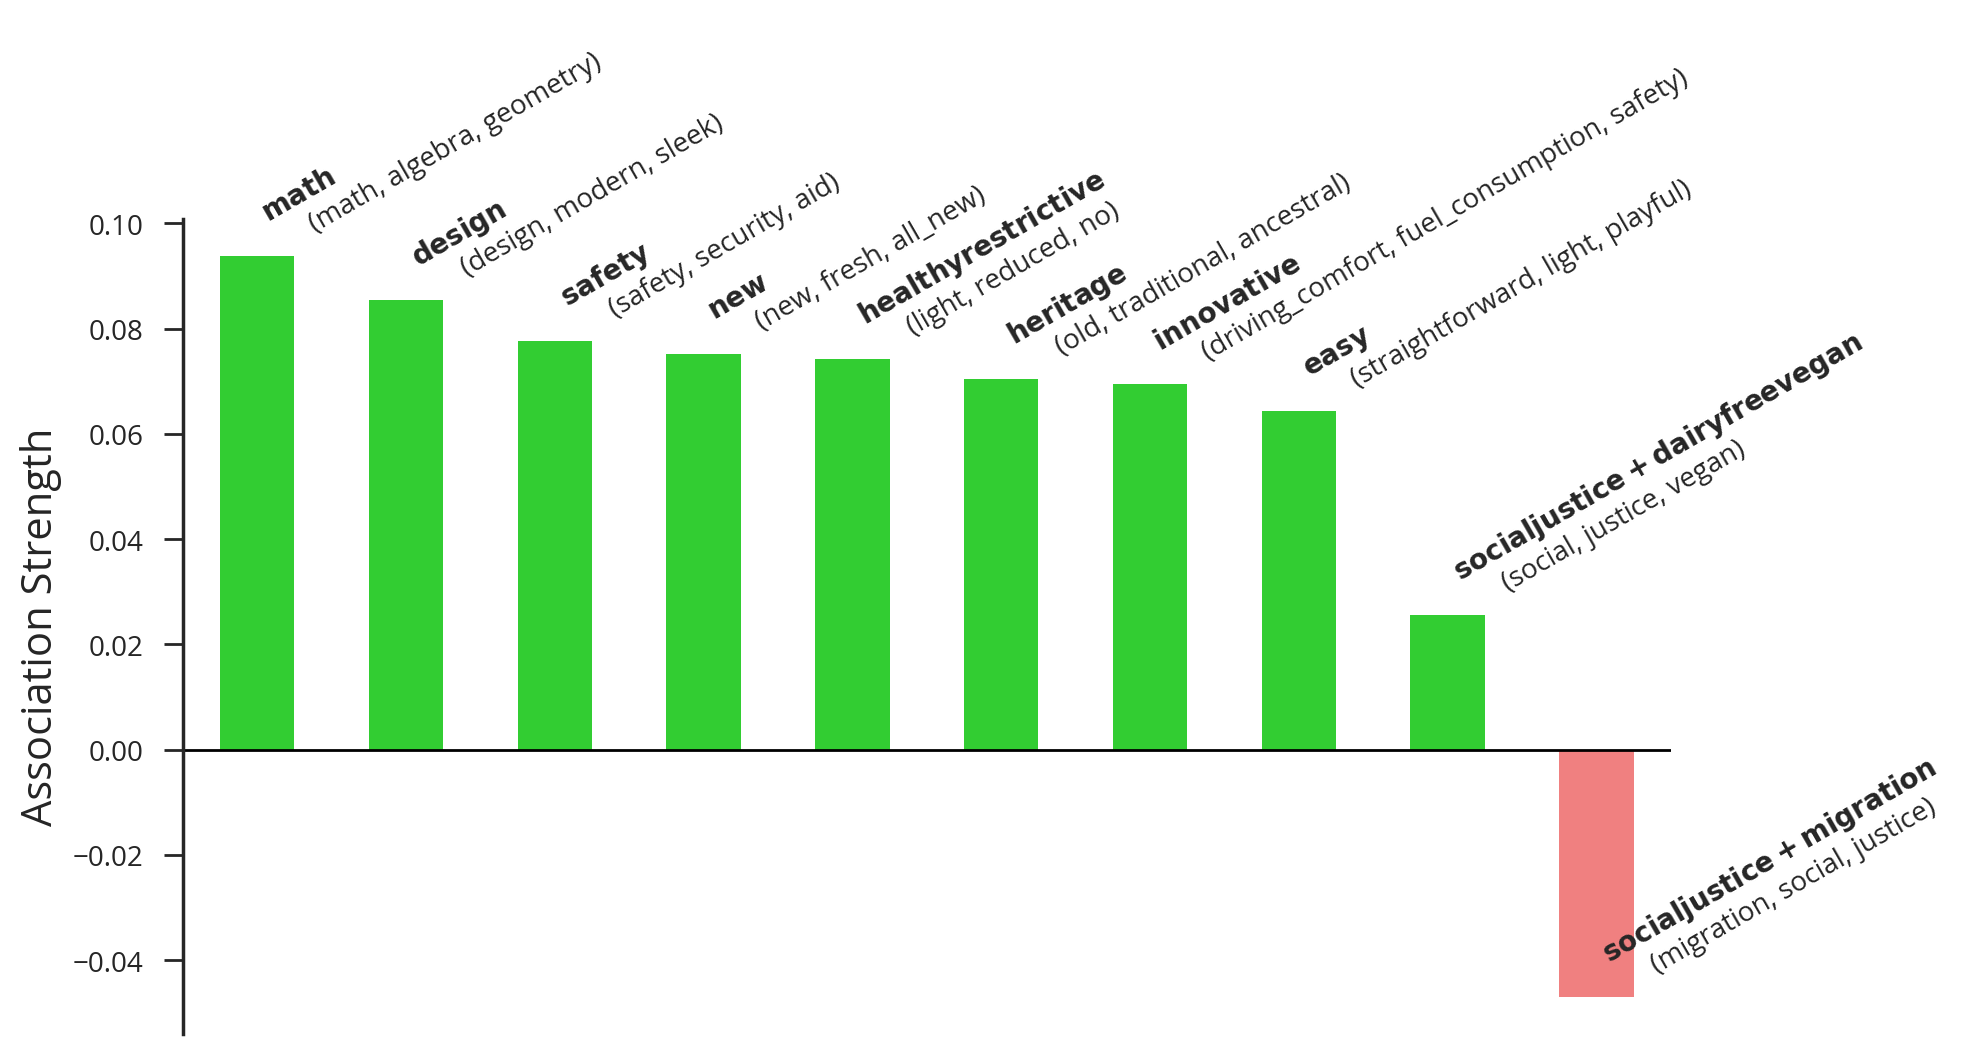

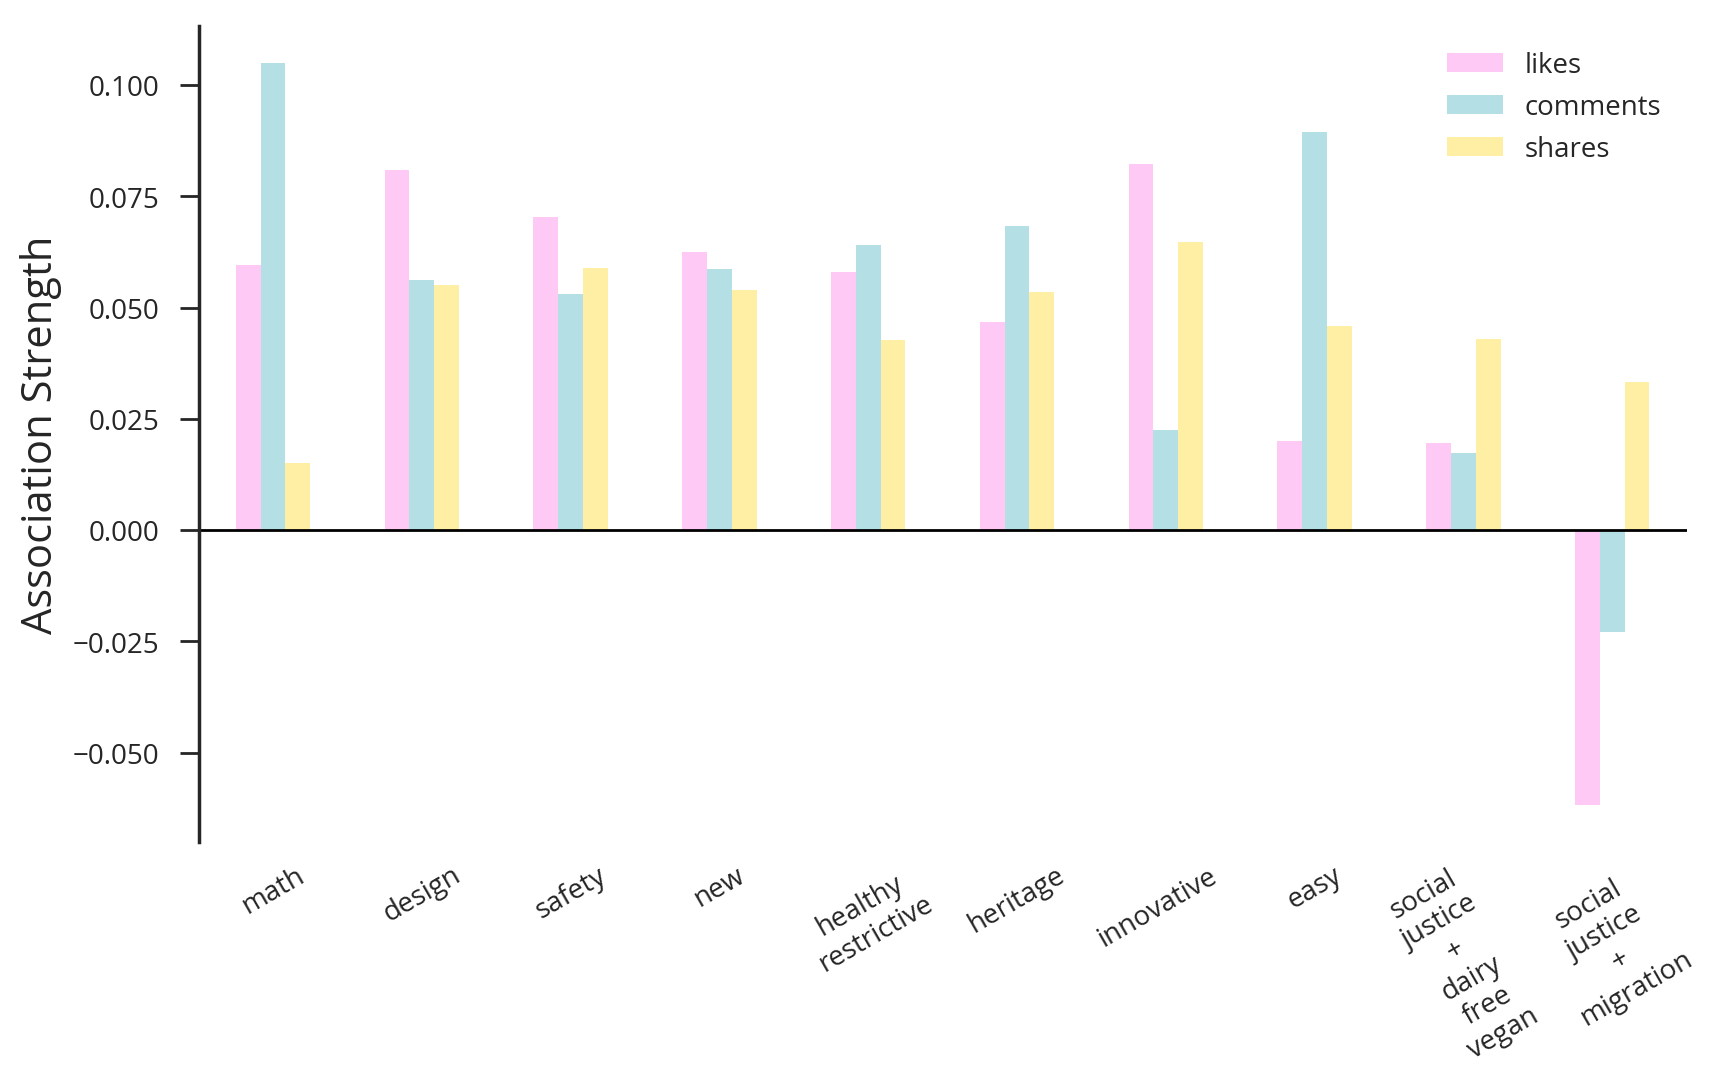

In [708]:
plot_overall_engagement(fb, 'fb')

# (2) Thresholded bar graphs

In [359]:
migration = fb[fb['social justice + migration'] >= 0.3]
vegan = fb[fb['social justice + dairy free vegan'] >= 0.3]

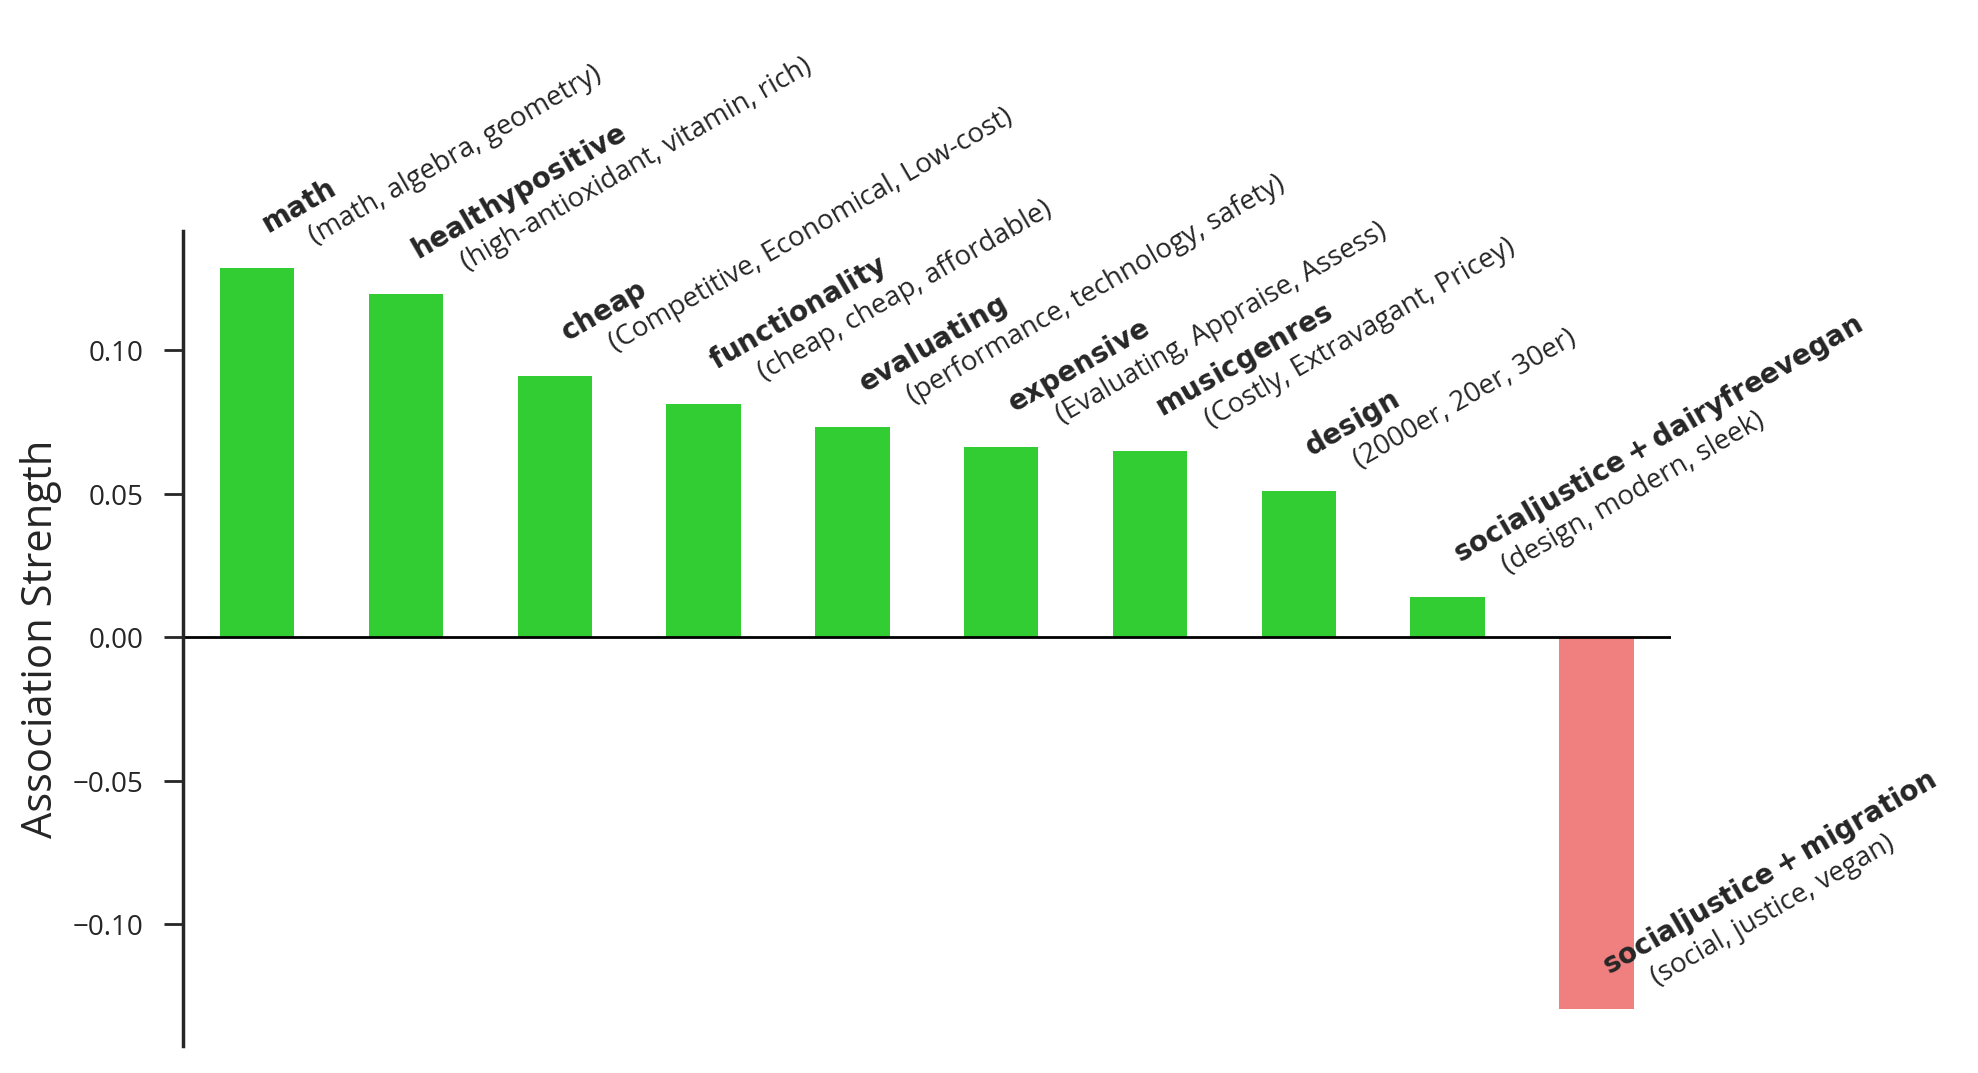

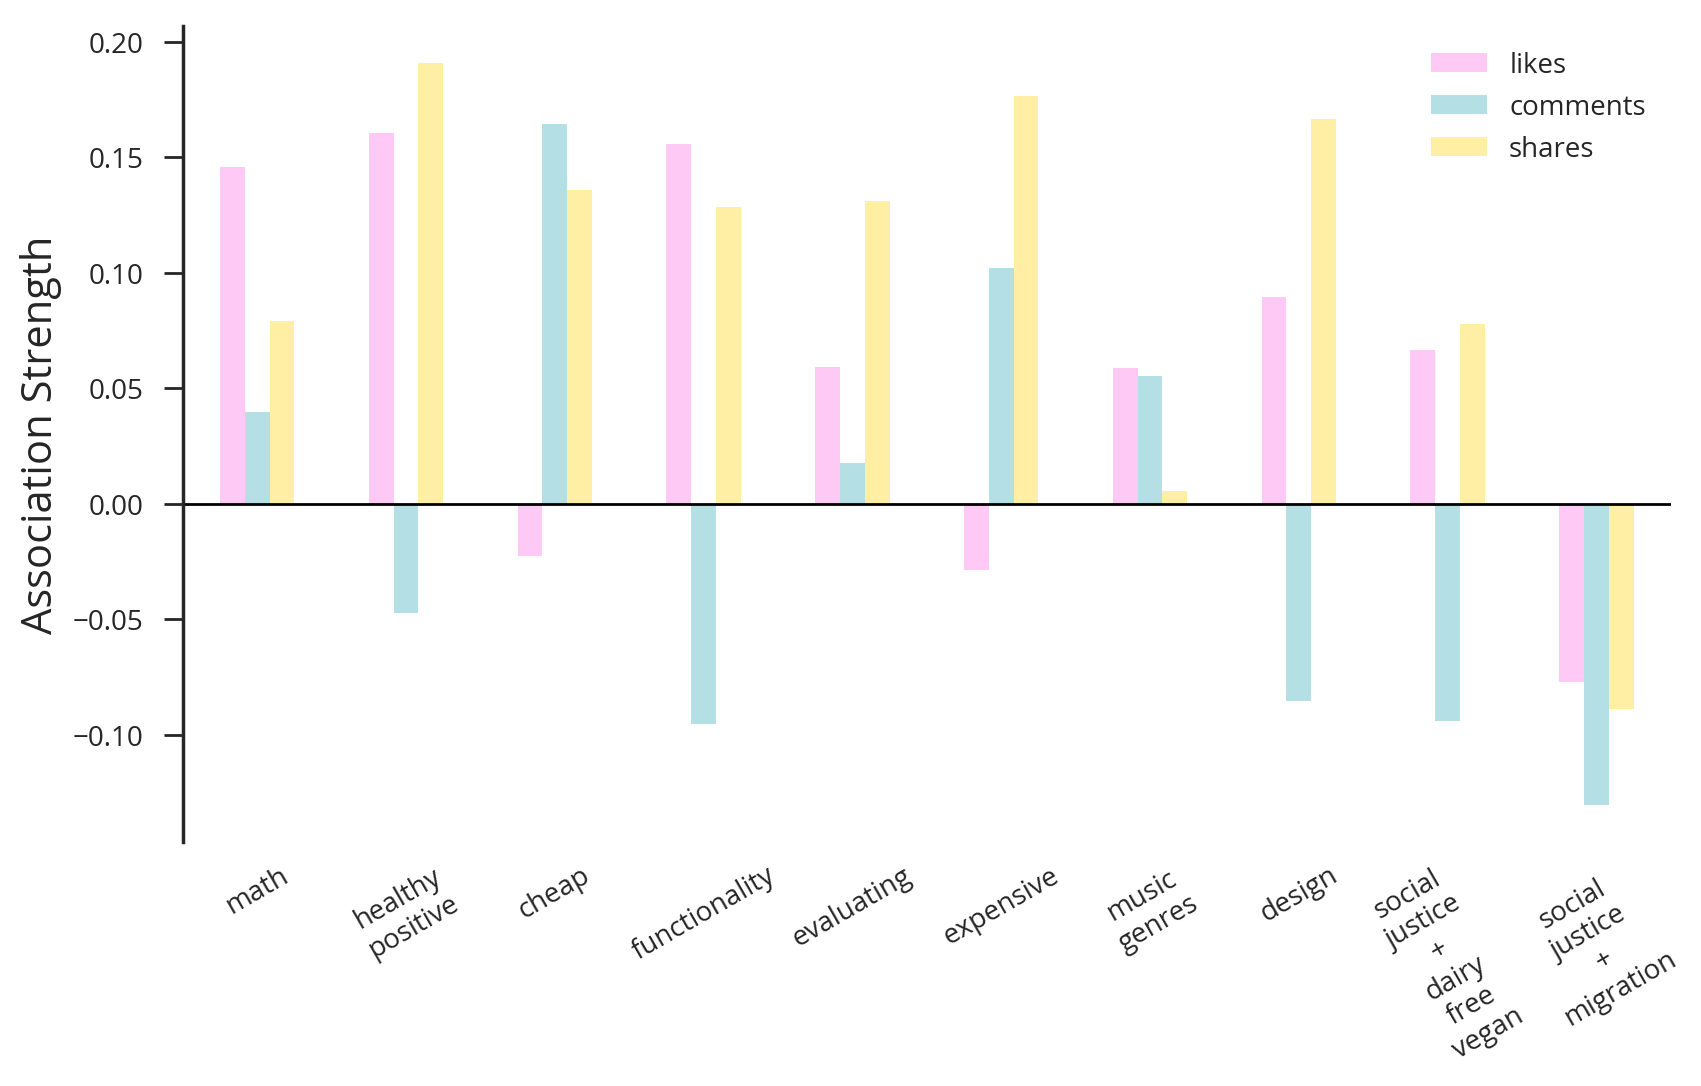

In [712]:
plot_overall_engagement(vegan, 'fb', metric = 'success', mode = 'migration')

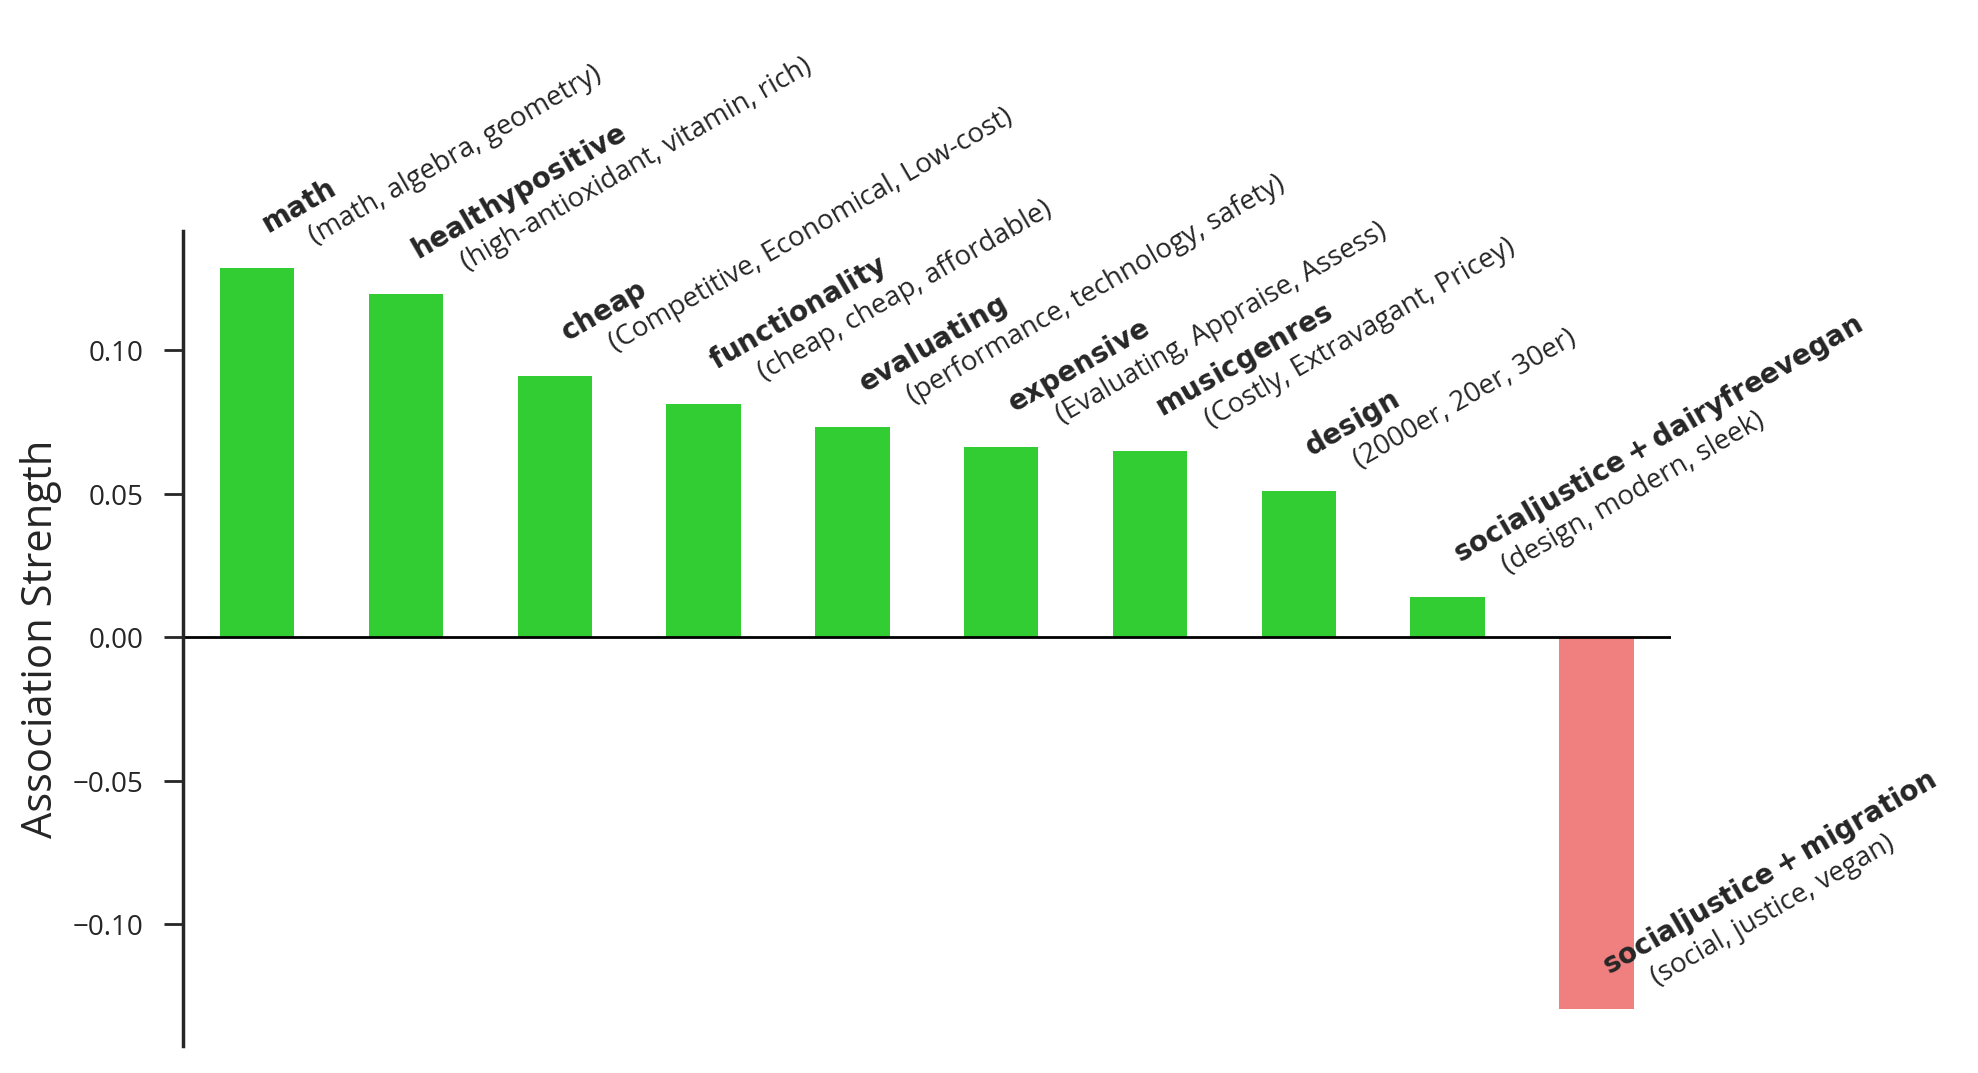

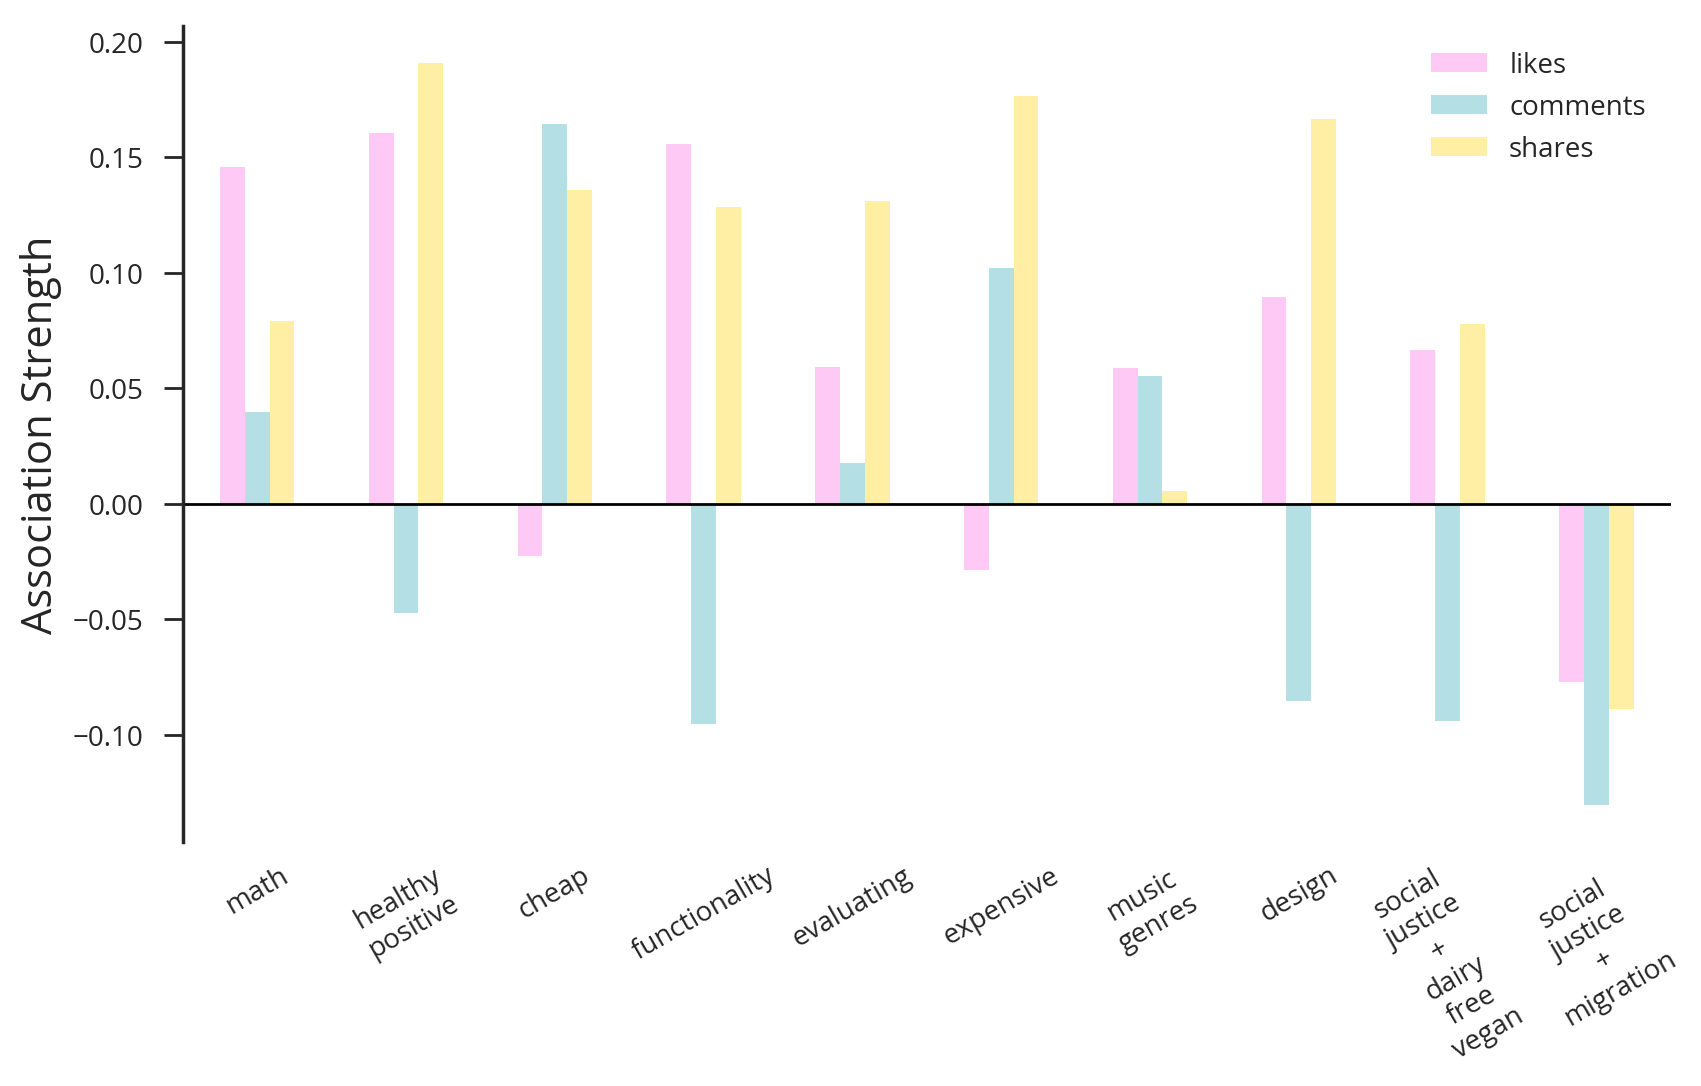

In [713]:
plot_overall_engagement(vegan, 'fb', metric = 'success', mode = 'vegan')

# (3) Thresholded line graphs

In [23]:
c_success = '#A7DB65'

In [41]:
def get_line_graph(dat, label, mode = 'default', metric = 'success'):
    plt.figure(figsize=(2000/float(208), 1200/float(208)), dpi=208)
    ax = plt.gca()

    rel = dat[dat['created_time']>='2017-01']
    rel['created_time'] = pd.to_datetime(rel['created_time'])

    rel = rel.sort_values('created_time', ascending=True)
    rel[rel['created_time'] >= '2017-01'].plot('created_time', metric, ax=plt.gca(), c = c_success, linewidth=2.0, label = 'success score')
    # ax.plot(fb_df['created_time'], fb_df['success'], c=c_success, linewidth=3.0, label='success score')
    ax.set_ylabel("success score", fontsize=14)
    ax.legend(loc=2)
    ax.axes.get_xaxis().set_ticks([])
    # plt.ylim(-500, 30000)
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.set_xlabel('link-posts in chronological order', fontsize=12)
    ax.legend_.remove()

    if mode == 'default':
        plt.savefig('../figs/overall_line_csv/{}_{}_{}.png'.format(label, mode, metric), bbox_inches='tight', transparent=True)
        rel.sort_values(metric, ascending=False).head(10)[['created_time', 'message', metric]].to_csv('../processed/overall_line/{}_{}_{}.csv'.format(label, mode, metric))
    else:
        plt.savefig('../figs/thresholded_line_csv/{}_{}_{}.png'.format(label, mode, metric), bbox_inches='tight', transparent=True)
        rel.sort_values(metric, ascending=False).head(10)[['created_time', 'message', metric]].to_csv('../processed/thresholded_line/{}_{}_{}.csv'.format(label, mode, metric))

created_time                                            message  \
86   2018-02-14 12:30:04       Mit wem möchtest du heute gemeinsam löffeln?   
128  2017-07-21 12:46:00  Refugees Welcome: Weil wir nicht nur Eiscreme ...   
122  2017-08-22 23:30:00  Wir heben unsere Löffel für besonders schutzbe...   
68   2018-03-22 21:30:00  Wir sagen 50.000 mal Danke für eure Unterstütz...   
110  2017-11-24 20:52:59  Berliner Eisliebhaber aufgepasst: Zusammen mit...   

     success  
86    1353.0  
128     87.0  
122     47.0  
68      31.0  
110     15.0

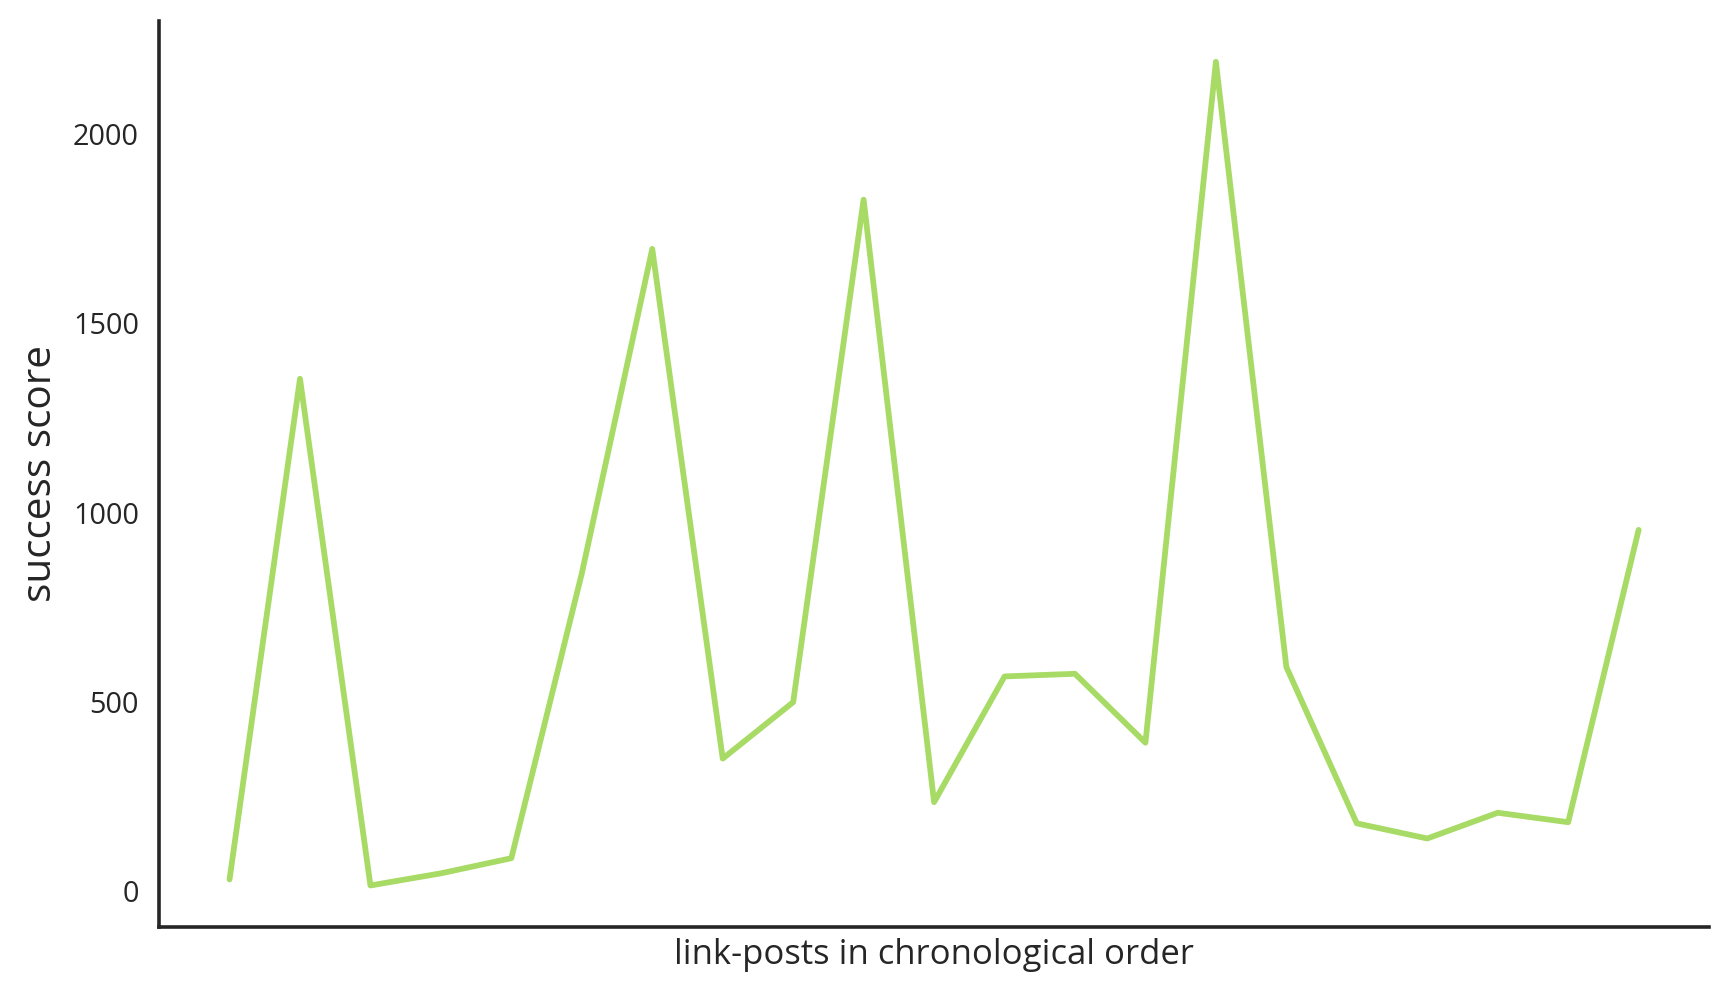

In [310]:
get_line_graph(migration, 'migration')

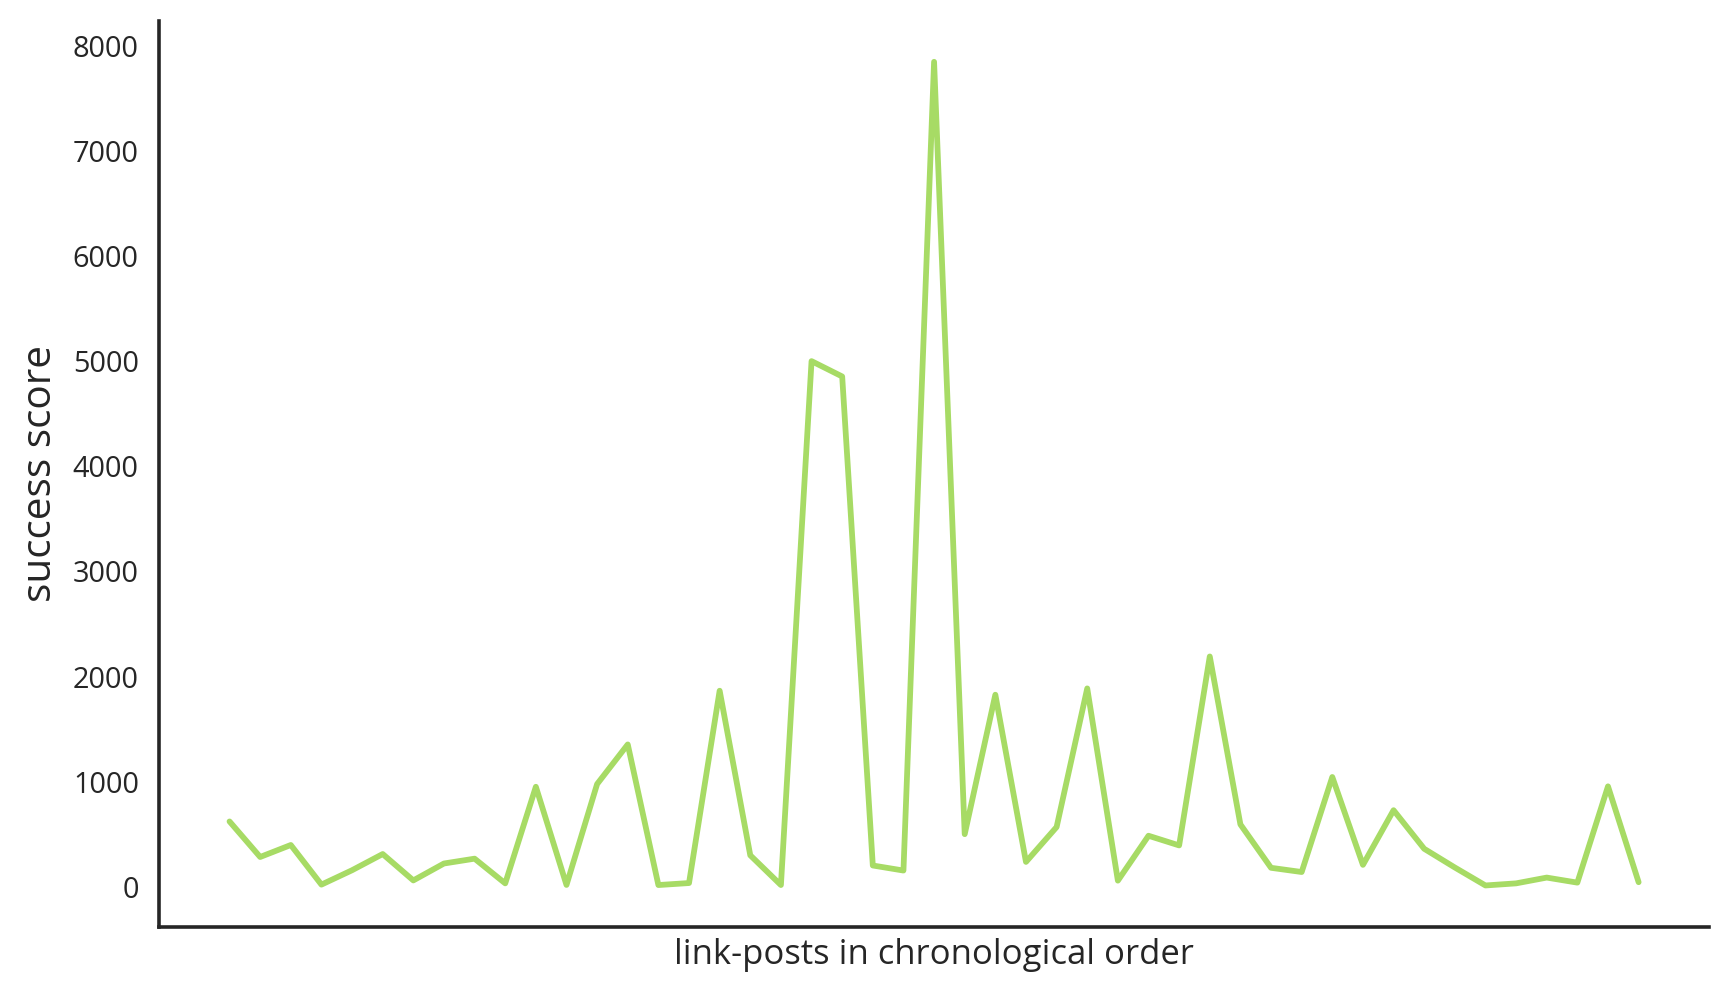

In [311]:
get_line_graph(vegan, 'vegan')

# (A) RUN OVER ALL FILES

In [25]:
import os

In [23]:
xx=pd.read_csv('../processed/processed_IG_Lemonaid.csv')

In [24]:
xx[xx['social justice + migration']>]

message  \
0    The world needs more of this kind.\n.\n.\n.\n#...   
1    Check out the new episode of our #upcycling tu...   
2    Ian of @mightyoaksmusic on cat videos with a m...   
3    Festival season is on fire. We have the perfec...   
4    Don't forget your greens. 📷: @gingerella_gini ...   
5      The Lemonaid DRINKING HELPS idea in a nutshell.   
6    Voilá - a macramé plant hanger made of a Lemon...   
7    We make summer even more colorful. See how the...   
8    Wir begleiten Skaterin @caroline.dynybil auf i...   
9                            Word. 📷: @variousandgould   
10   Soft drinks, strong values. 📷: @locally.inspir...   
11   Wie von dir gemacht, nur von uns gemacht. 📷: @...   
12                              Word. @ich_bin_barbara   
13   100% natural. 📷: Lea Aring #drinkinghelps #lem...   
14   It's in your hands to make a difference. 📷: Ke...   
15   As hot as it tastes. The selection criteria of...   
16   Always a good idea: A cold drink made of our n...   
17   Buy less, choose well. 📷: @sloris_\n•\n•\n•\n•...   
18   Drinking helps - to fight thirst and exploitat...   
19   Wie von dir gemacht, nur von uns gemacht. Die ...   
20   #Drinkinghelps – but how, exactly? .\n.\nEvery...   
21   3 Dinge, die du diesen Sommer nicht verpassen ...   
22   Back to the roots. We use only the best #organ...   
23   Brennt für die gute Sache. #lemonaid #ingwer #...   
24   Drinking helps - now even more:\nThanks for su...   
25   Just passion. And fruit. 📷: Glen Carrie #lemon...   
26   Join the #fashionrevolutionweek 2018. Check ou...   
27   Lots of bottles sold resulted in supporting a ...   
28   Red is the new orange. 📷: Alex Loup\n•\n•\n•\n...   
29   Drinking helps, more than ever.\n•\n•\n•\n•\n•...   
..                                                 ...   
436  Die Orsons like our drinks. Obviously. #lemona...   
437  How drinking helps. #lemonaid #organic #fairtr...   
438  Searching for the best fairtrade ingredients.....   
439  A refrigerator ship, finally. lemonaid #organi...   
440  Let it grow. #lemonaid #organic #fairtrade #le...   
441  Summits we like: Hiking and picnic baskets ins...   
442  Festival season - finally!\nShare your best Le...   
443  Upcycling - another good one. #upcycling #bedo...   
444  Upcycling, the easy way. #upcycling #lemonaid ...   
445  Fresh out the box. #lemonaid #organic #fairtra...   
446  Be the change they're talking about. #lemonaid...   
447  Hey Spring. Great to have you back. Your frien...   
448  Drinking helps. - With 342.473,- €. for develo...   
449  Message in a bottle. #trinkenhilft #drinkinghe...   
450  The sun dial stopped at lunch break... #lemona...   
451          #lemonaid #drinkinghelps #konfetti #party   
452       #lemonaid #drinkinghelps #easter #eastereggs   
453            #lemonaid #drinkinghelps #rainy #stormy   
454                #lemonaid #drinkinghelps #supporter   
455              #lemonaid #drinkinghelps #diy #bottle   
456      #lemonaid #drinkinghelps #sticker #elk #moose   
457  #lemonaid #drinkinghelps #diy #upcycling #vase...   
458                                       YAy wie cool   
459             #lemonaid #drinkinghelps #mrt #sticker   
460  #lemonaid #drinkinghelps #diy #upycling #limo ...   
461    #lemonaid #drinkinghelps #killyourtv #streetart   
462                             Soo lecker @_lemonaid_   
463  #lemonaid #drinkinghelps #trinkenhilft #festiv...   
464  #lemonaid #drinkinghelps #trinkenhilft #festiv...   
465                Neue Shirts #trinkenhilft #T-Shirts   

                                                tokens  success  likes  \
0    ['the', 'world', 'needs', 'more', 'of', 'this'...      150    140   
1    ['check', 'out', 'the', 'new', 'episode', 'of'...     4019   4003   
2    ['ian', 'of', 'mightyoaksmusic', 'on', 'cat', ...     1235   1231   
3    ['festival', 'season', 'is', 'on', 'fire', 'we...      186    180   
4    ['don', 't', 'forget', 'your', 'greens', '📷', ...      770    758   
5    [

In [26]:
os.listdir('../processed')

['processed_FB_GreenpeaceCH.csv',
 '.DS_Store',
 'processed_FB_BenandJerrys.csv',
 'processed_IG_Lemonaid.csv',
 'processed_FB_jungundnaiv.csv',
 'thresholded_line',
 'processed_IG_AminataBelli.csv',
 'overall_line',
 'processed_FB_Victoria.van.Violence.csv',
 'processed_FB_AminataBelli.csv',
 'processed_FB_GreenpeaceDE.csv',
 'processed_IG_jungundnaiv.csv',
 'processed_IG_Greenpeace.csv',
 'processed_IG_MissesVlog.csv',
 'processed_IG_Victoria.van.Violence.csv',
 'processed_IG_BenandJerrys.csv',
 'processed_FB_MissesVlog.csv',
 'processed_FB_enormmagazin.csv']

processed_FB_GreenpeaceCH.csv


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


processed_FB_BenandJerrys.csv
processed_IG_Lemonaid.csv
processed_FB_jungundnaiv.csv
processed_IG_AminataBelli.csv
processed_FB_Victoria.van.Violence.csv
processed_FB_AminataBelli.csv


/Users/piocalderon/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


processed_FB_GreenpeaceDE.csv
processed_IG_jungundnaiv.csv
processed_IG_Greenpeace.csv
processed_IG_MissesVlog.csv
processed_IG_Victoria.van.Violence.csv
processed_IG_BenandJerrys.csv
processed_FB_MissesVlog.csv
processed_FB_enormmagazin.csv


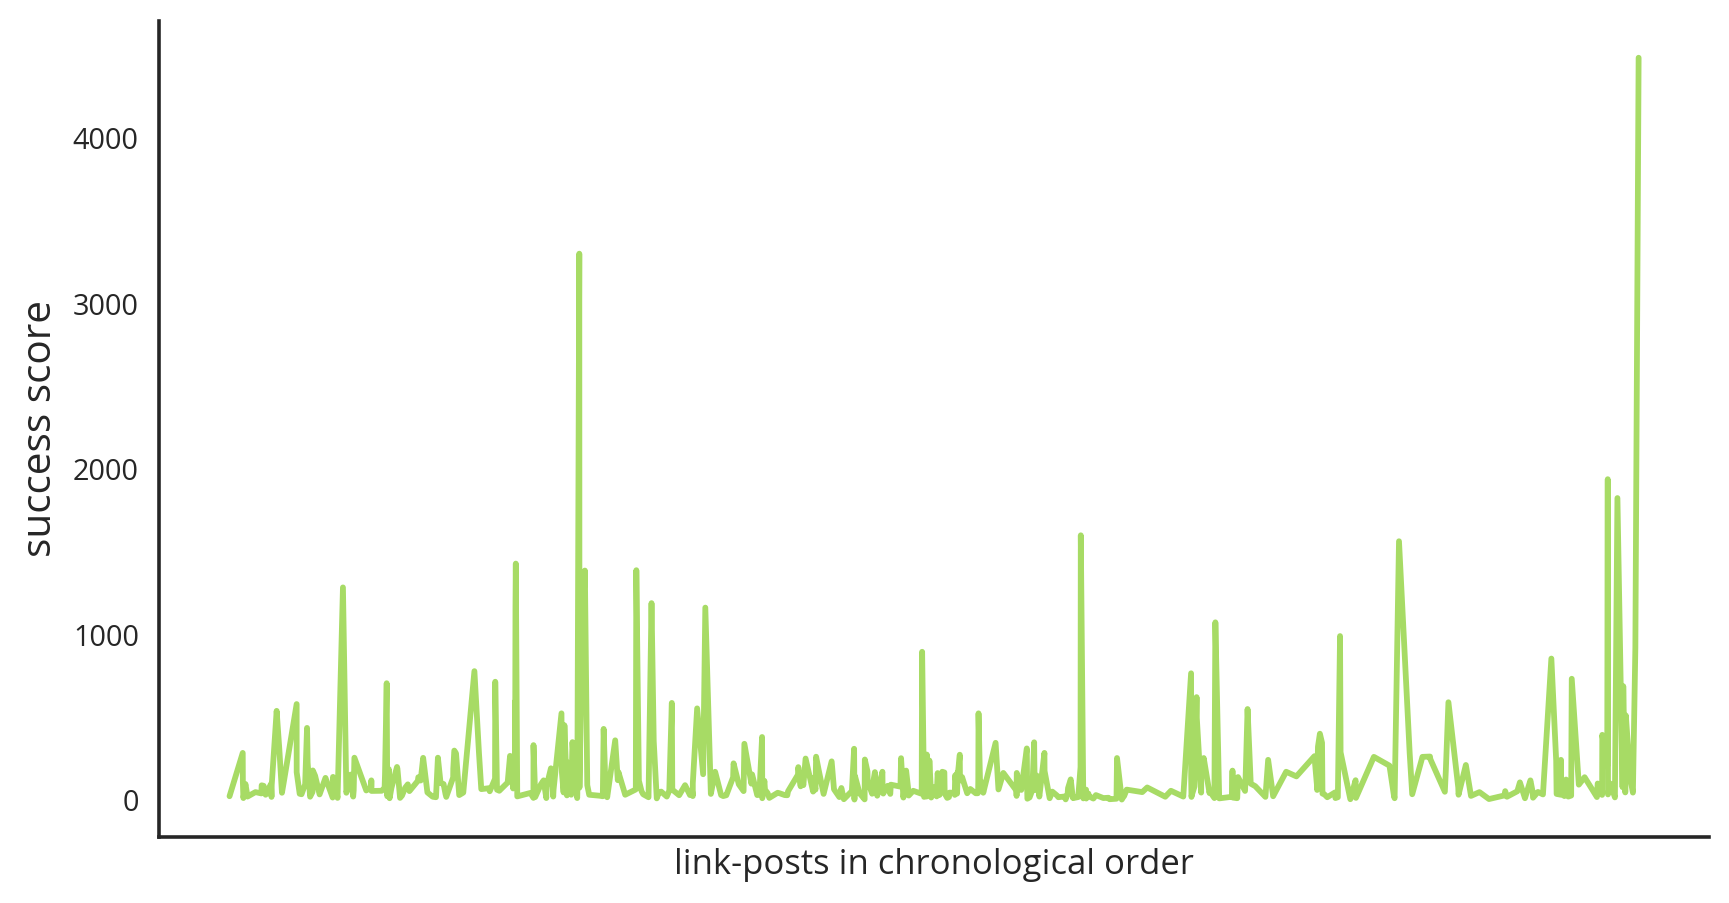

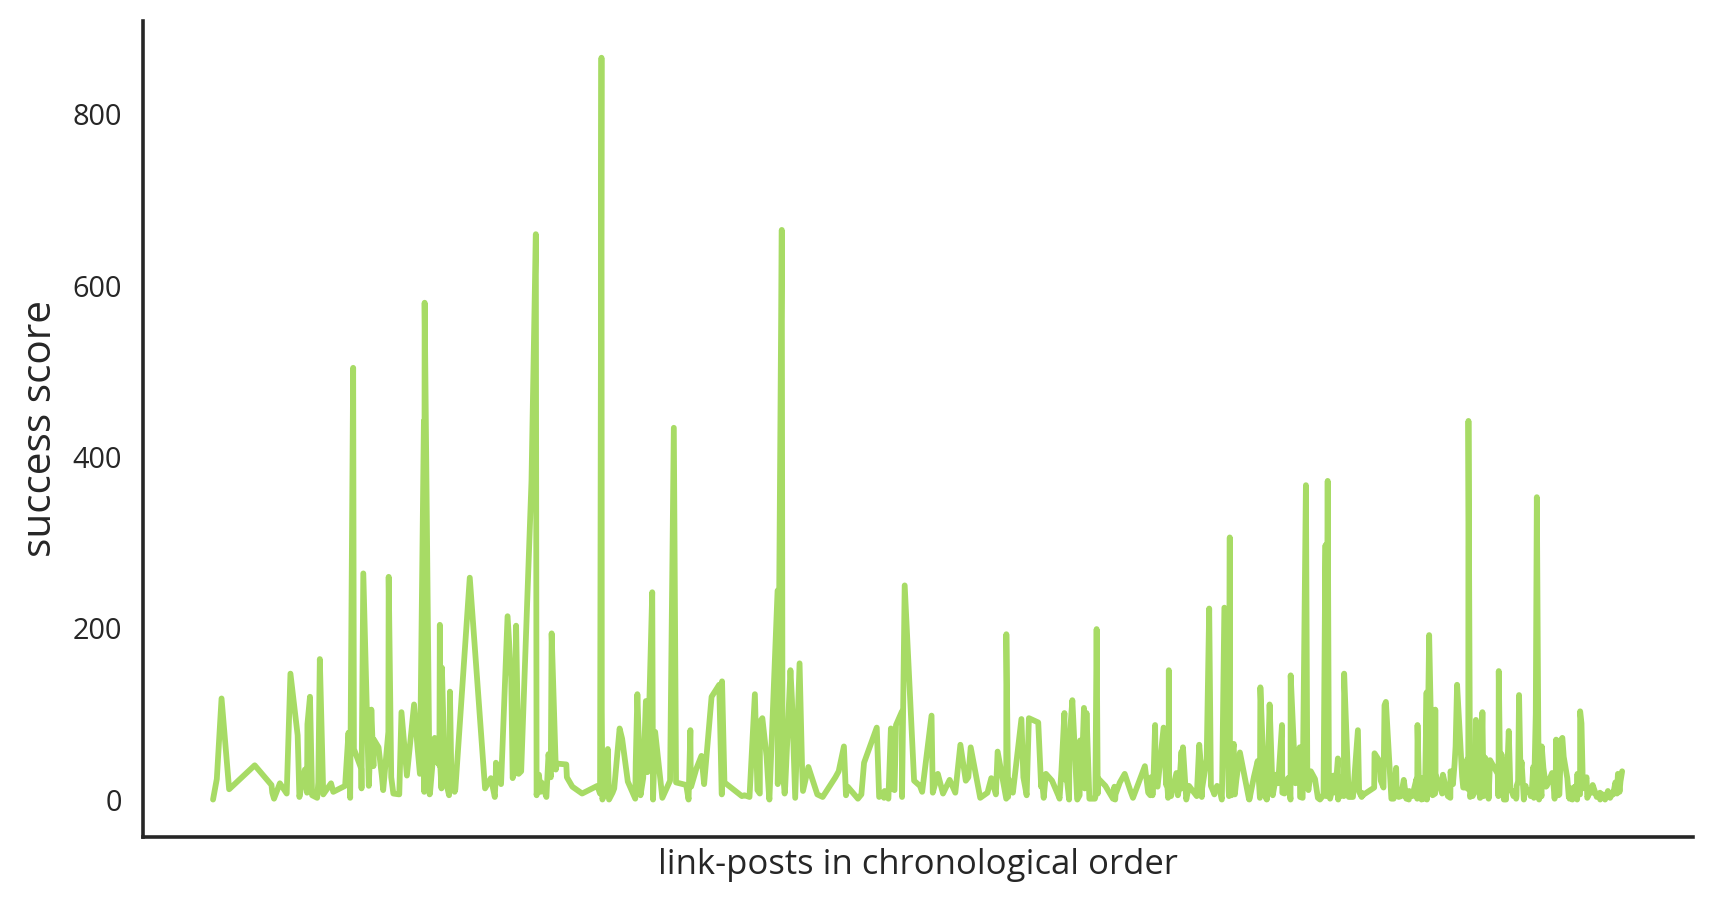

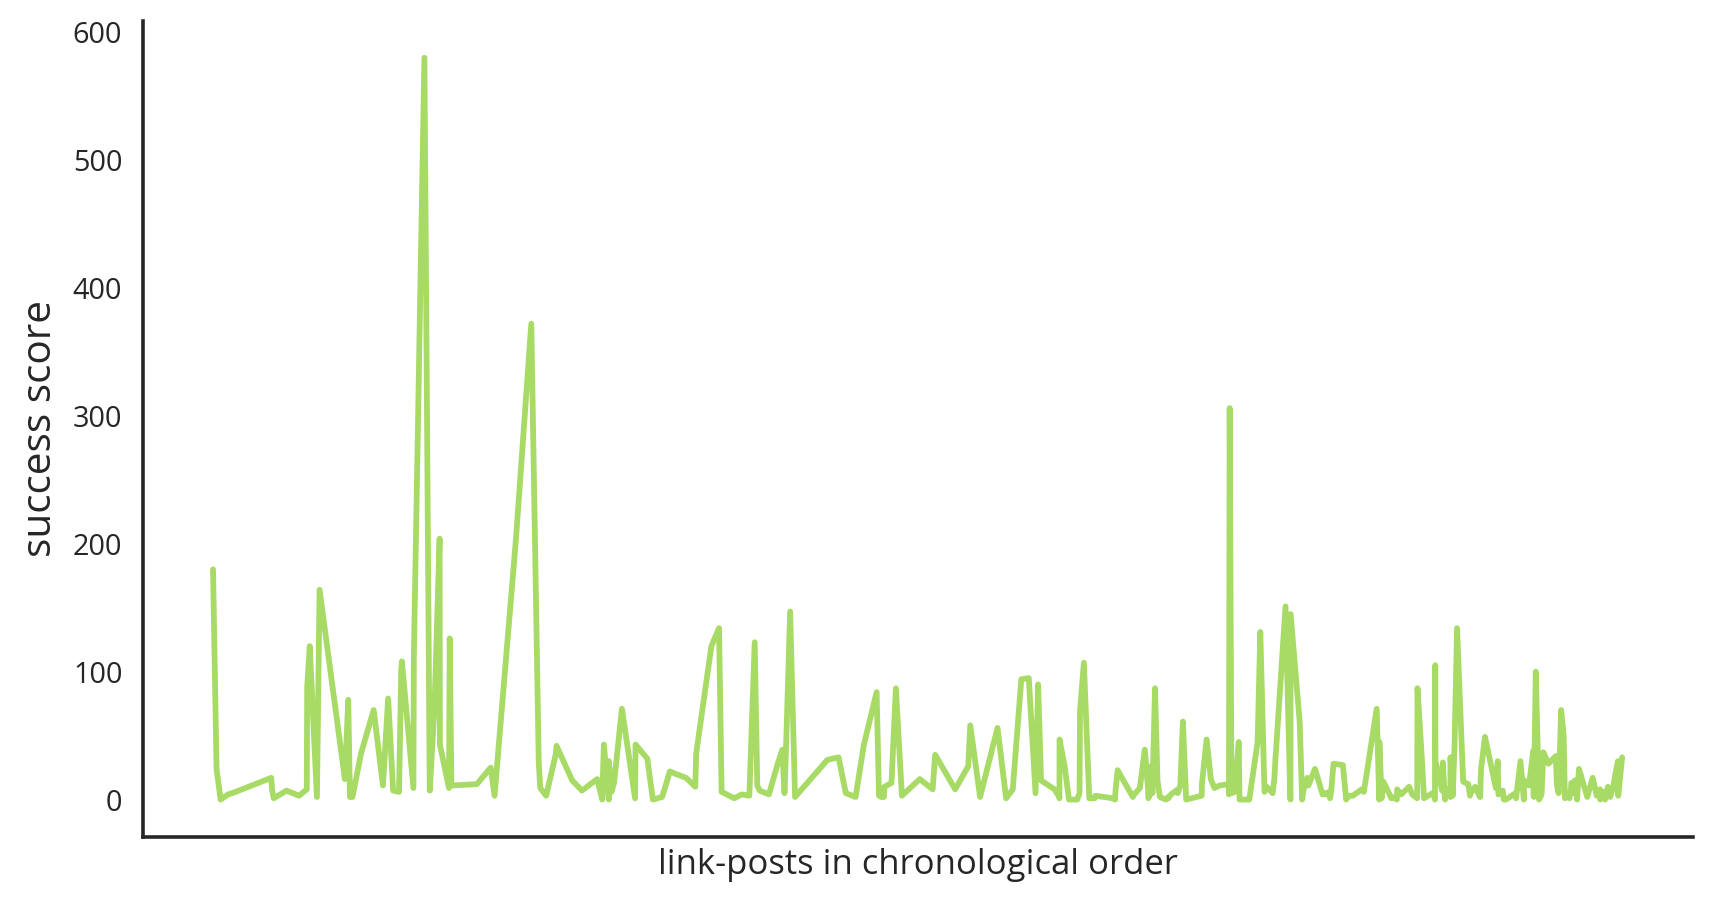

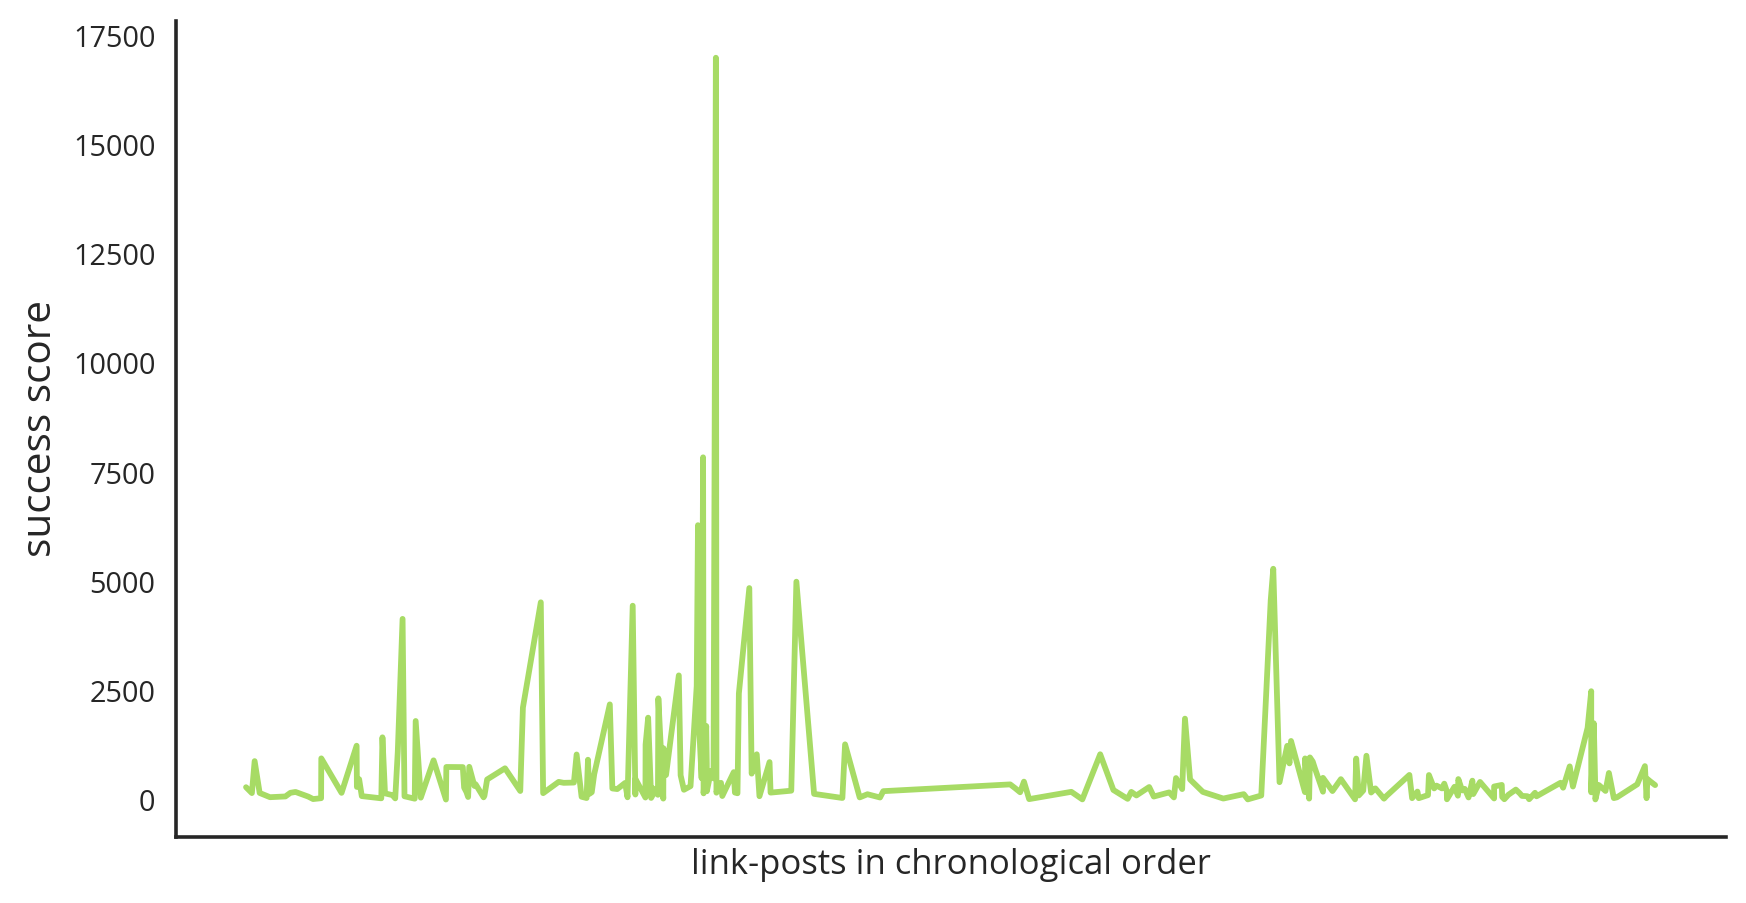

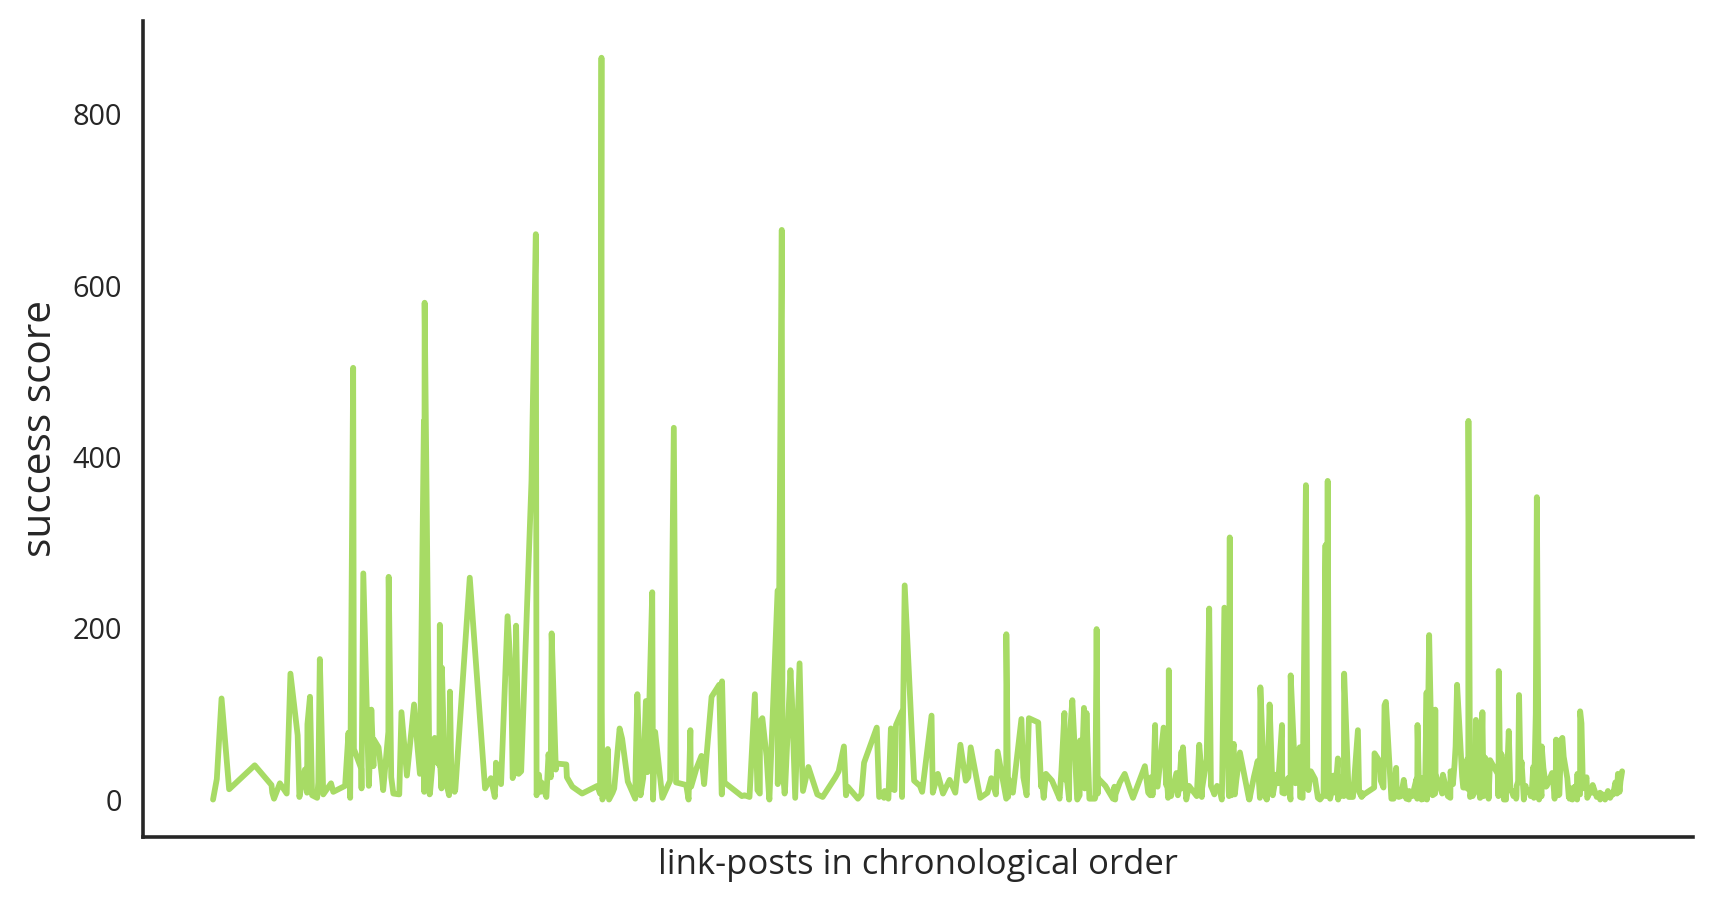

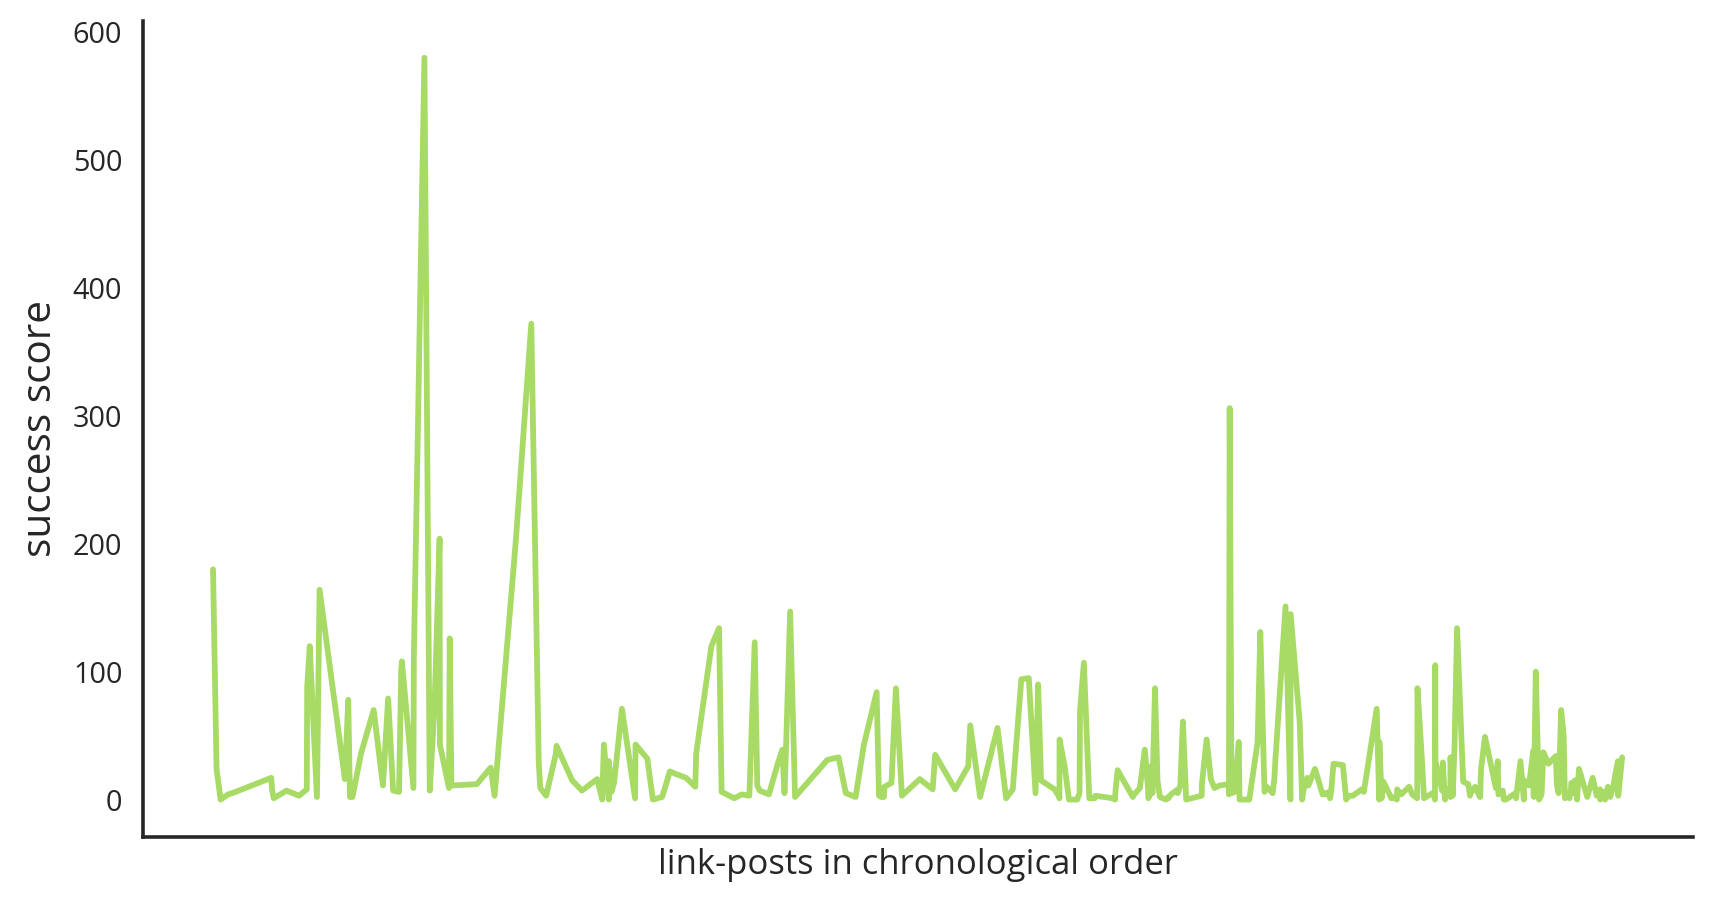

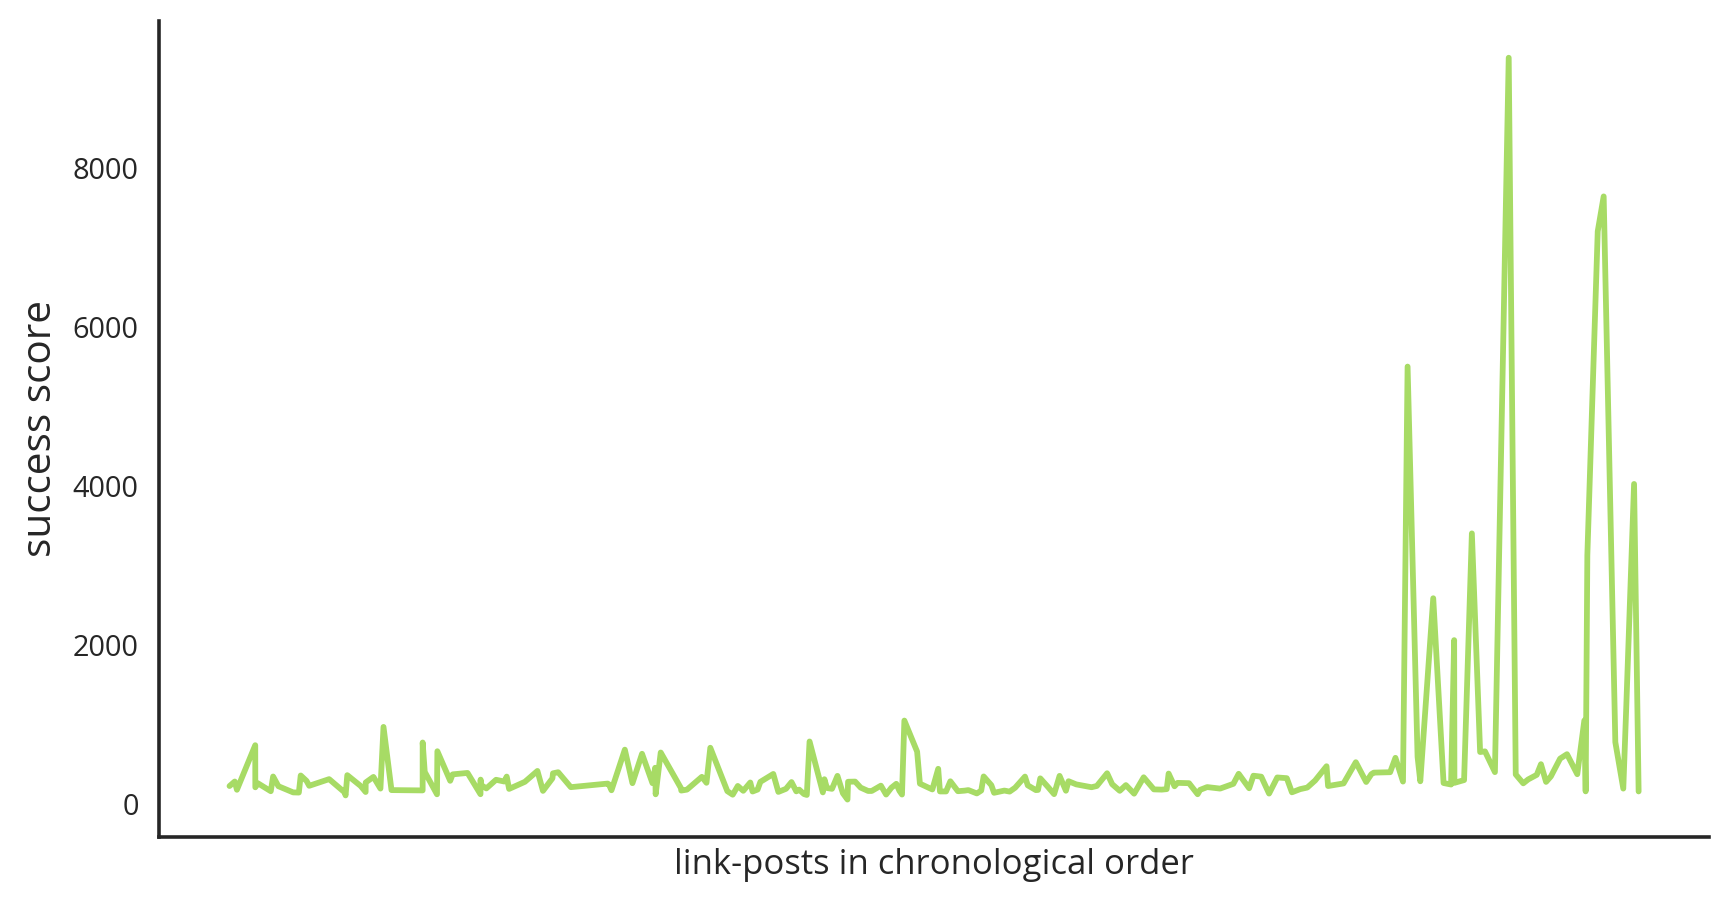

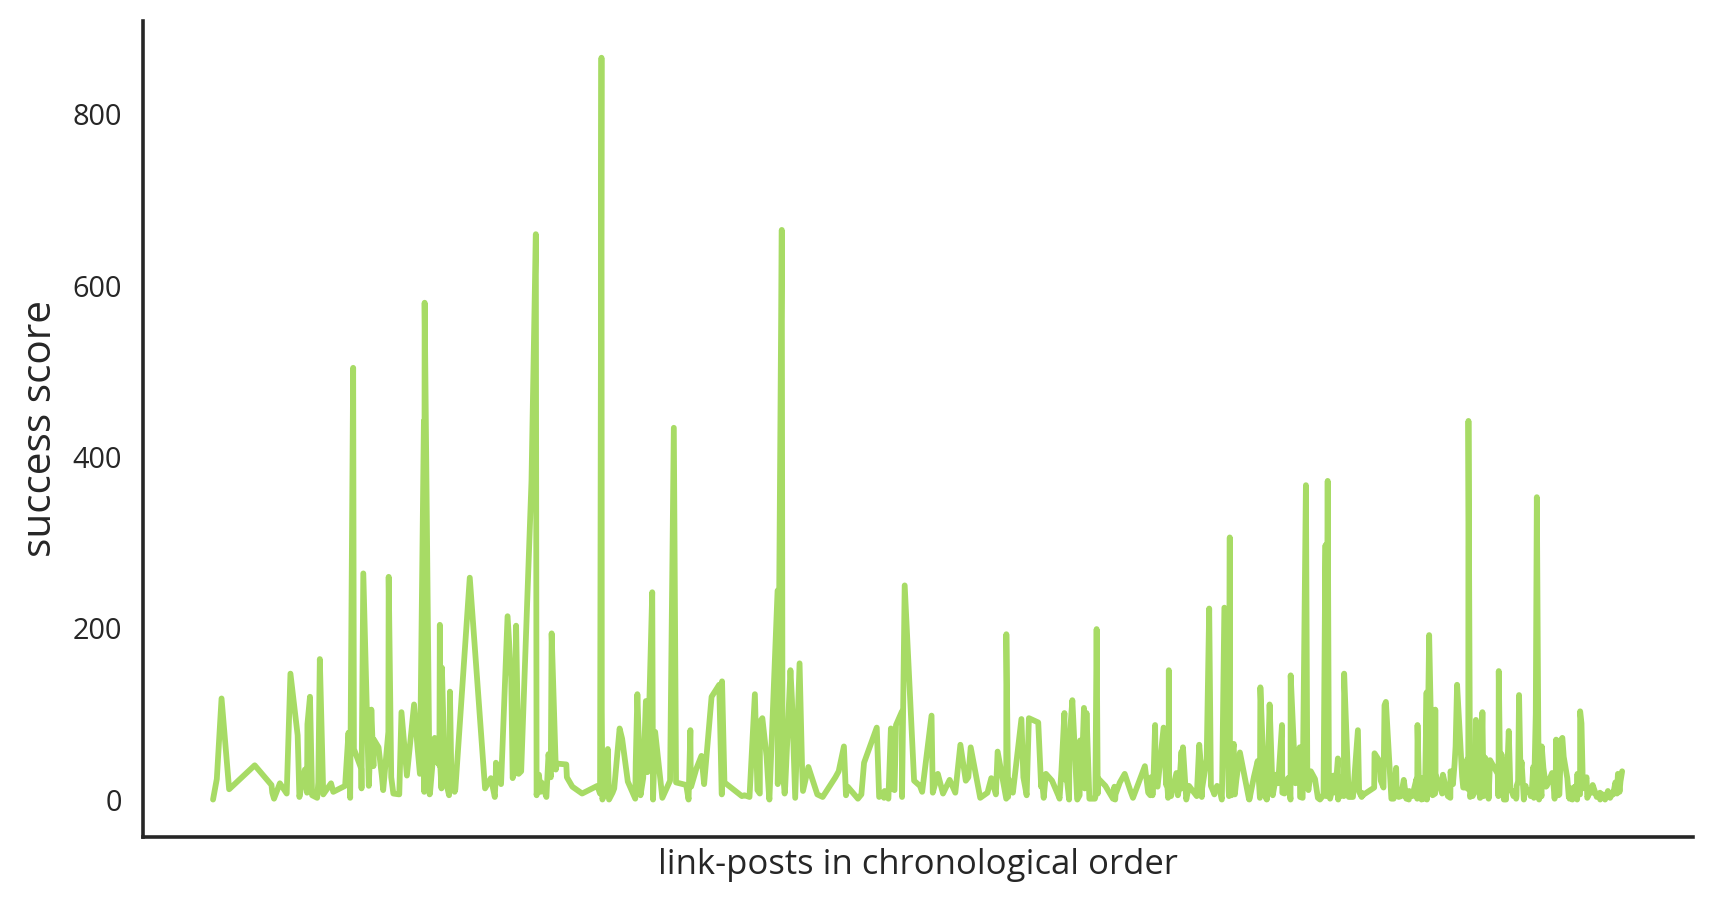

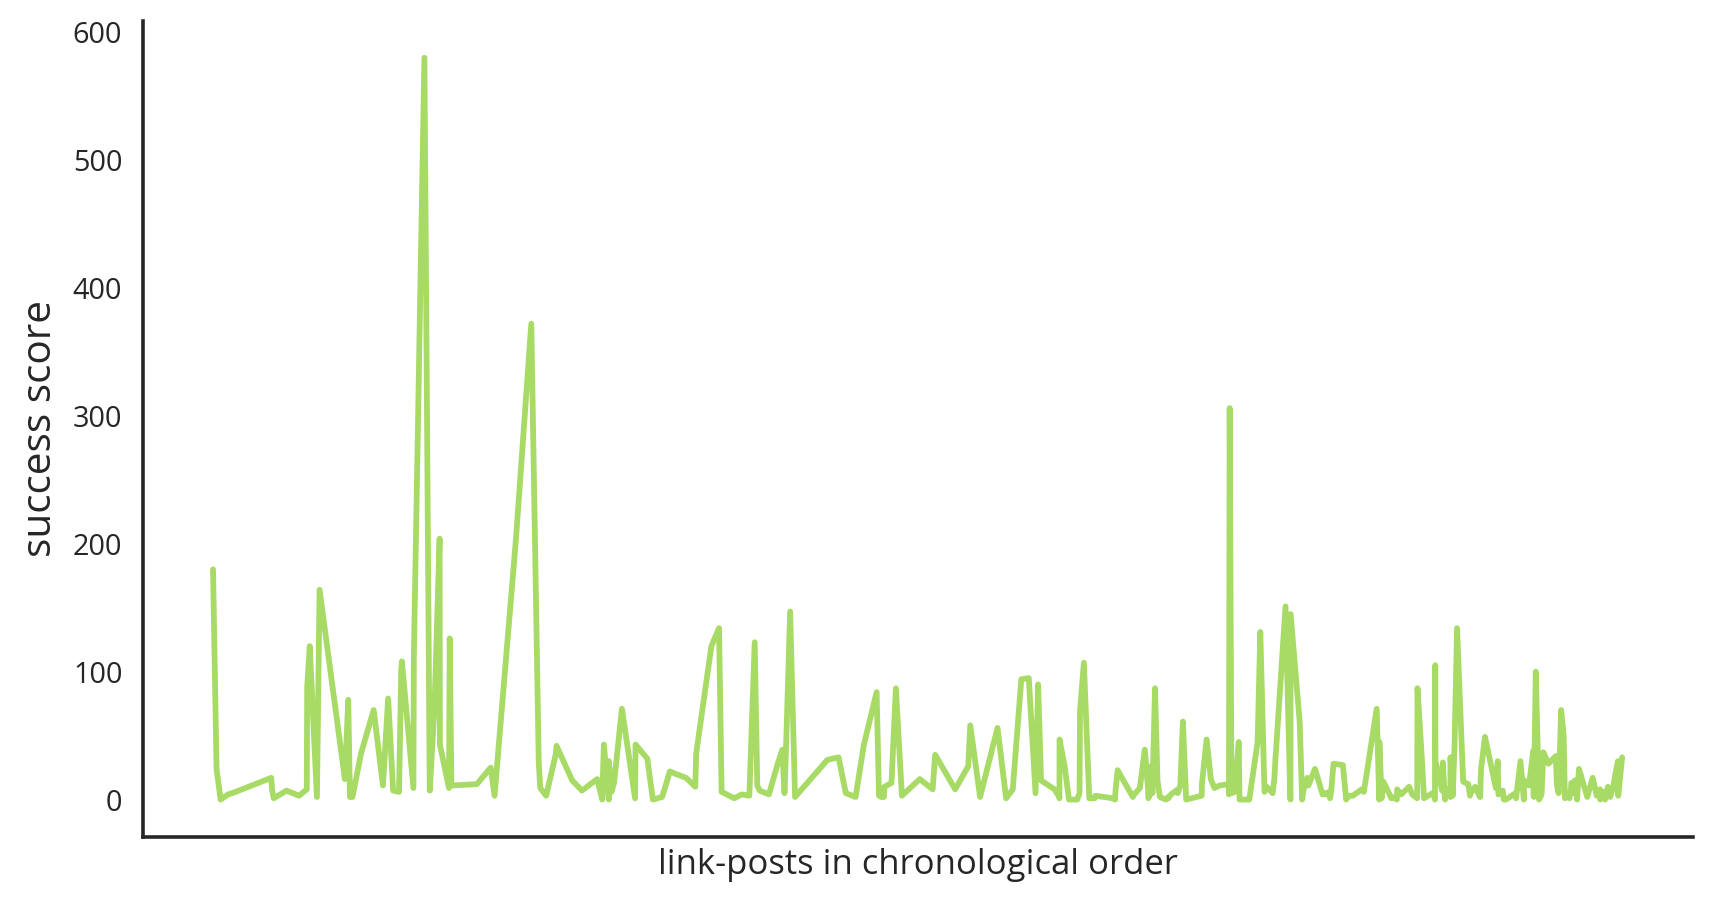

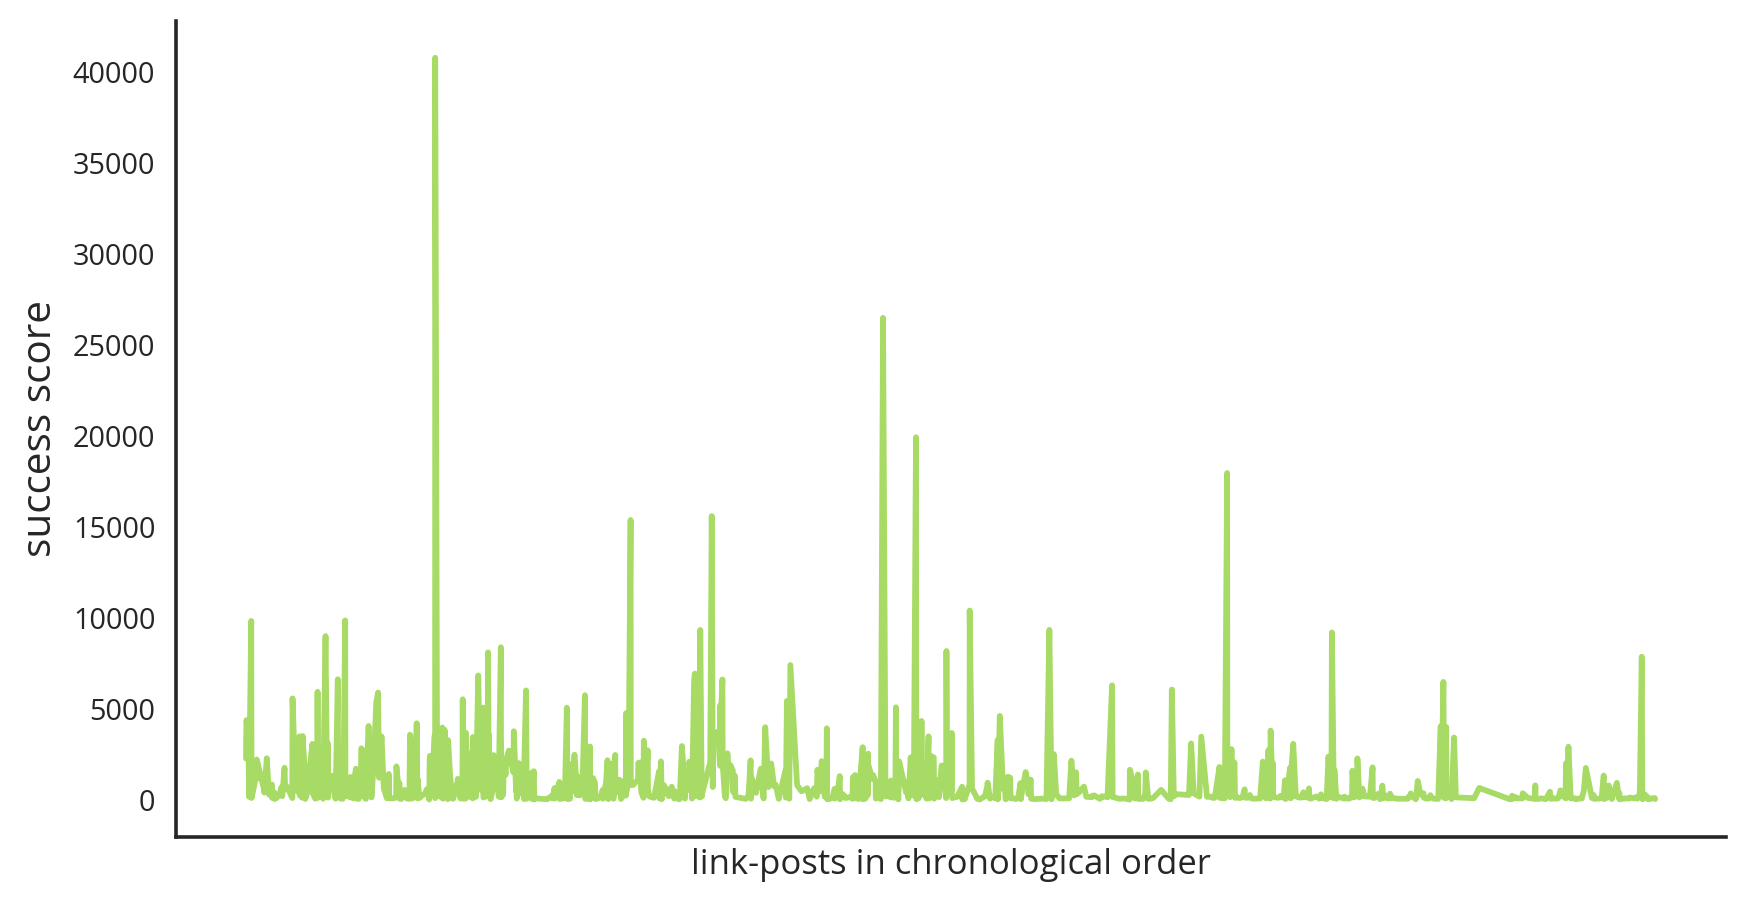

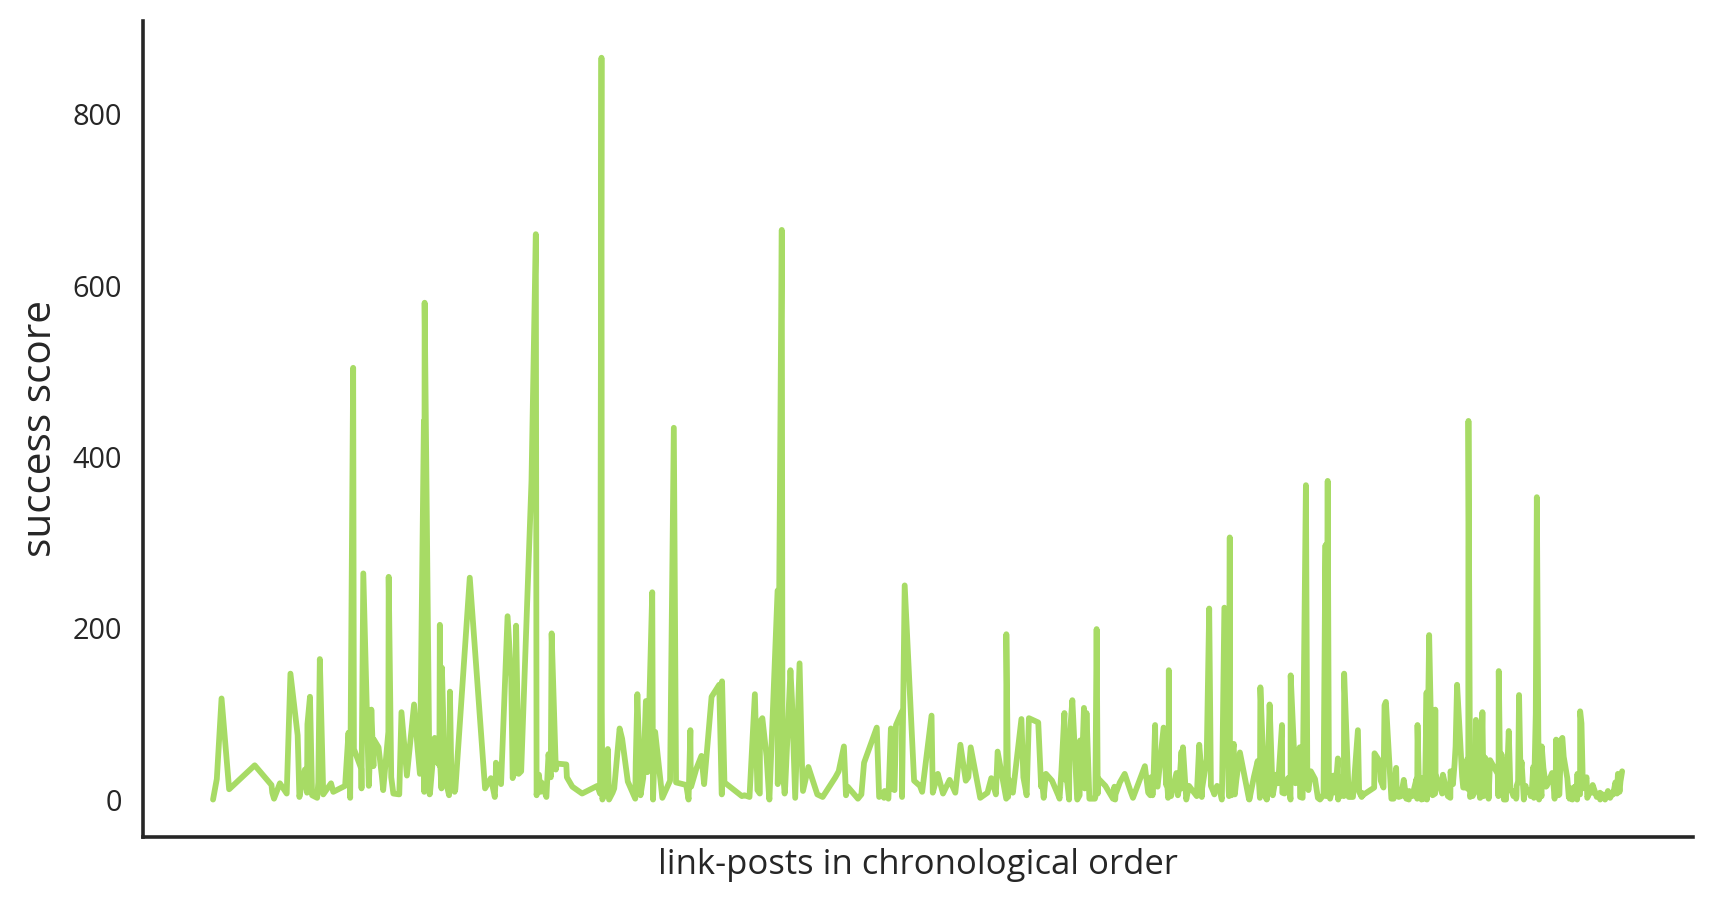

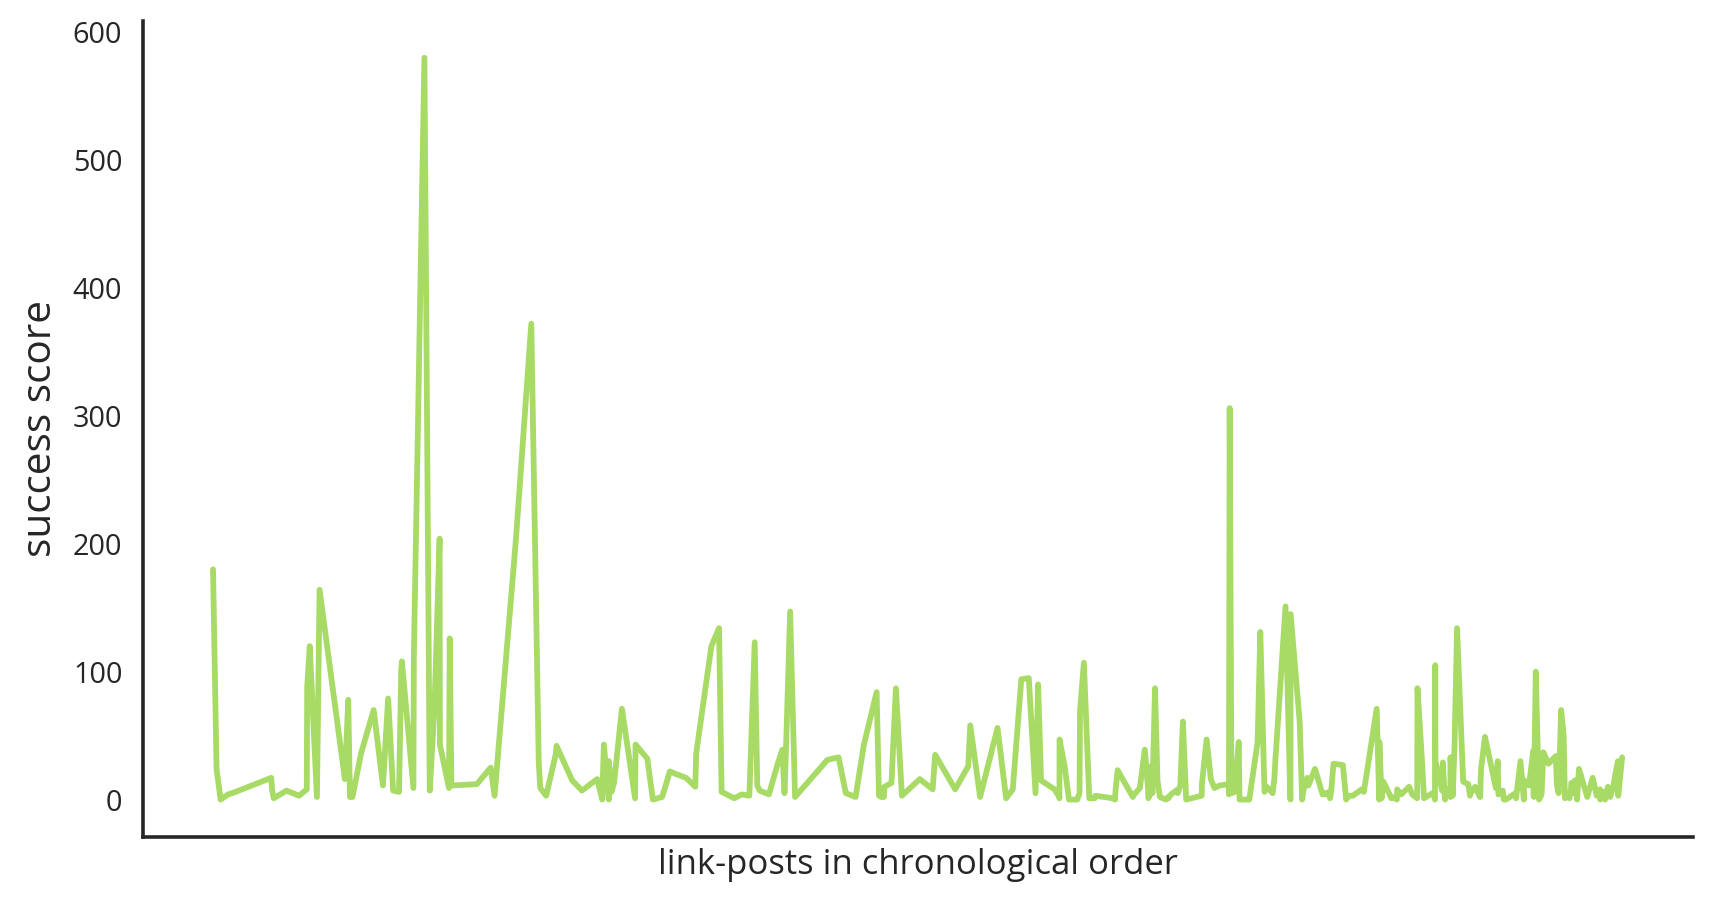

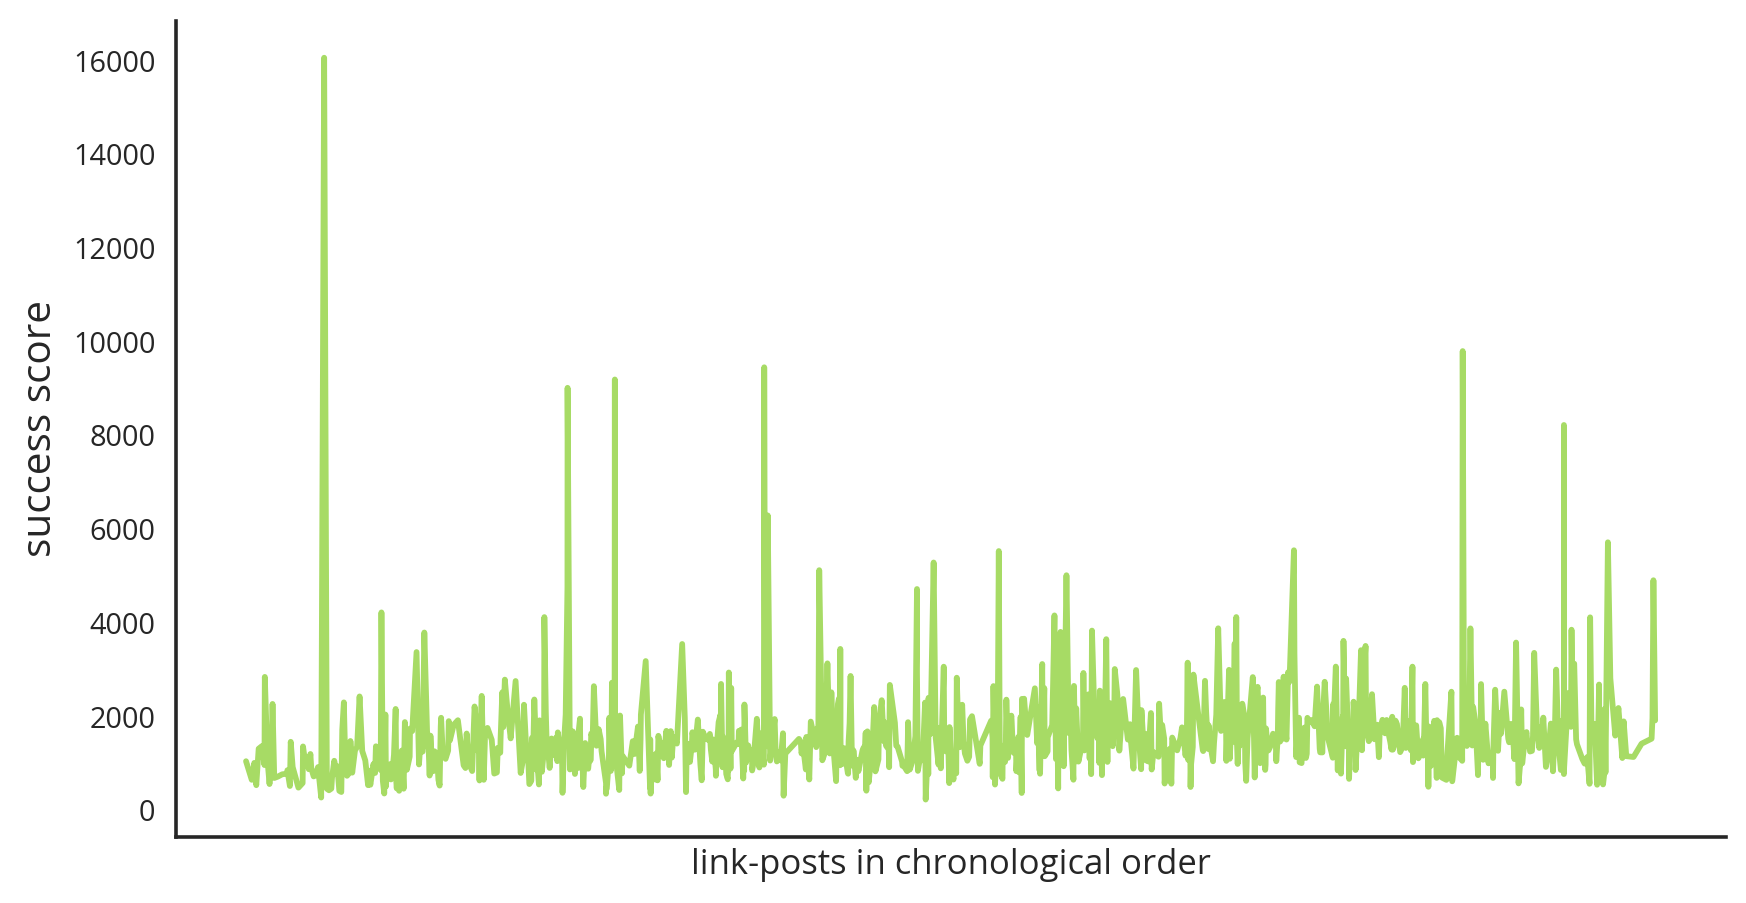

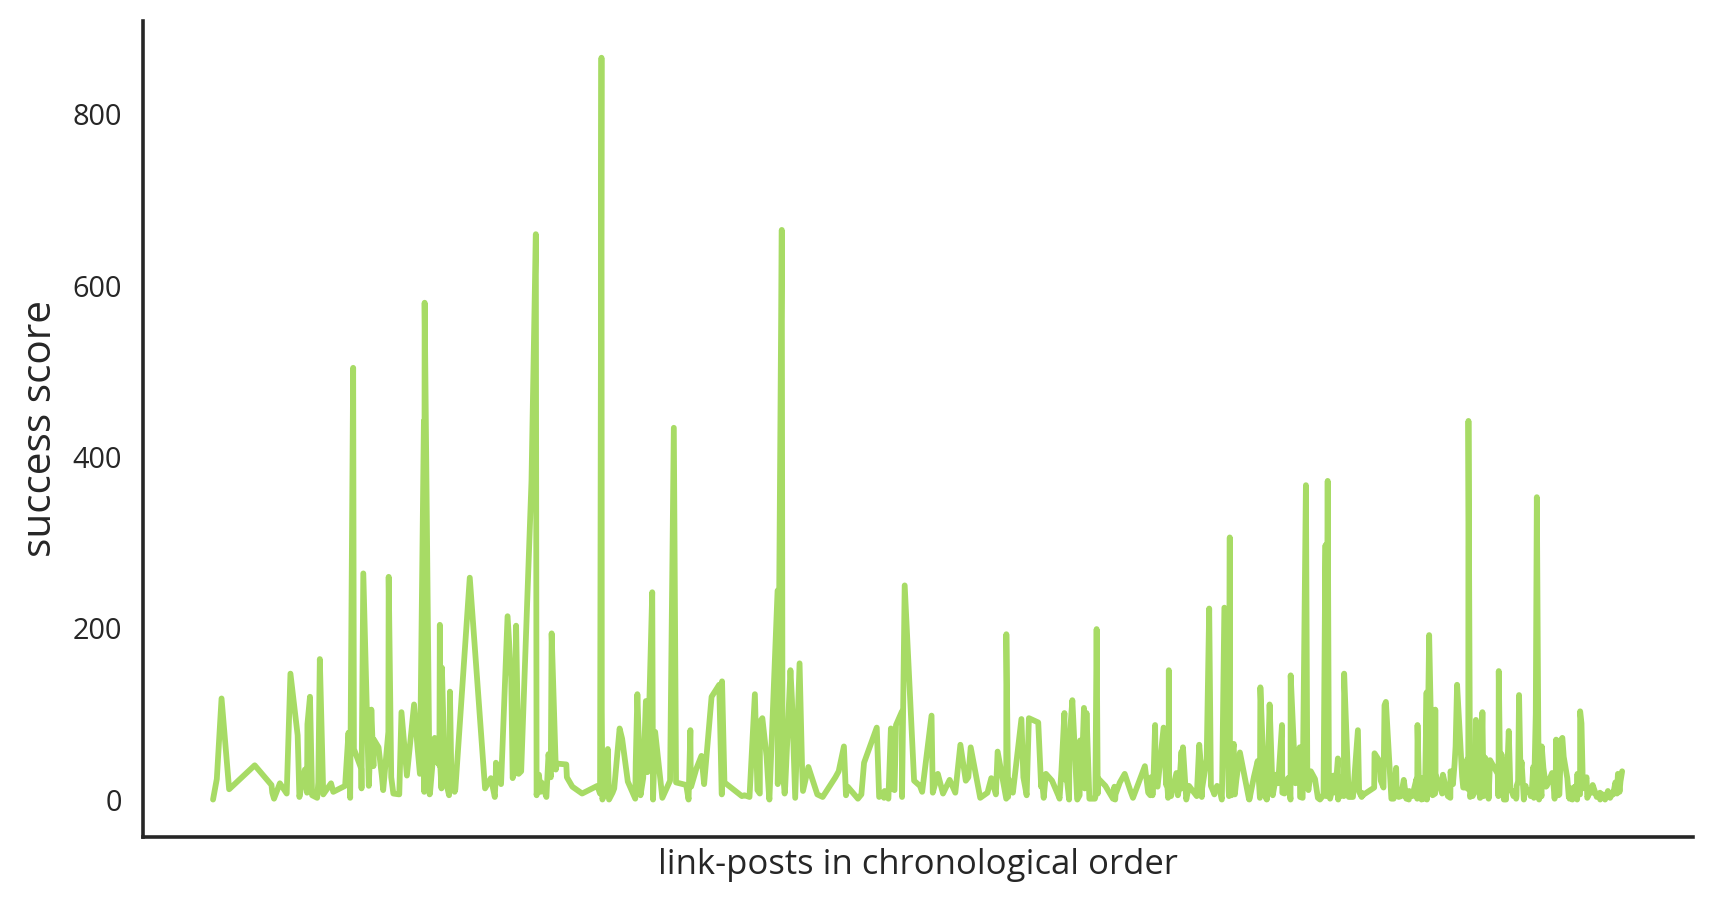

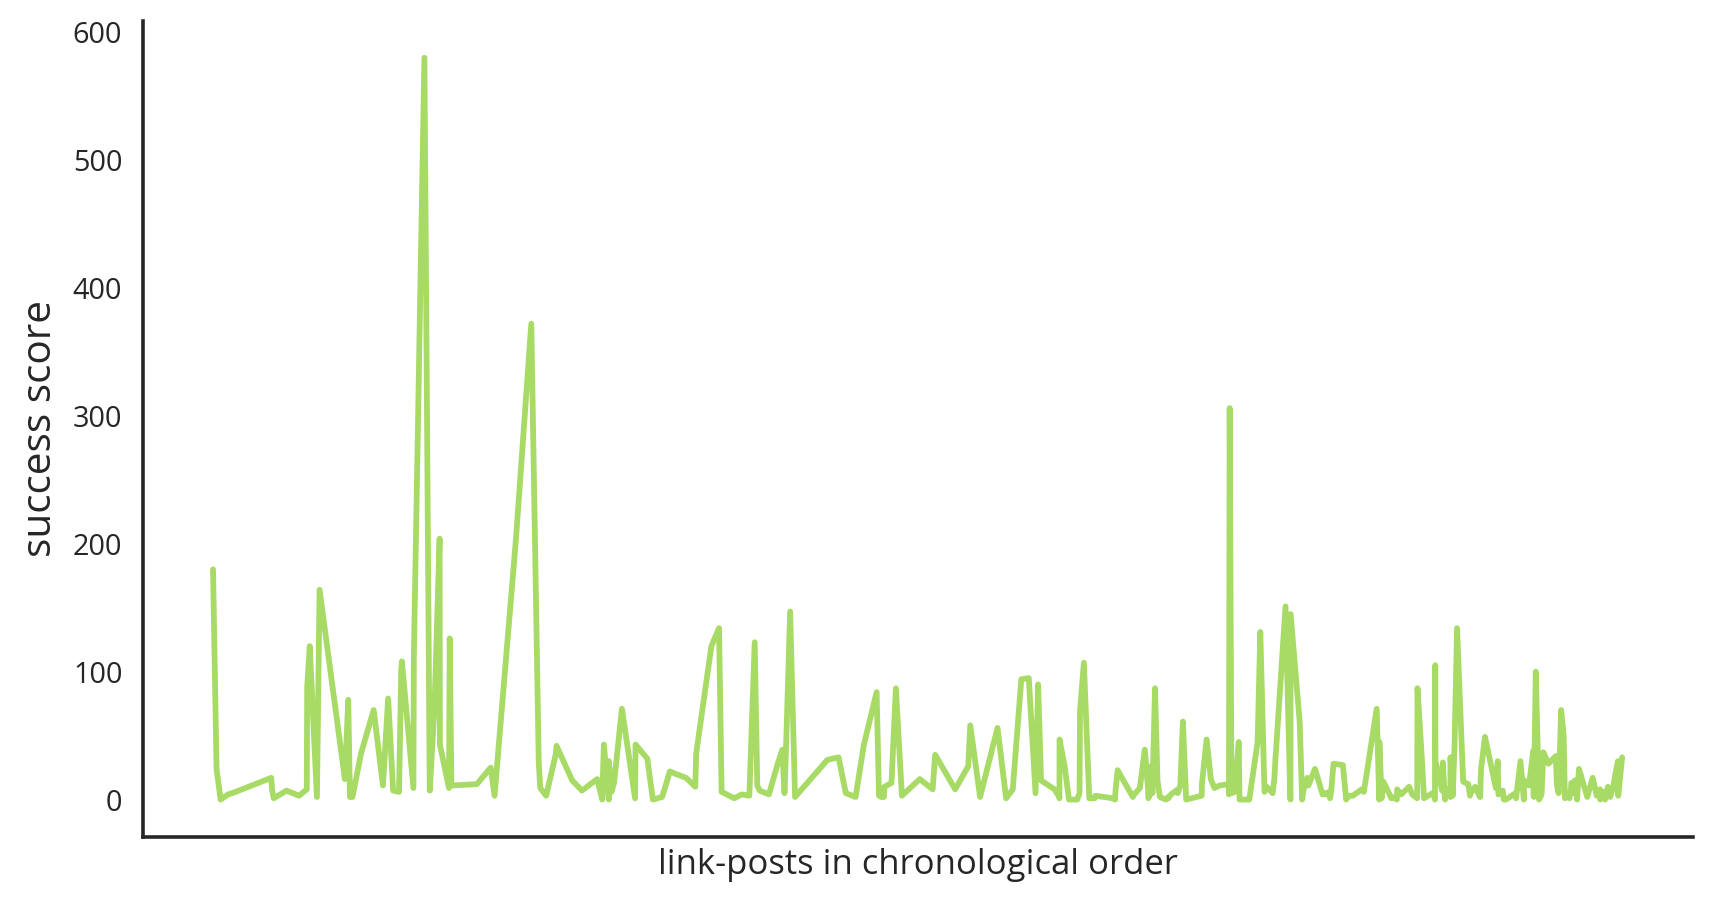

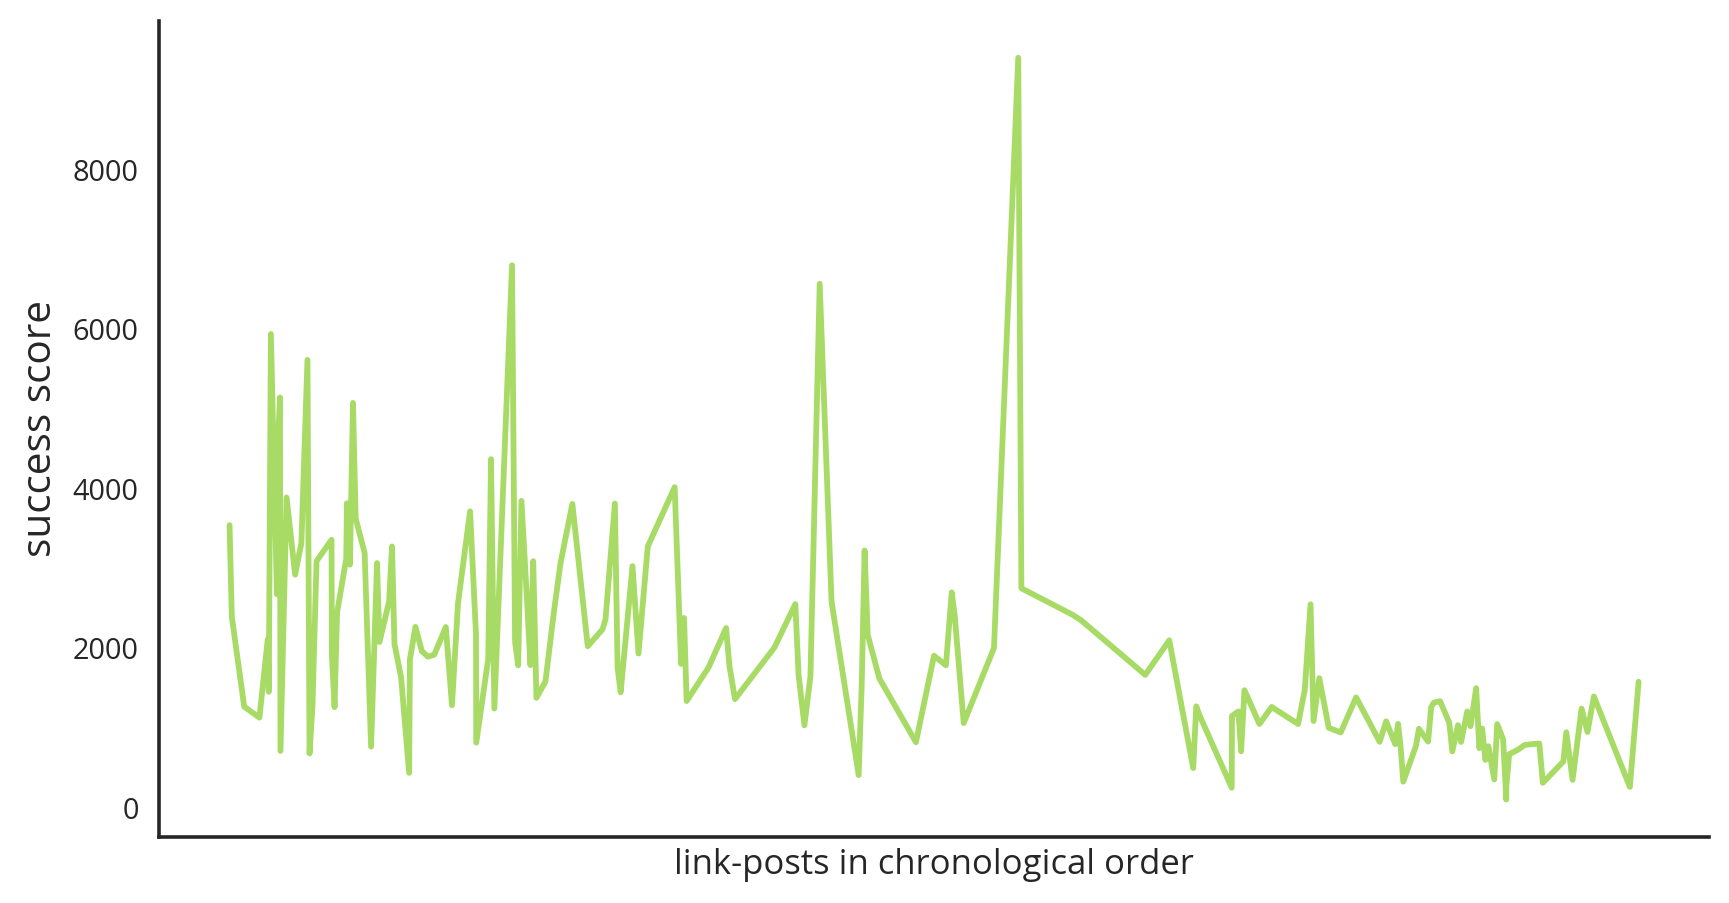

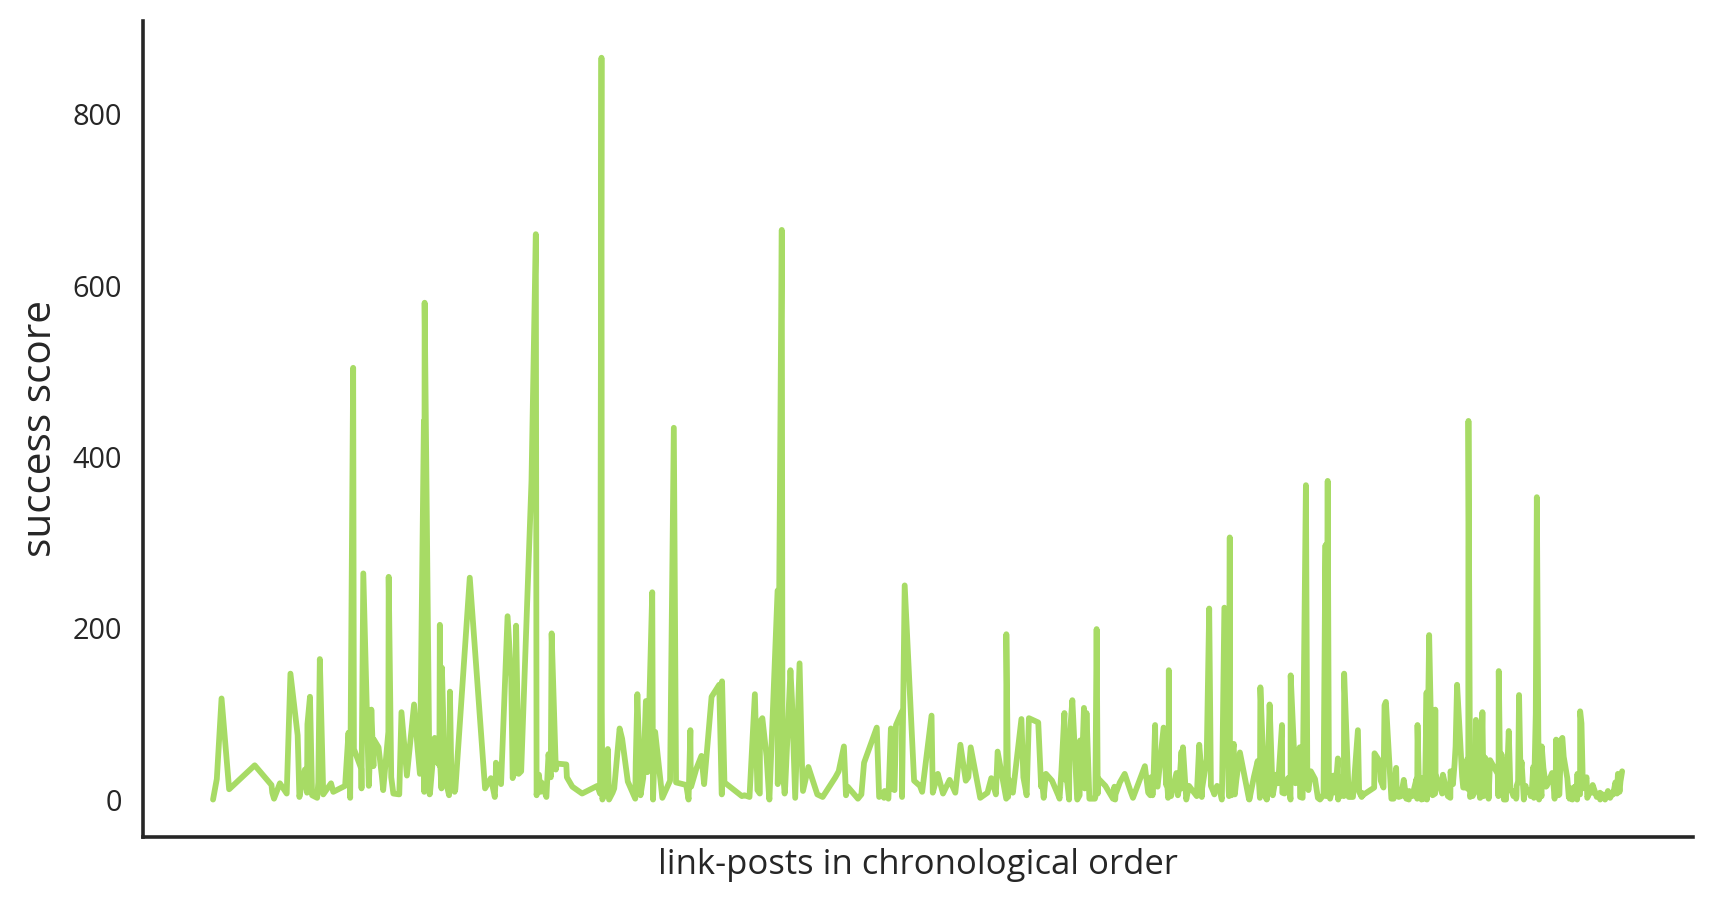

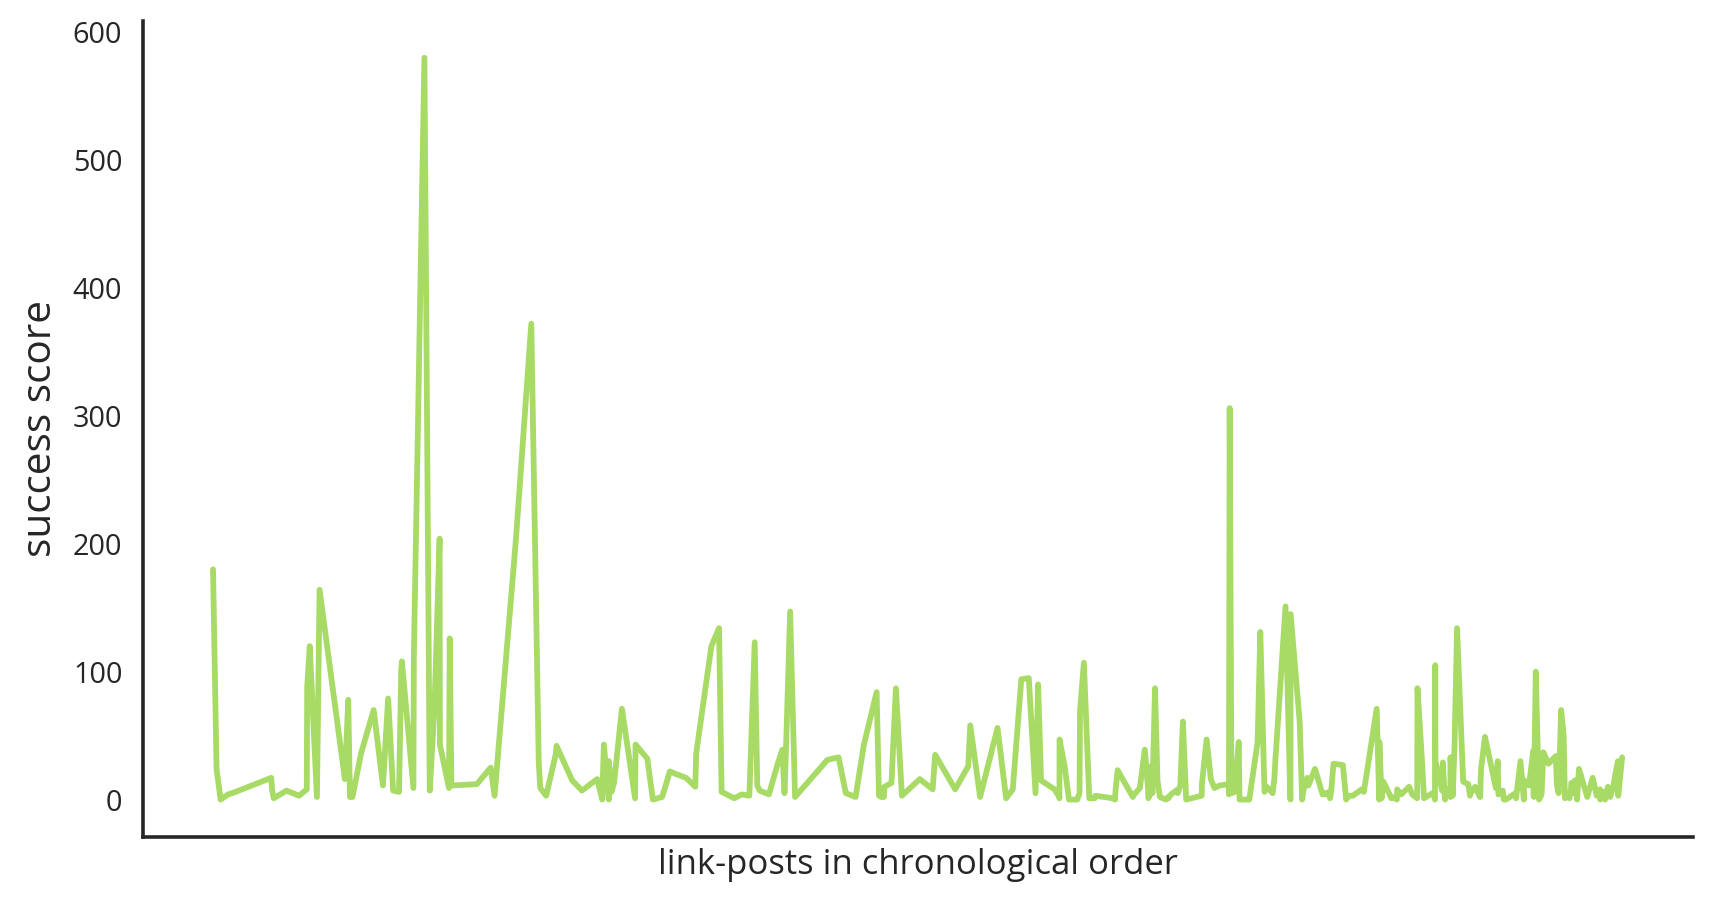

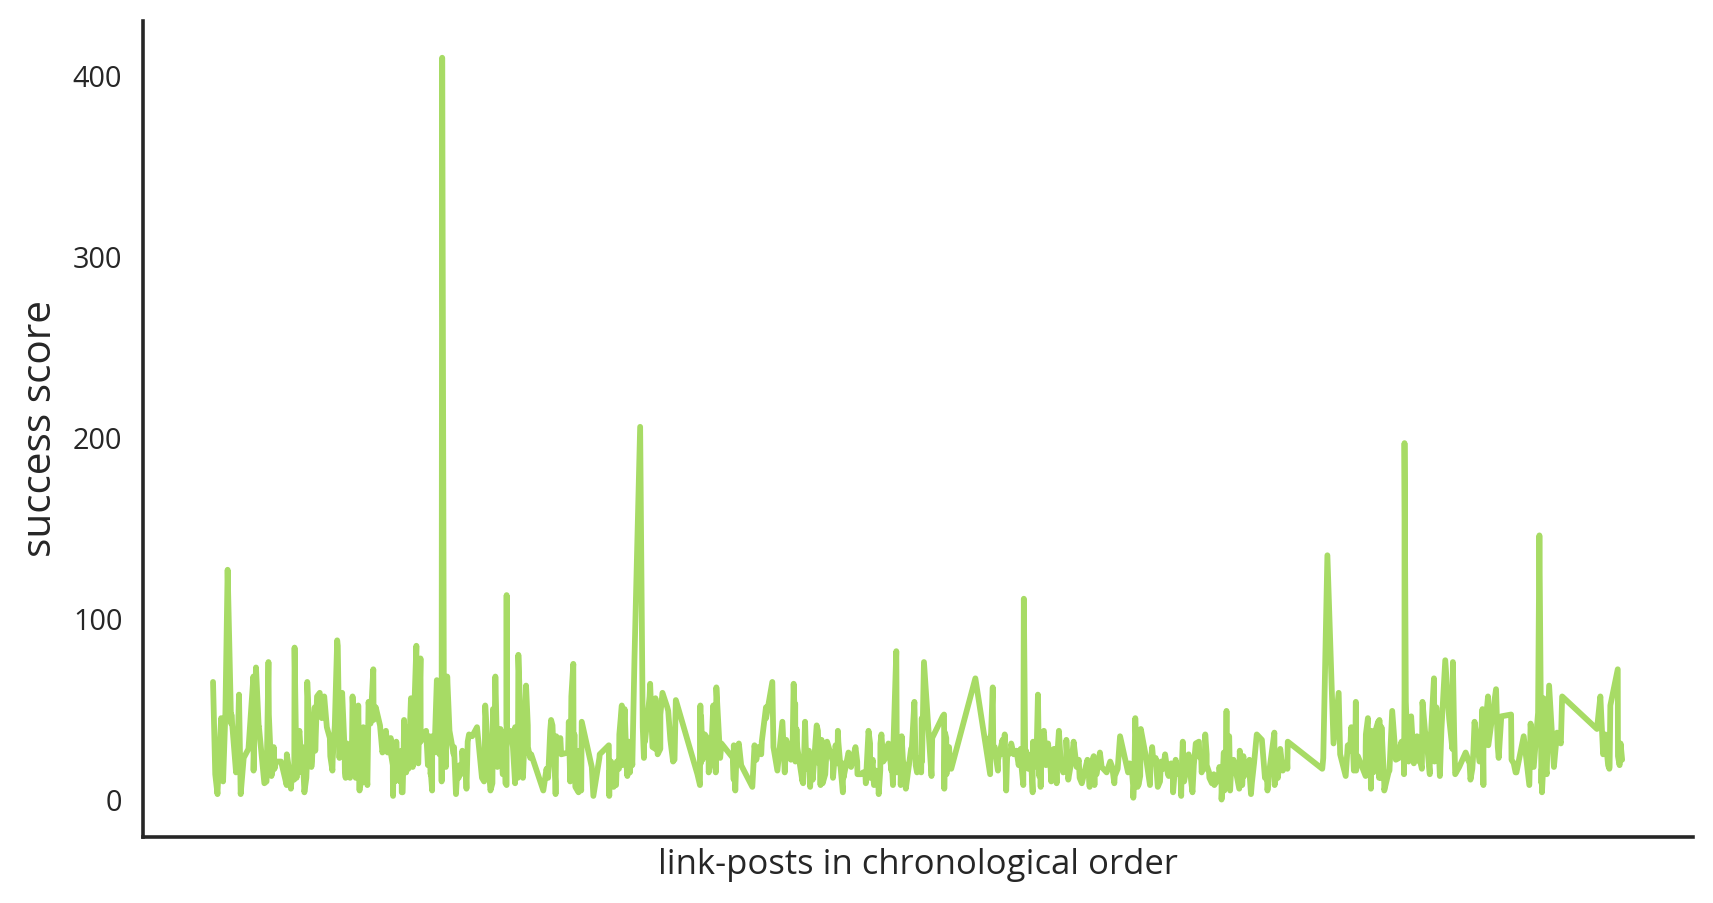

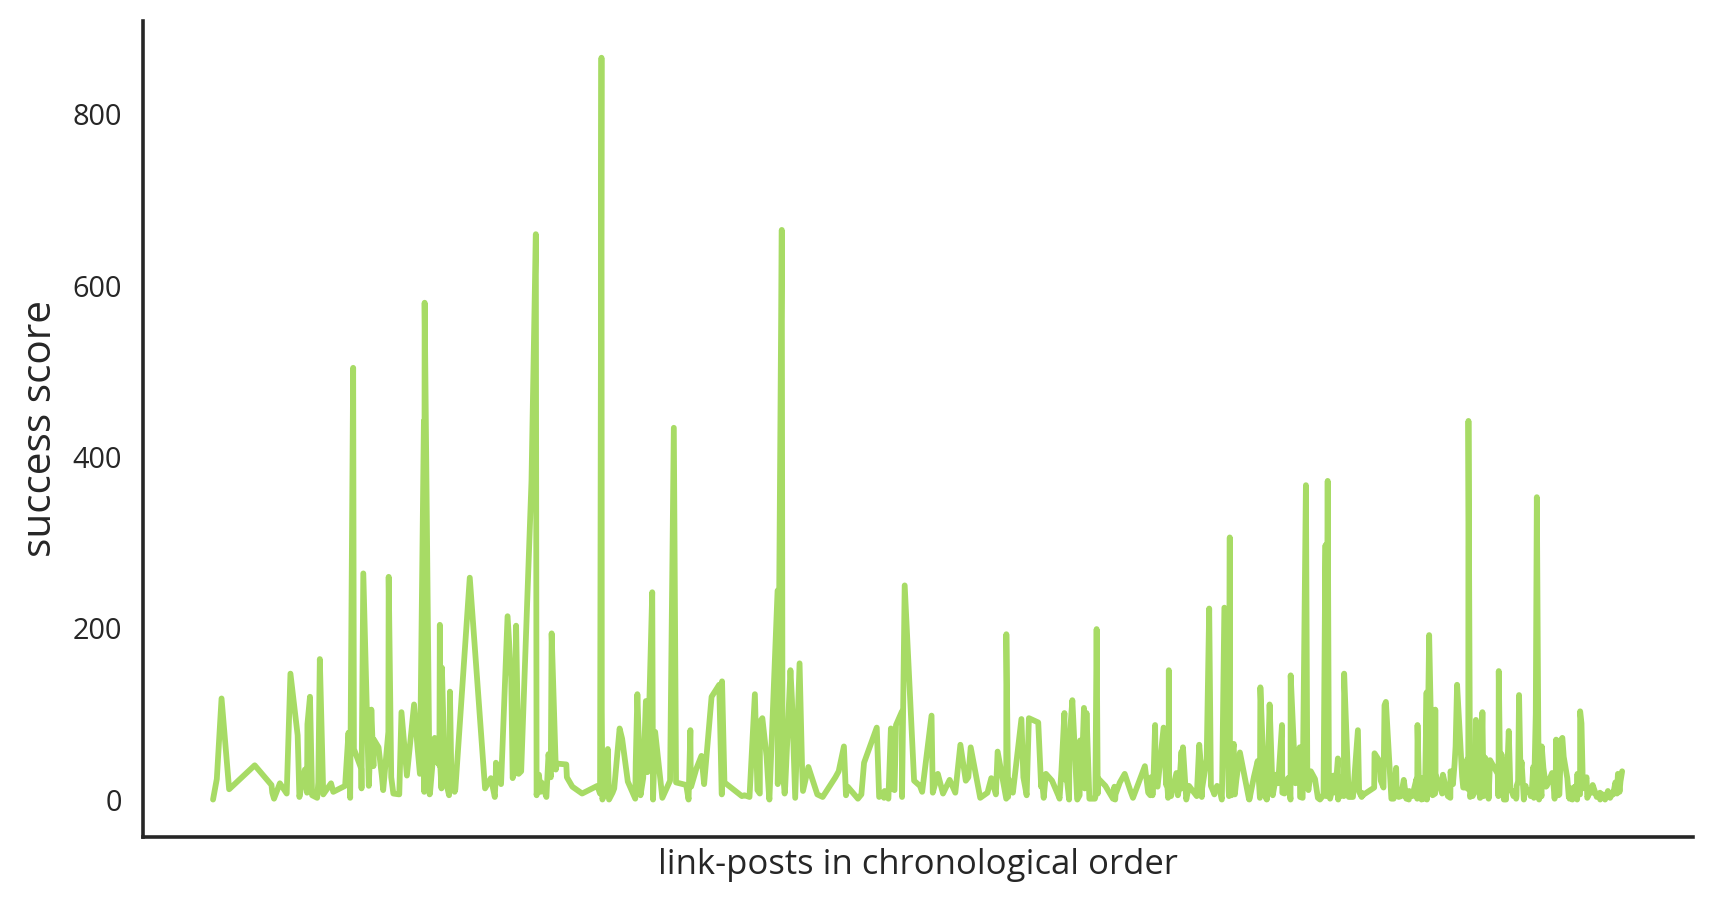

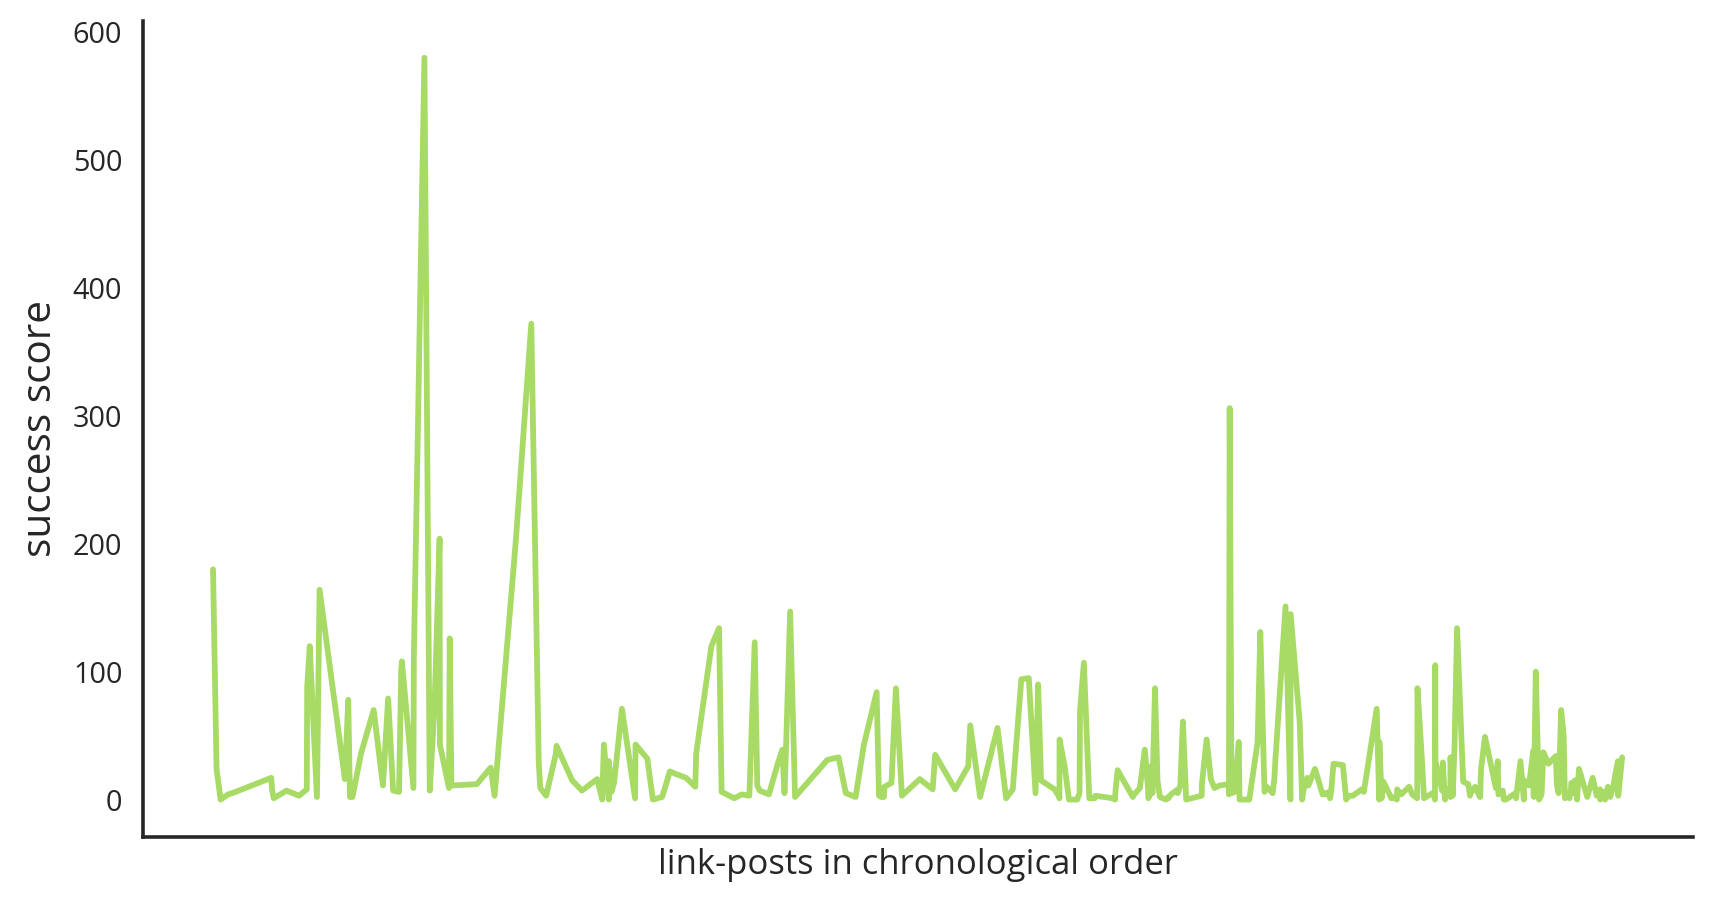

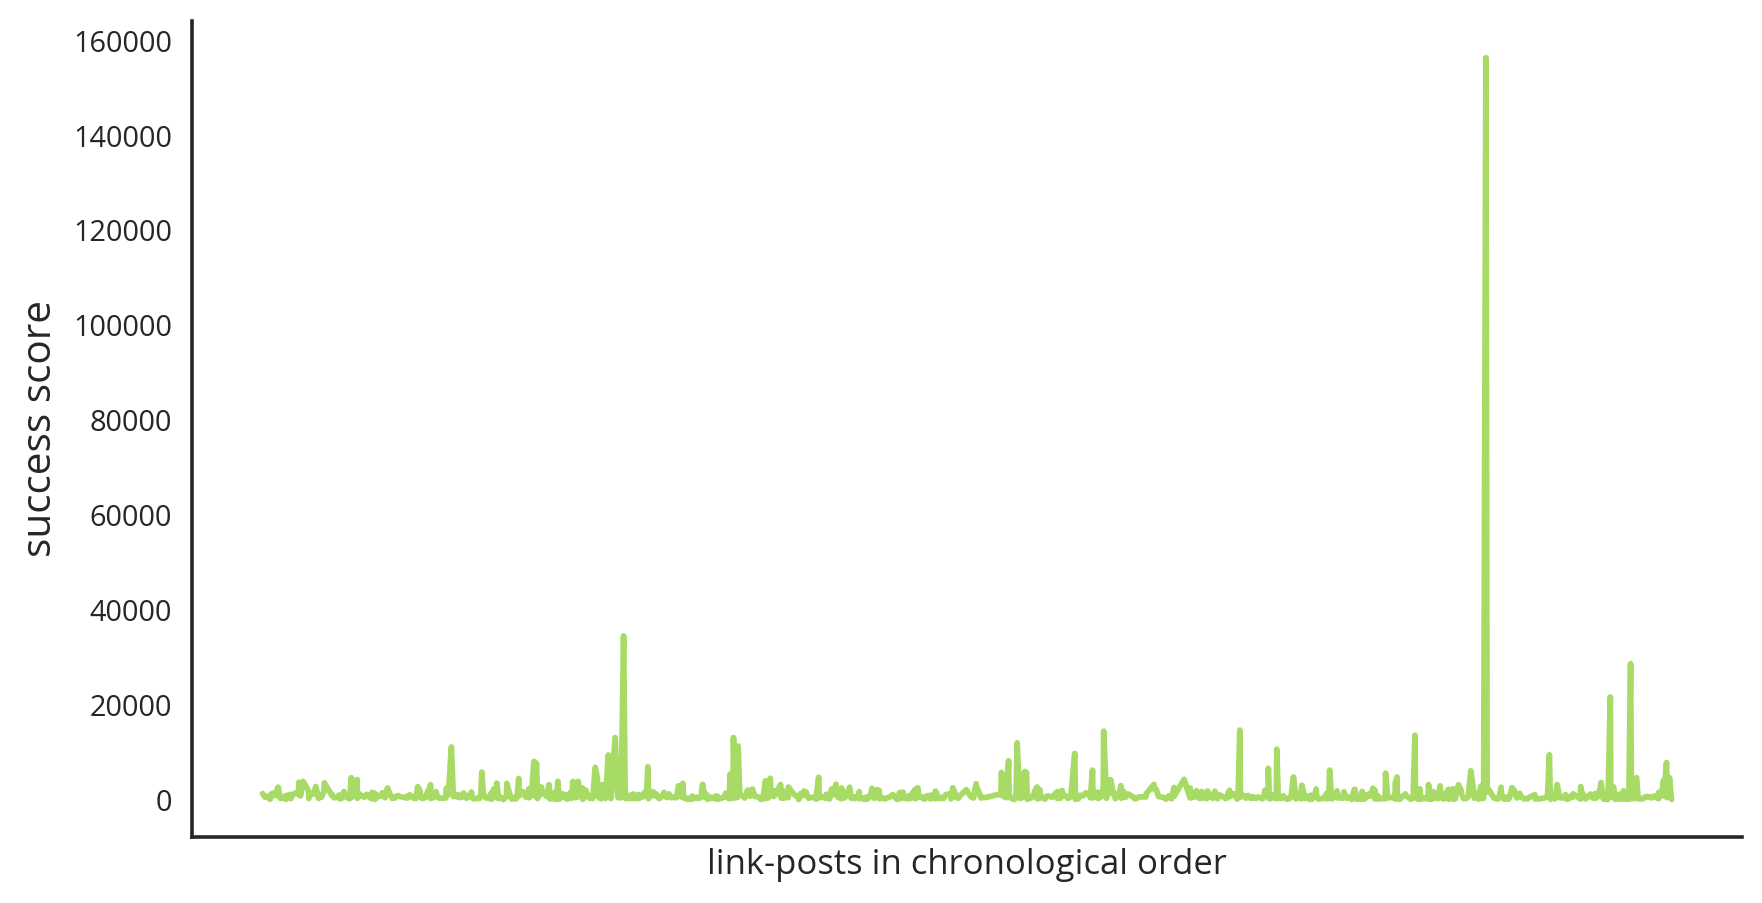

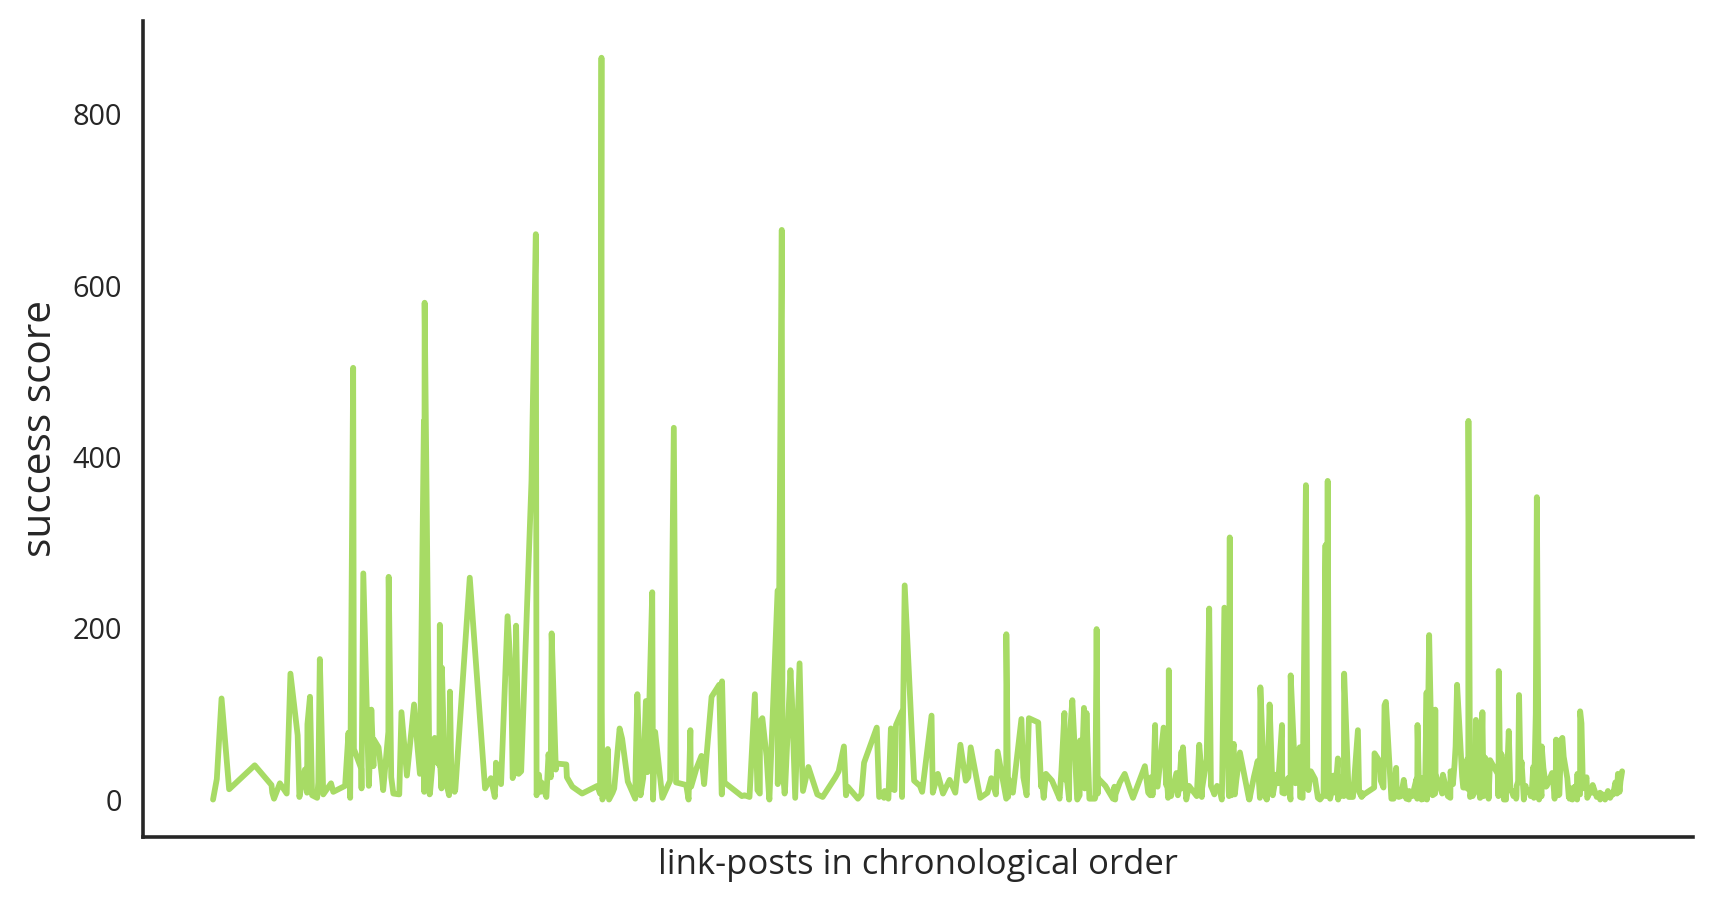

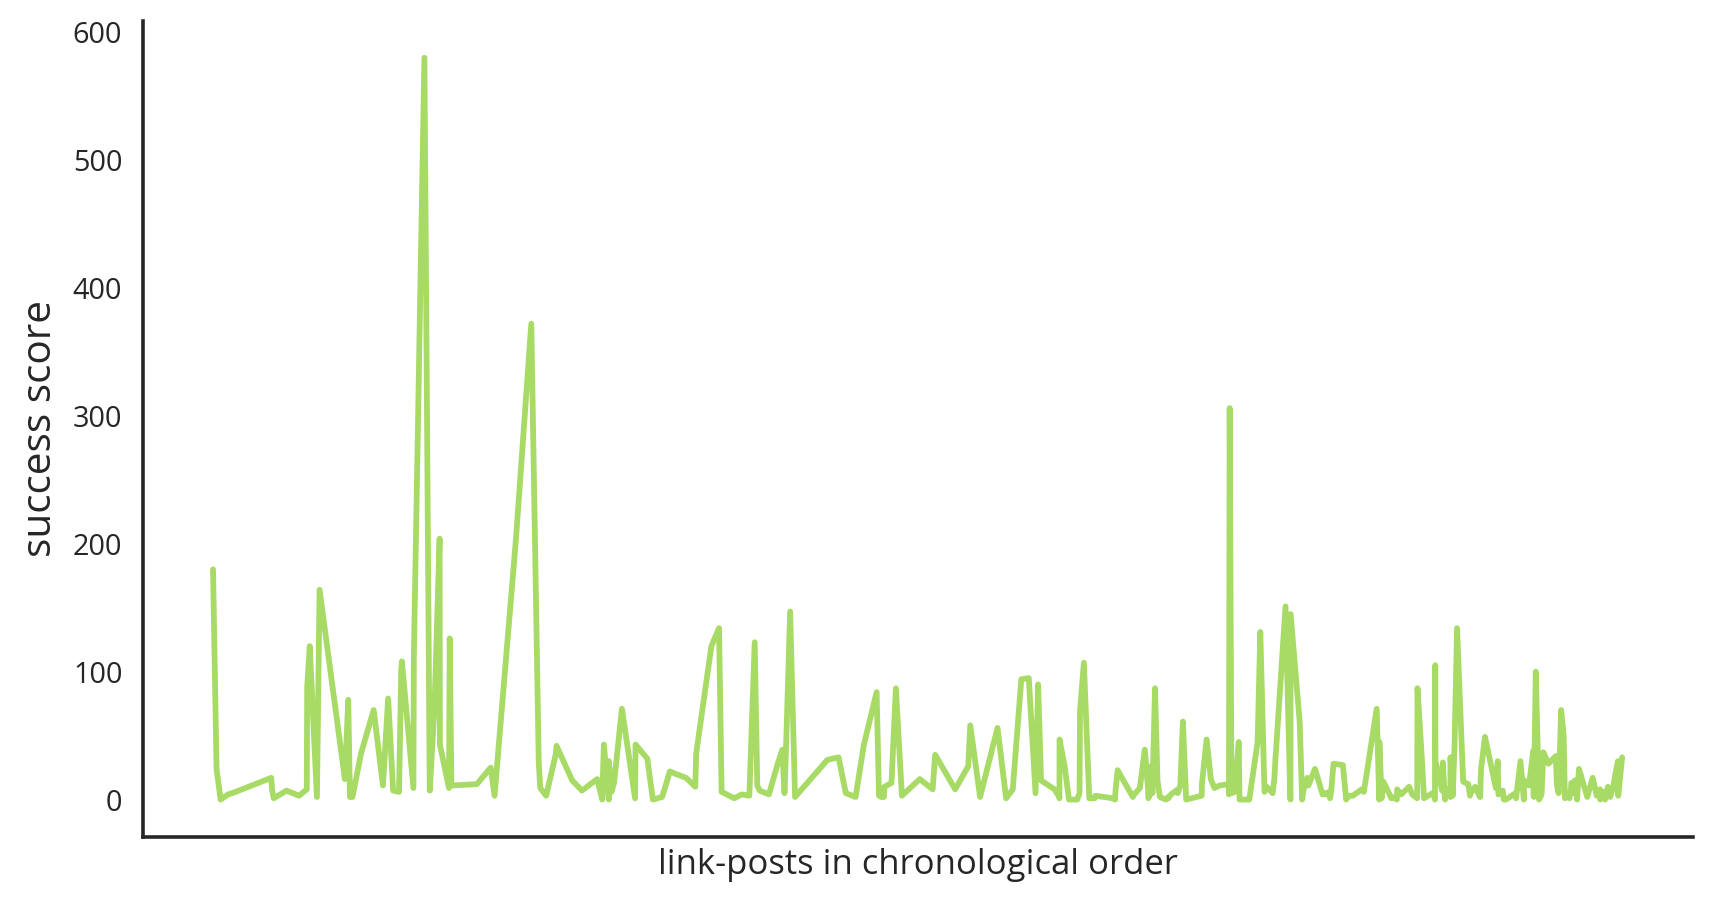

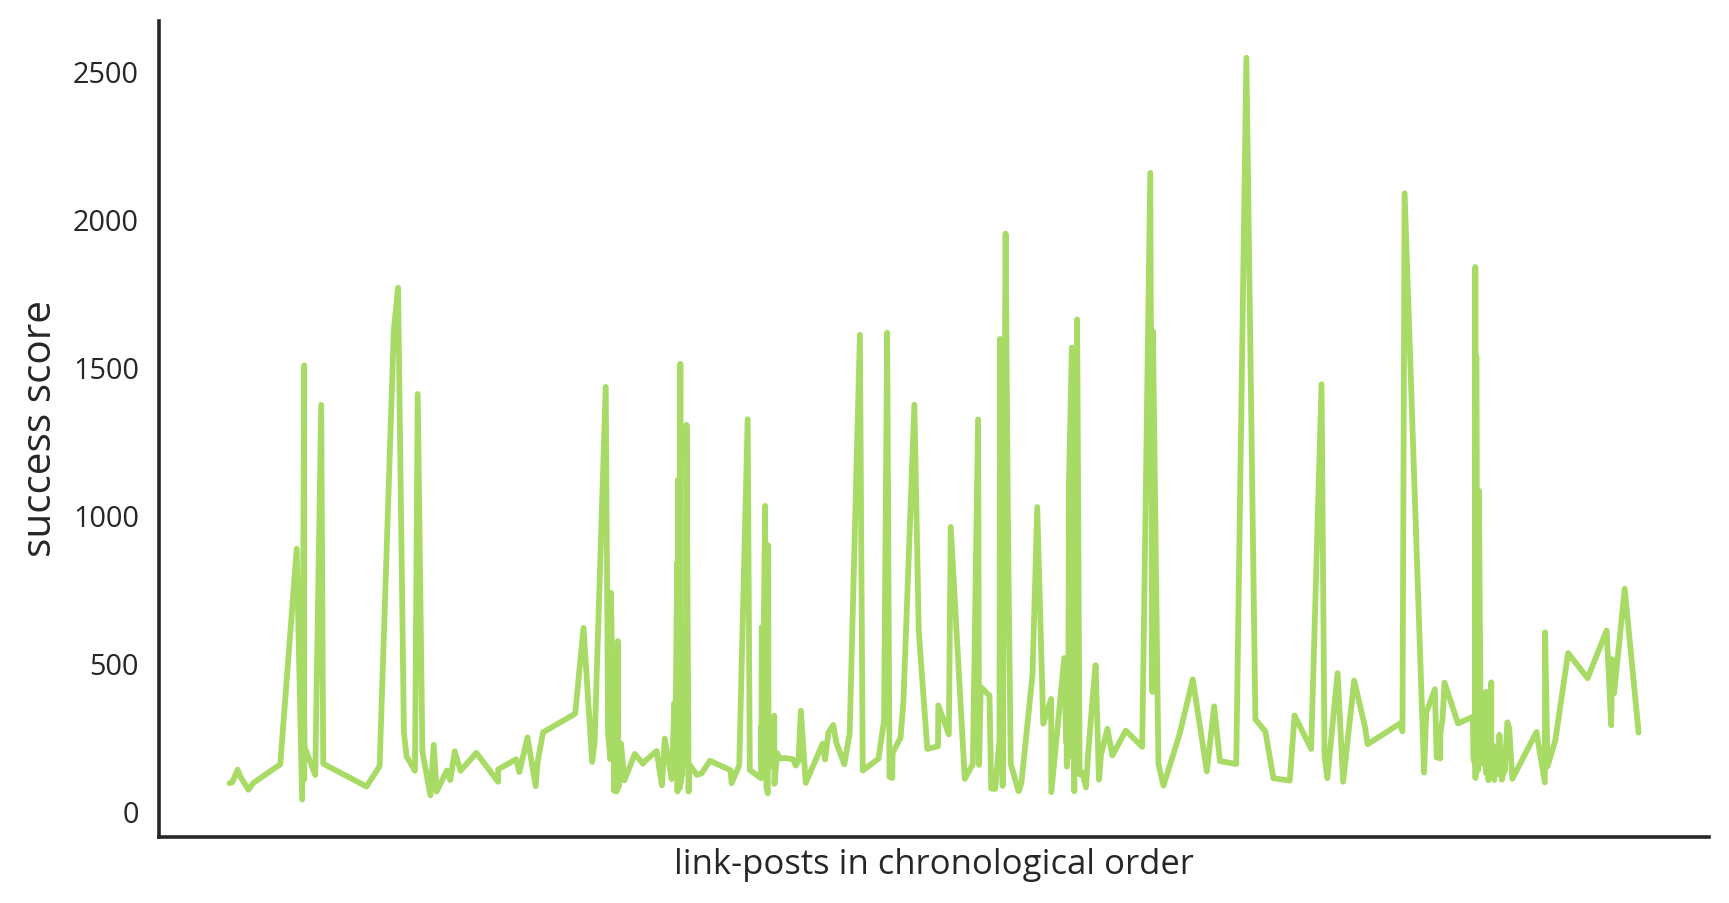

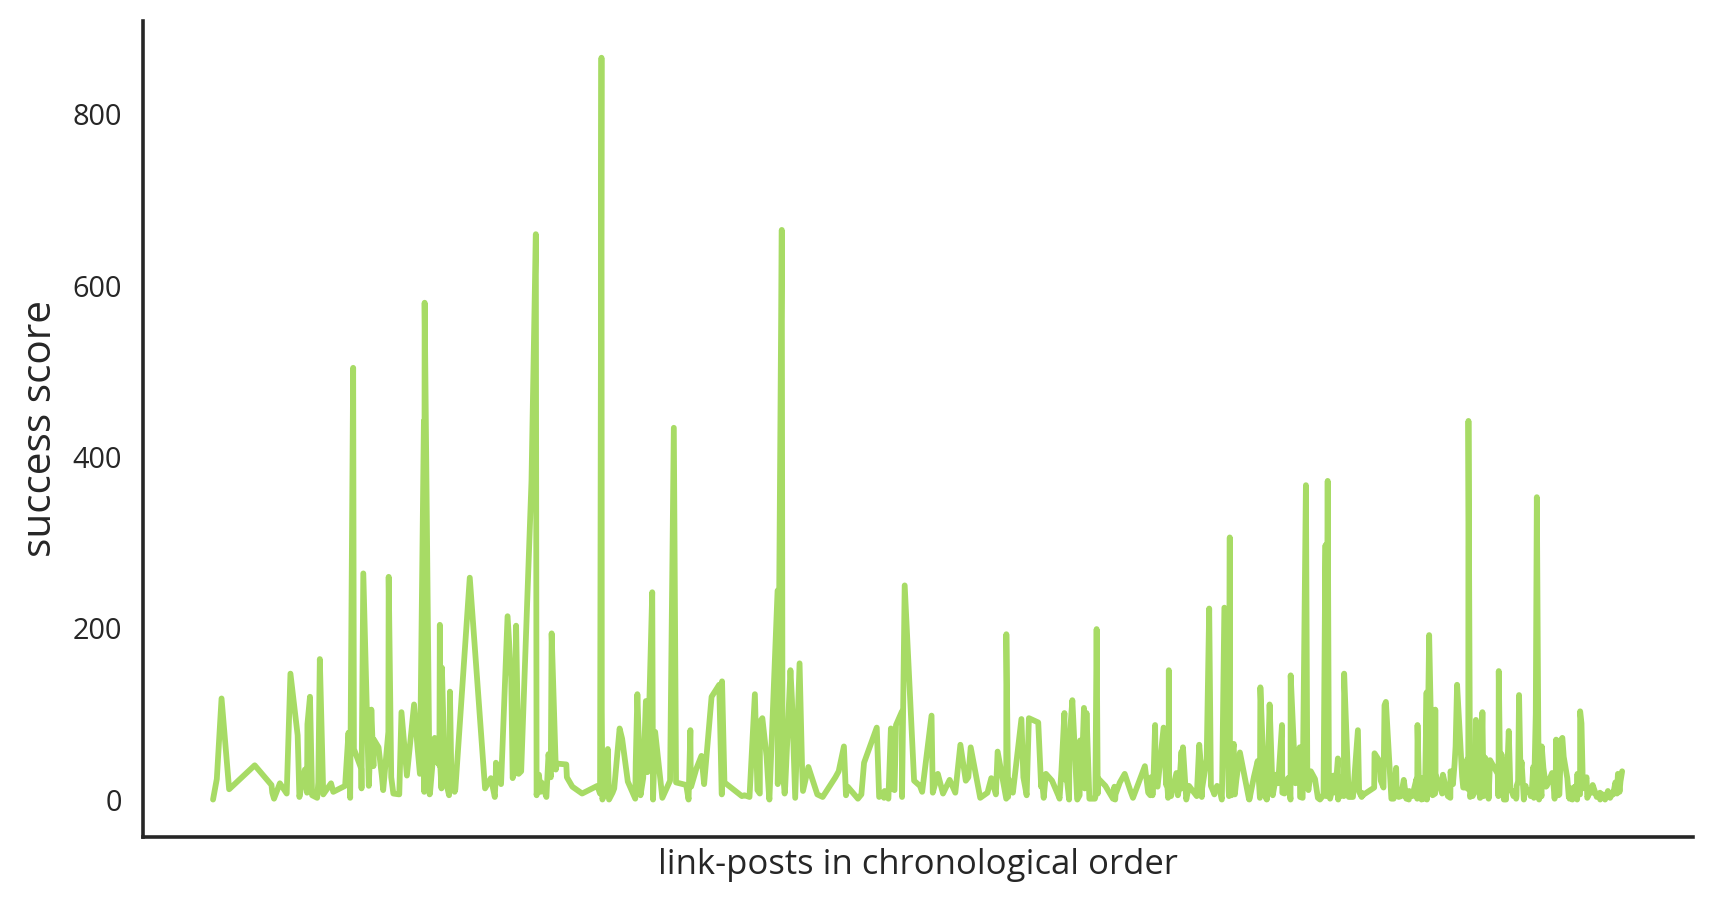

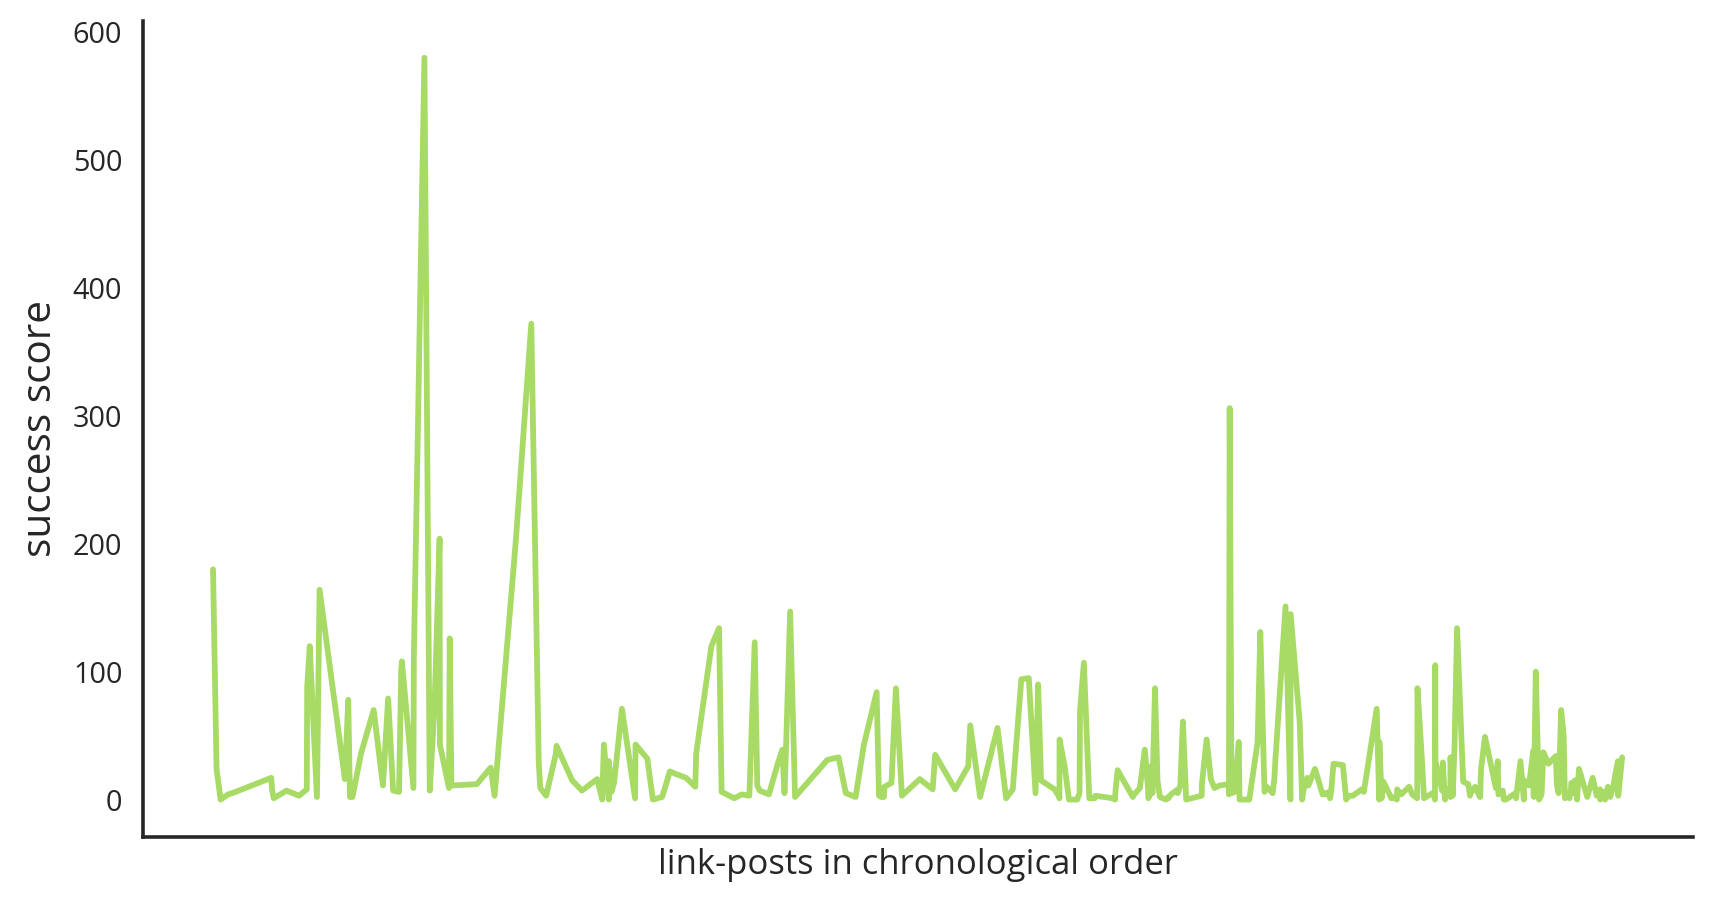

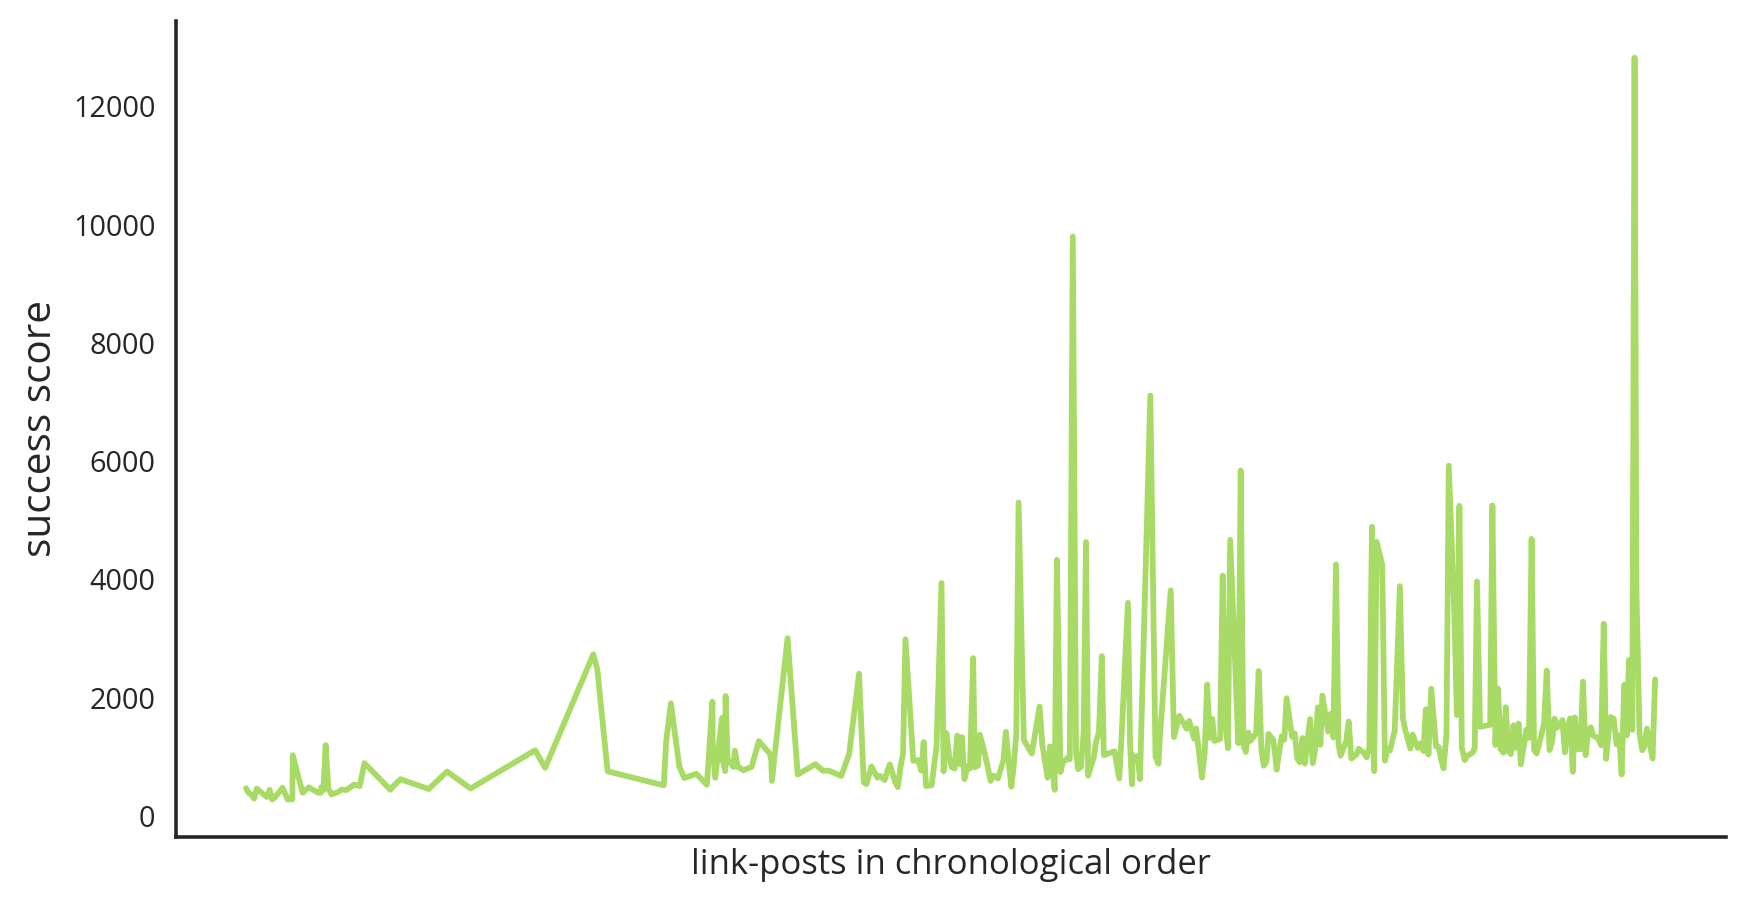

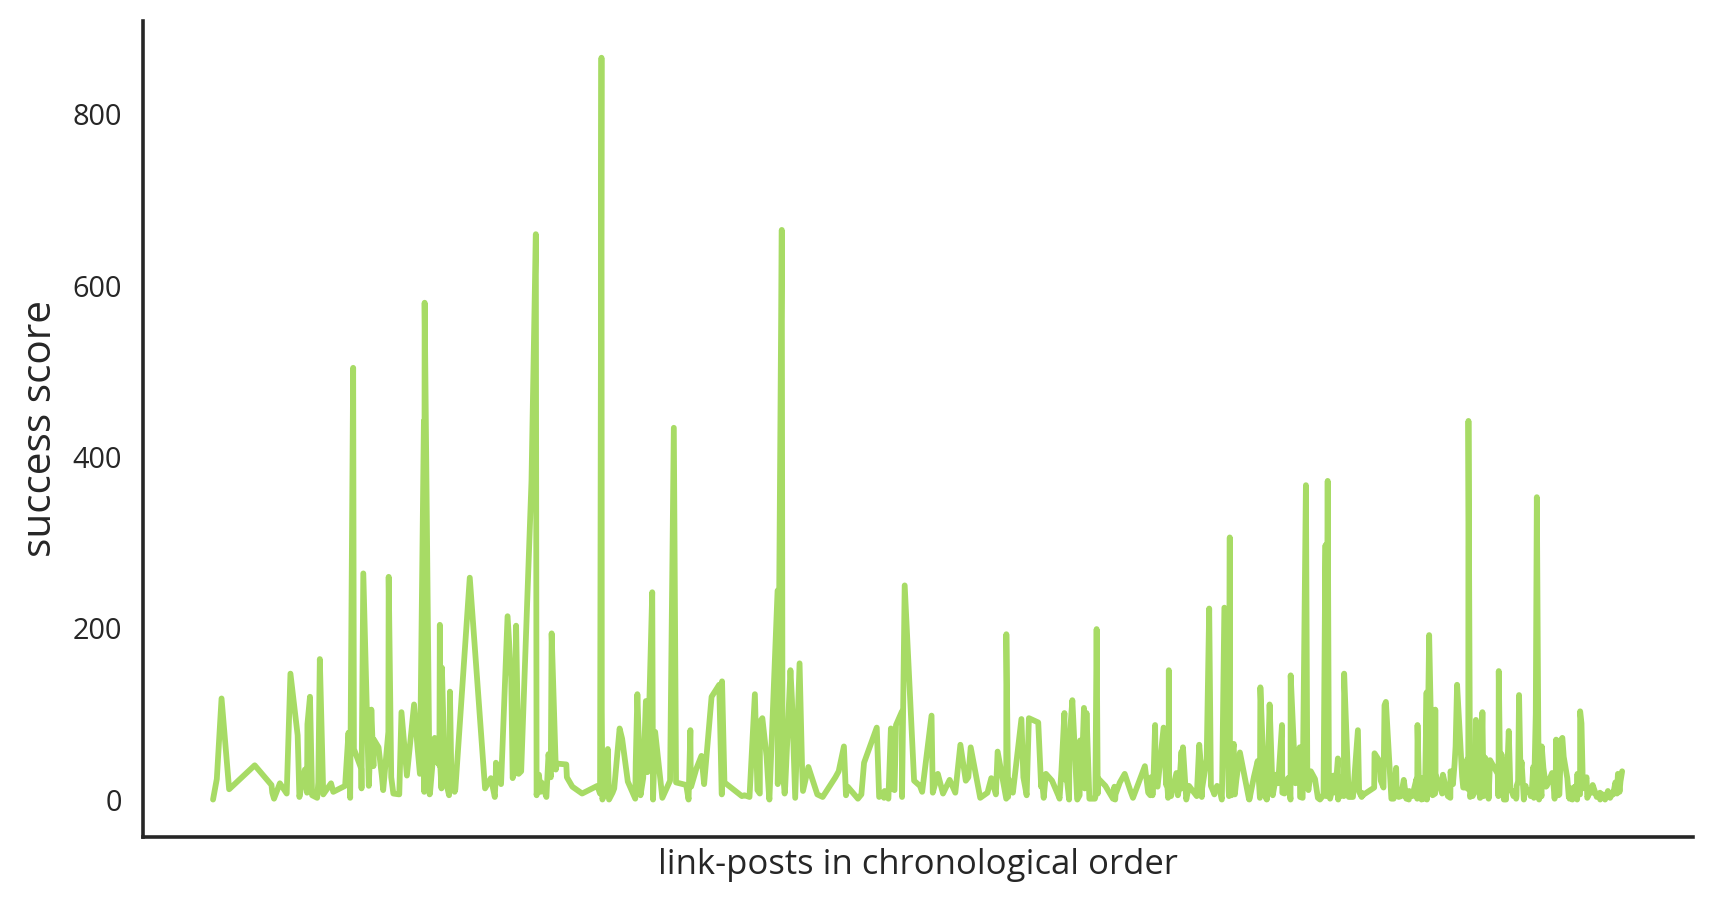

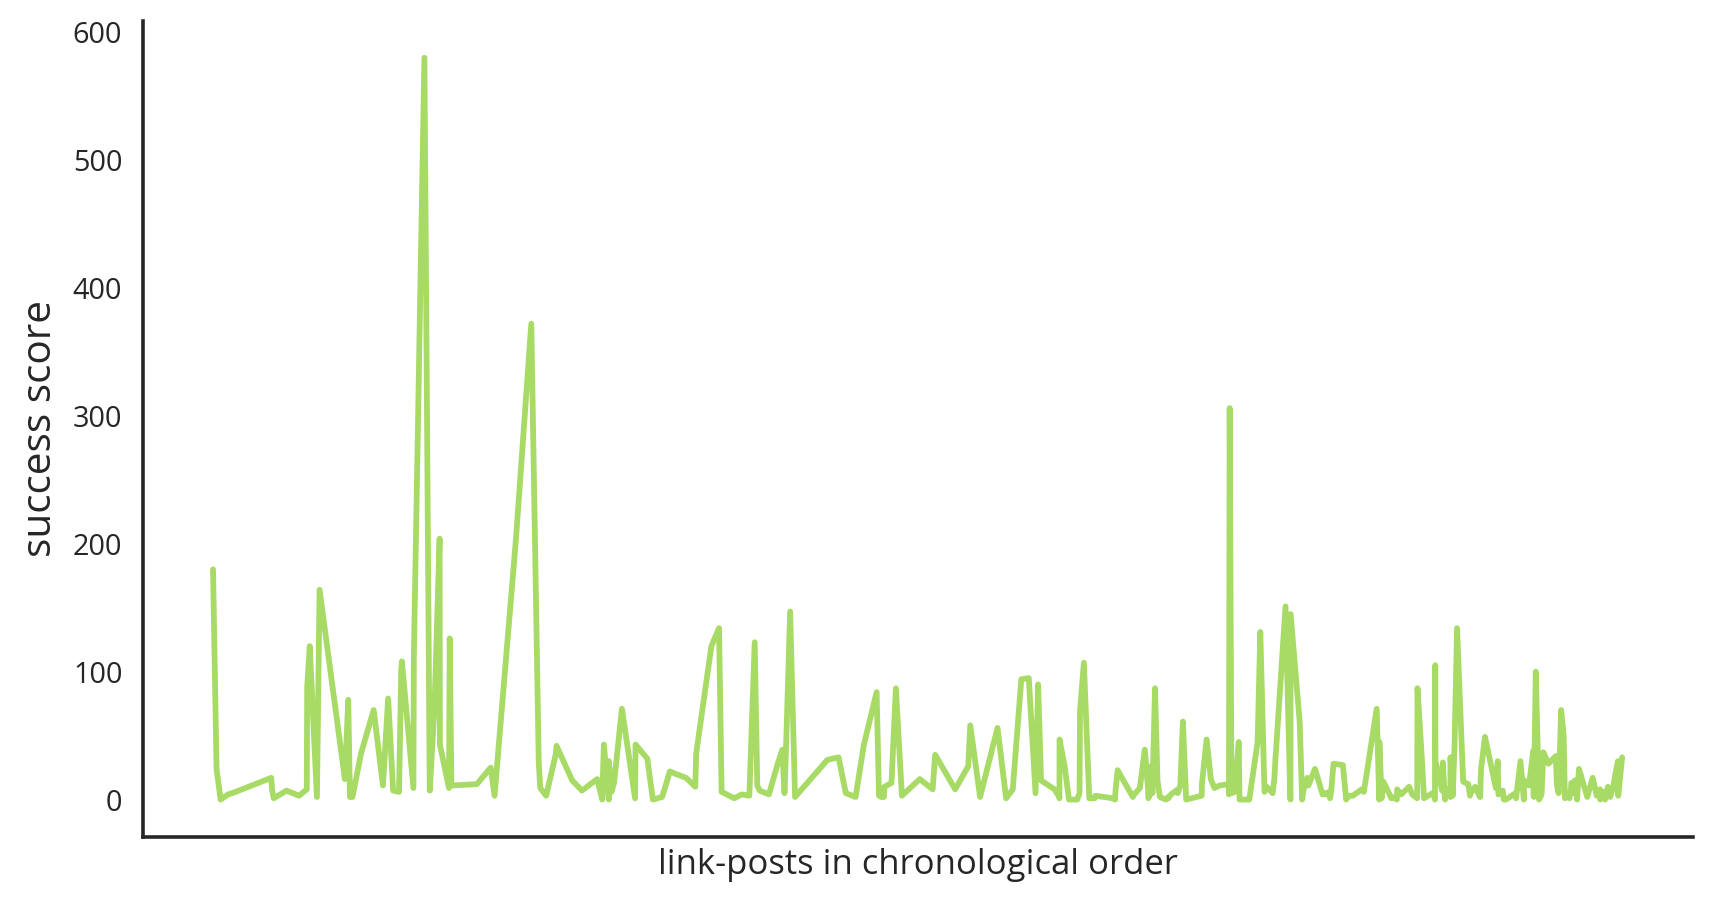

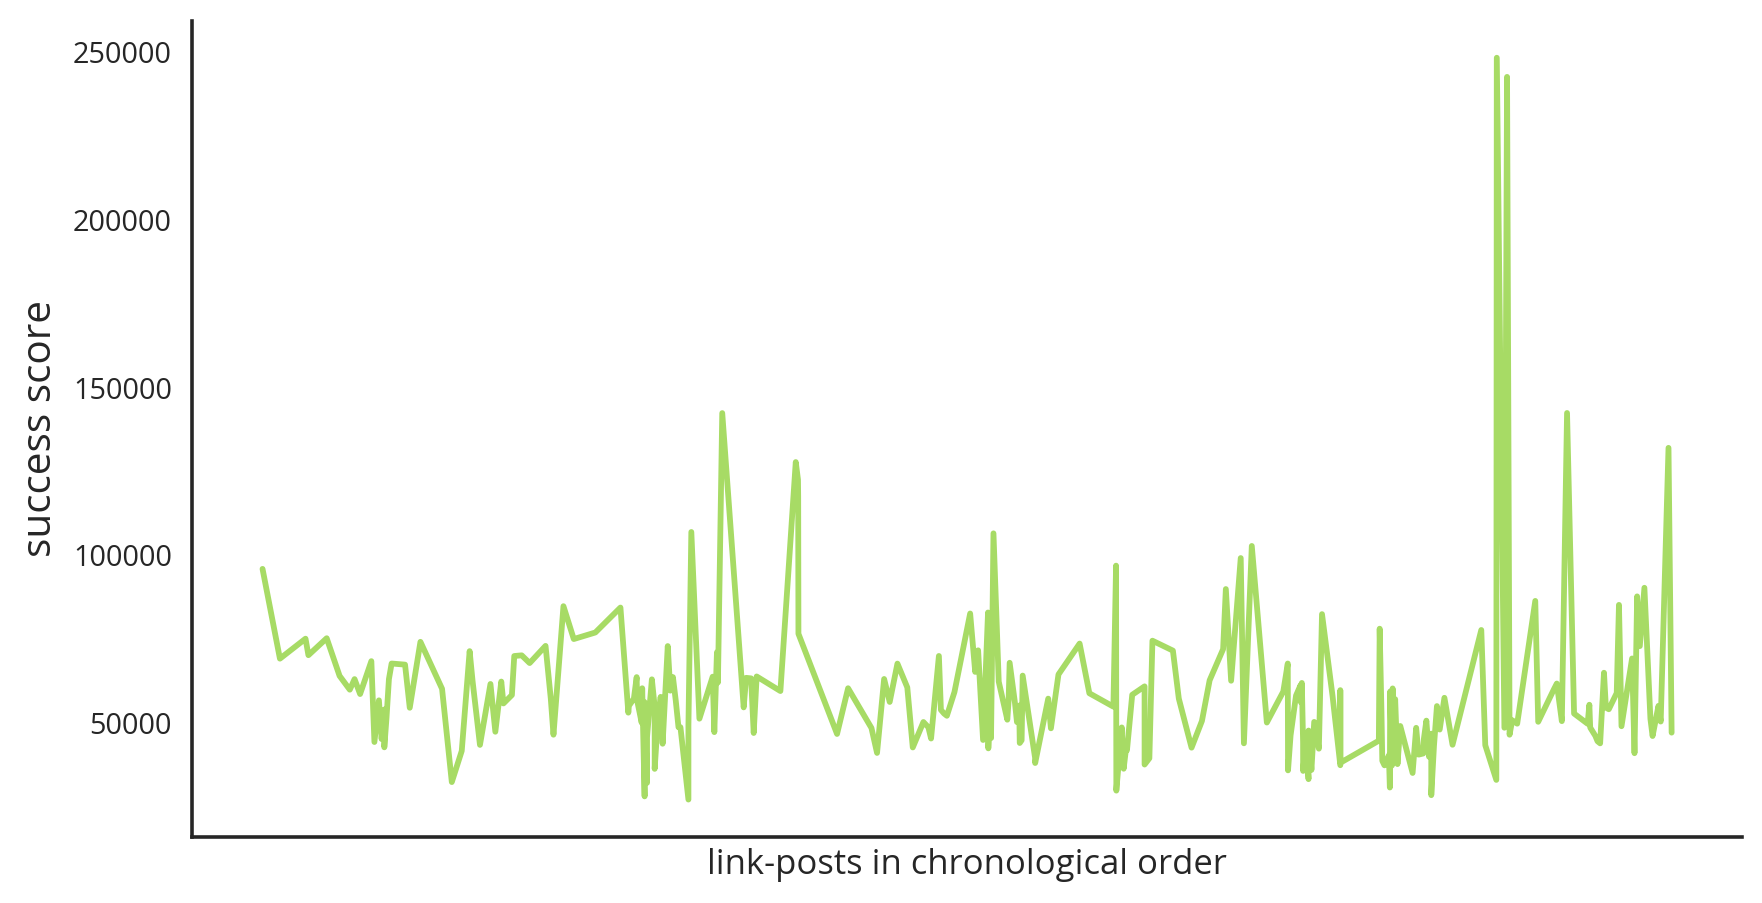

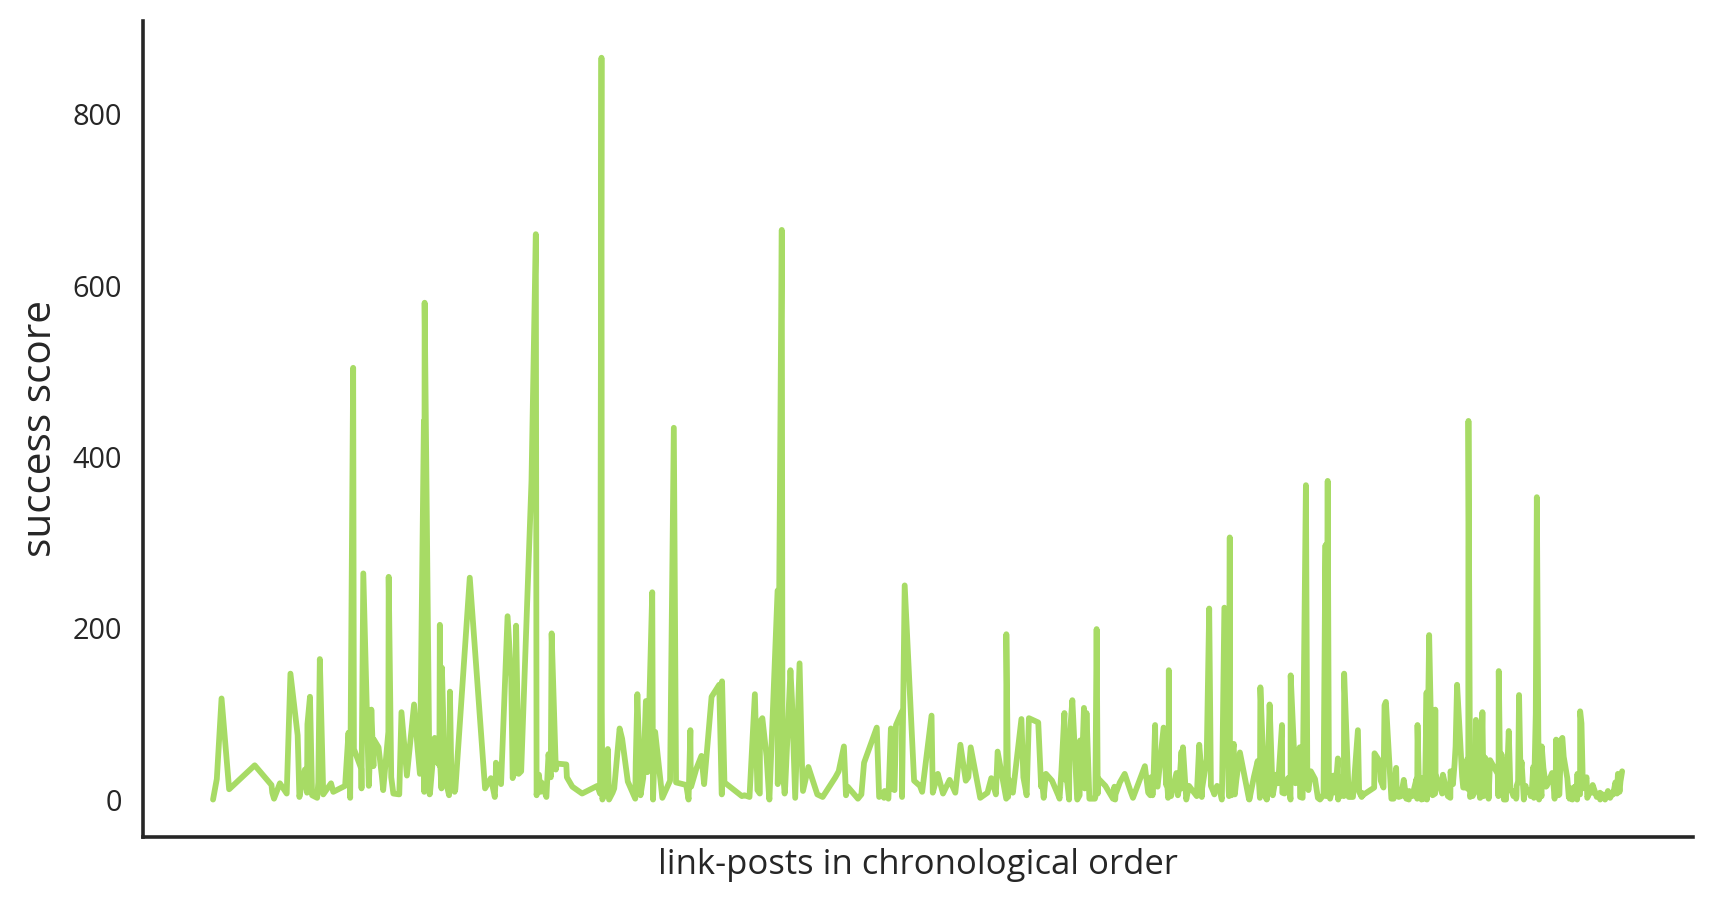

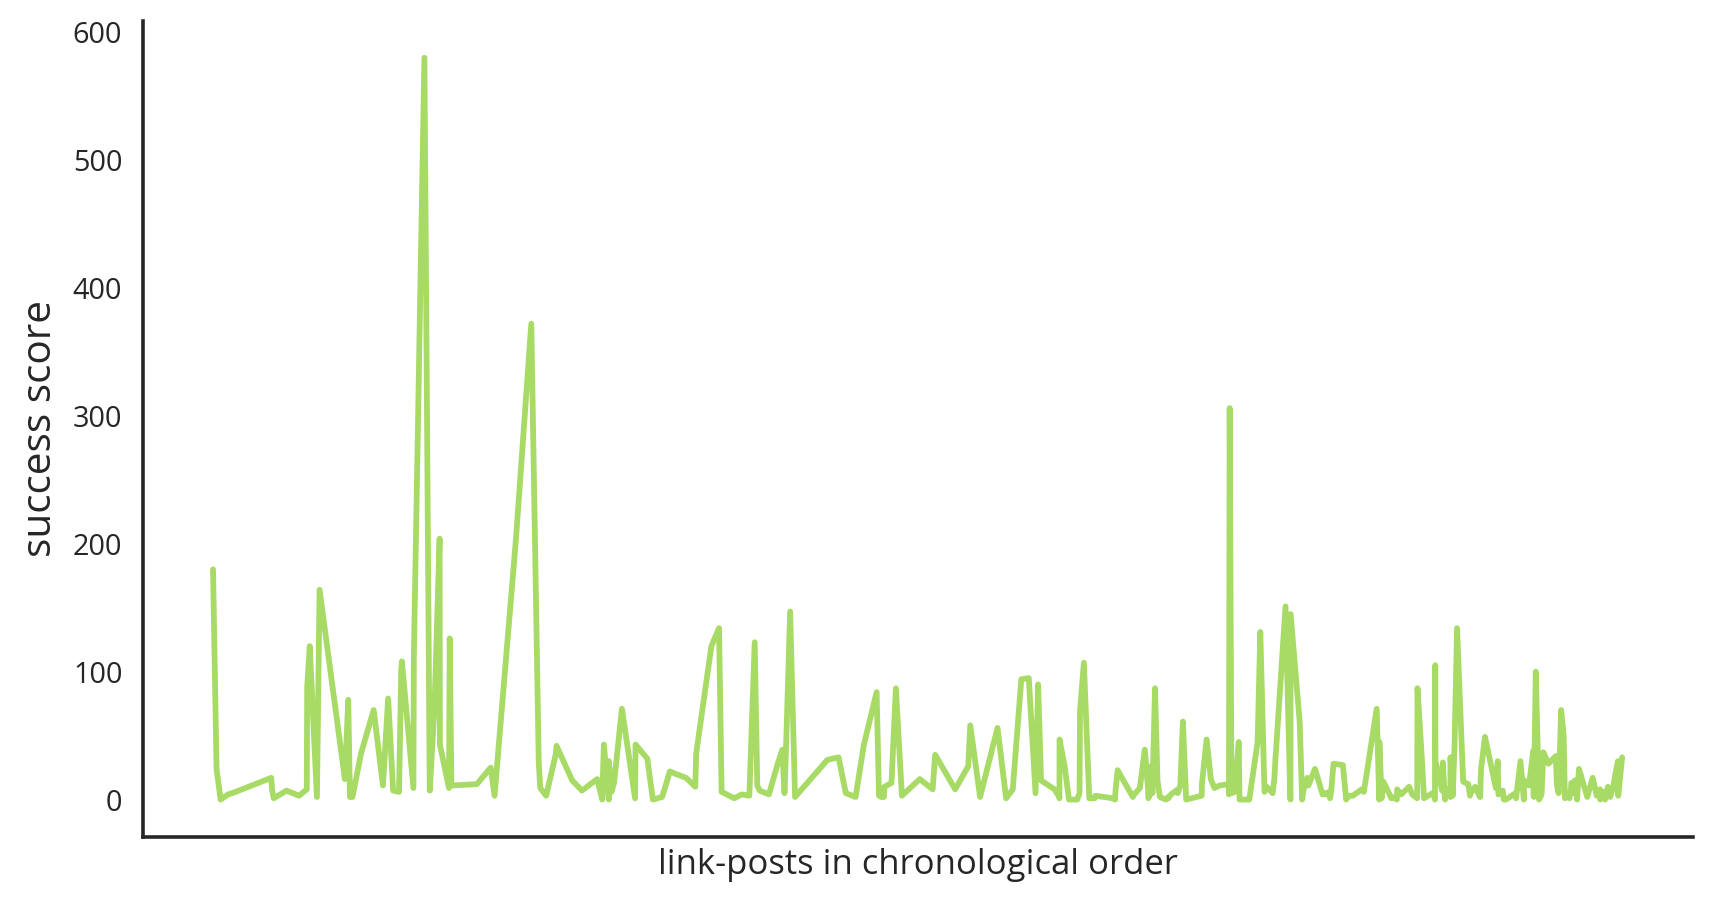

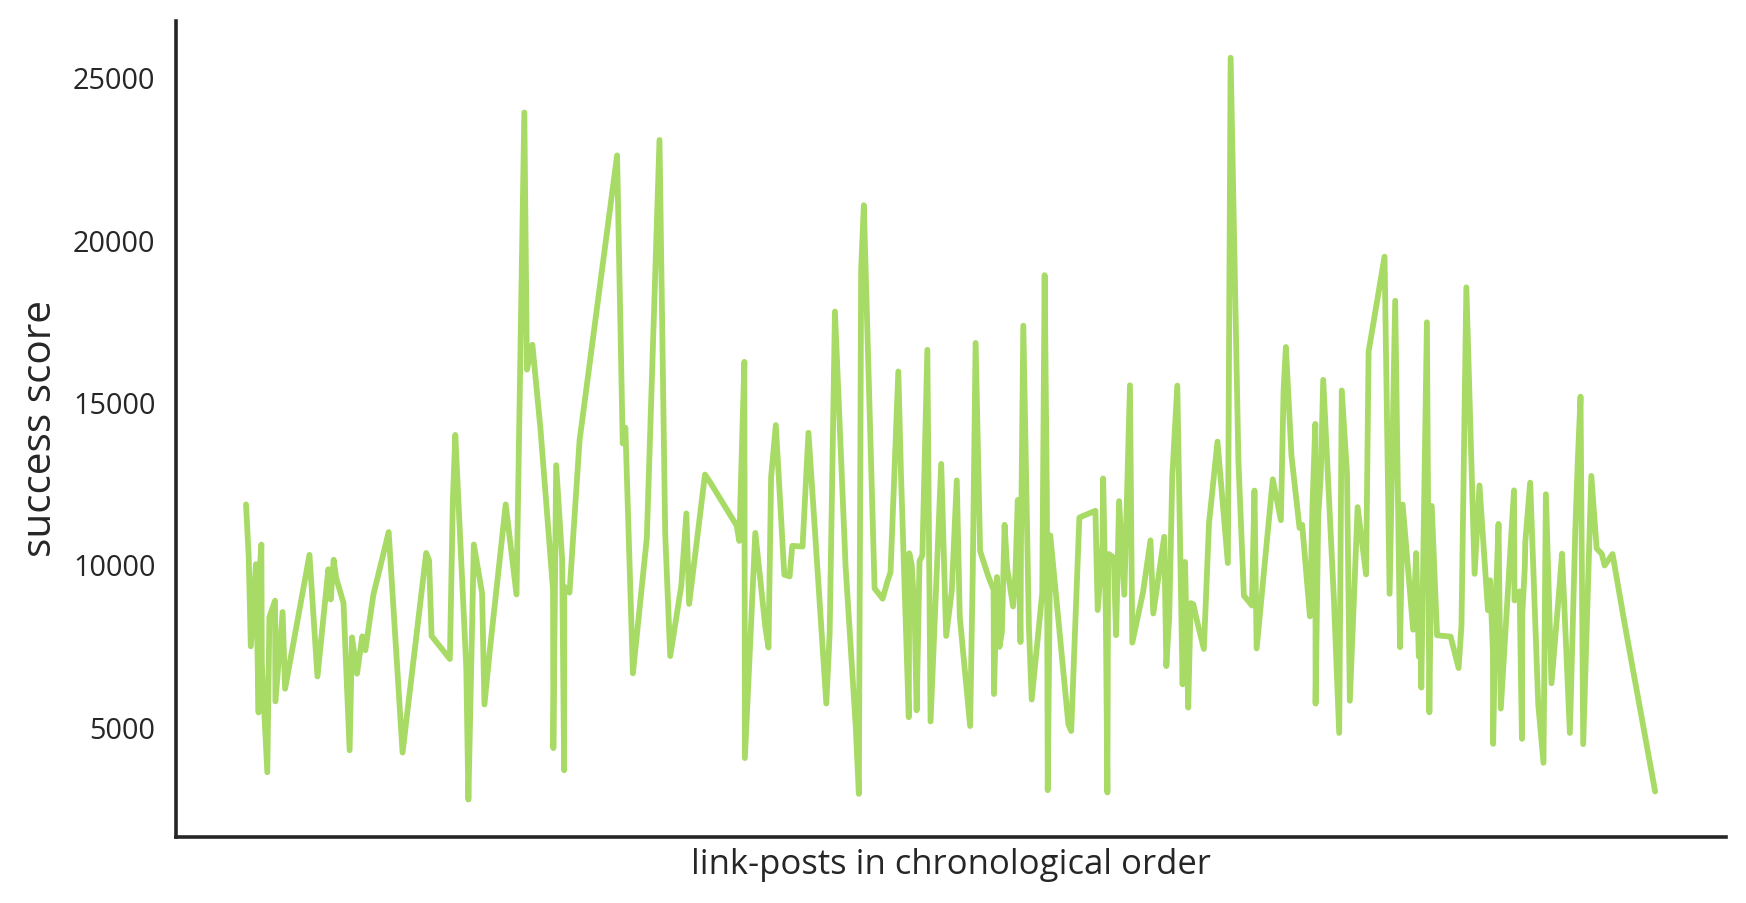

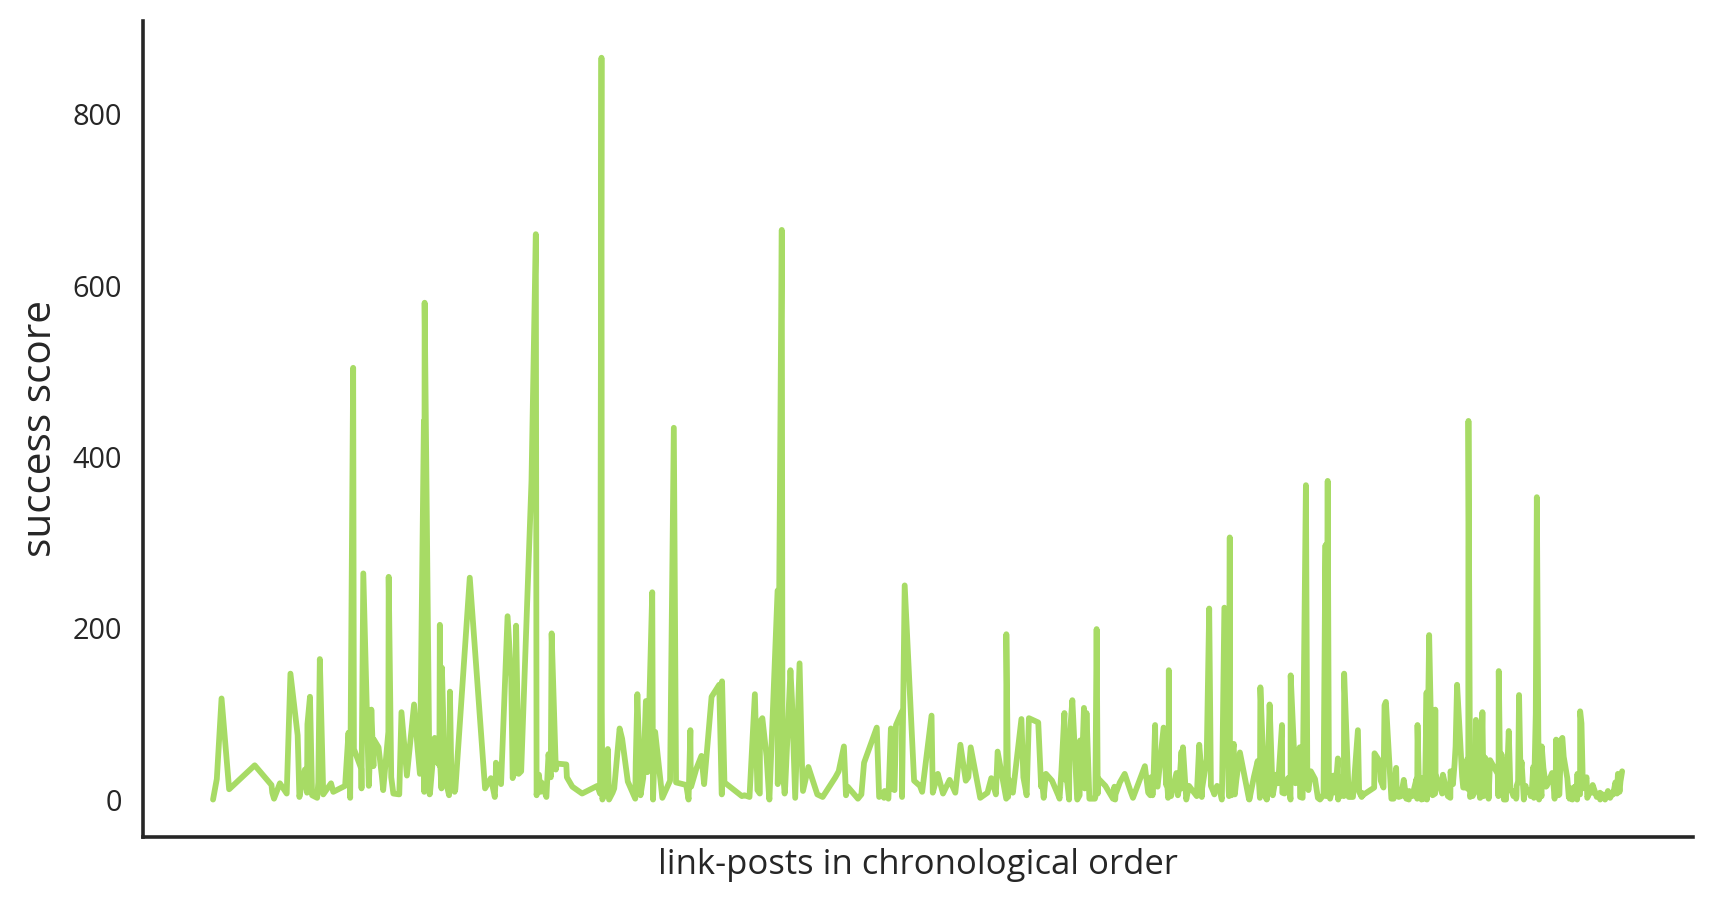

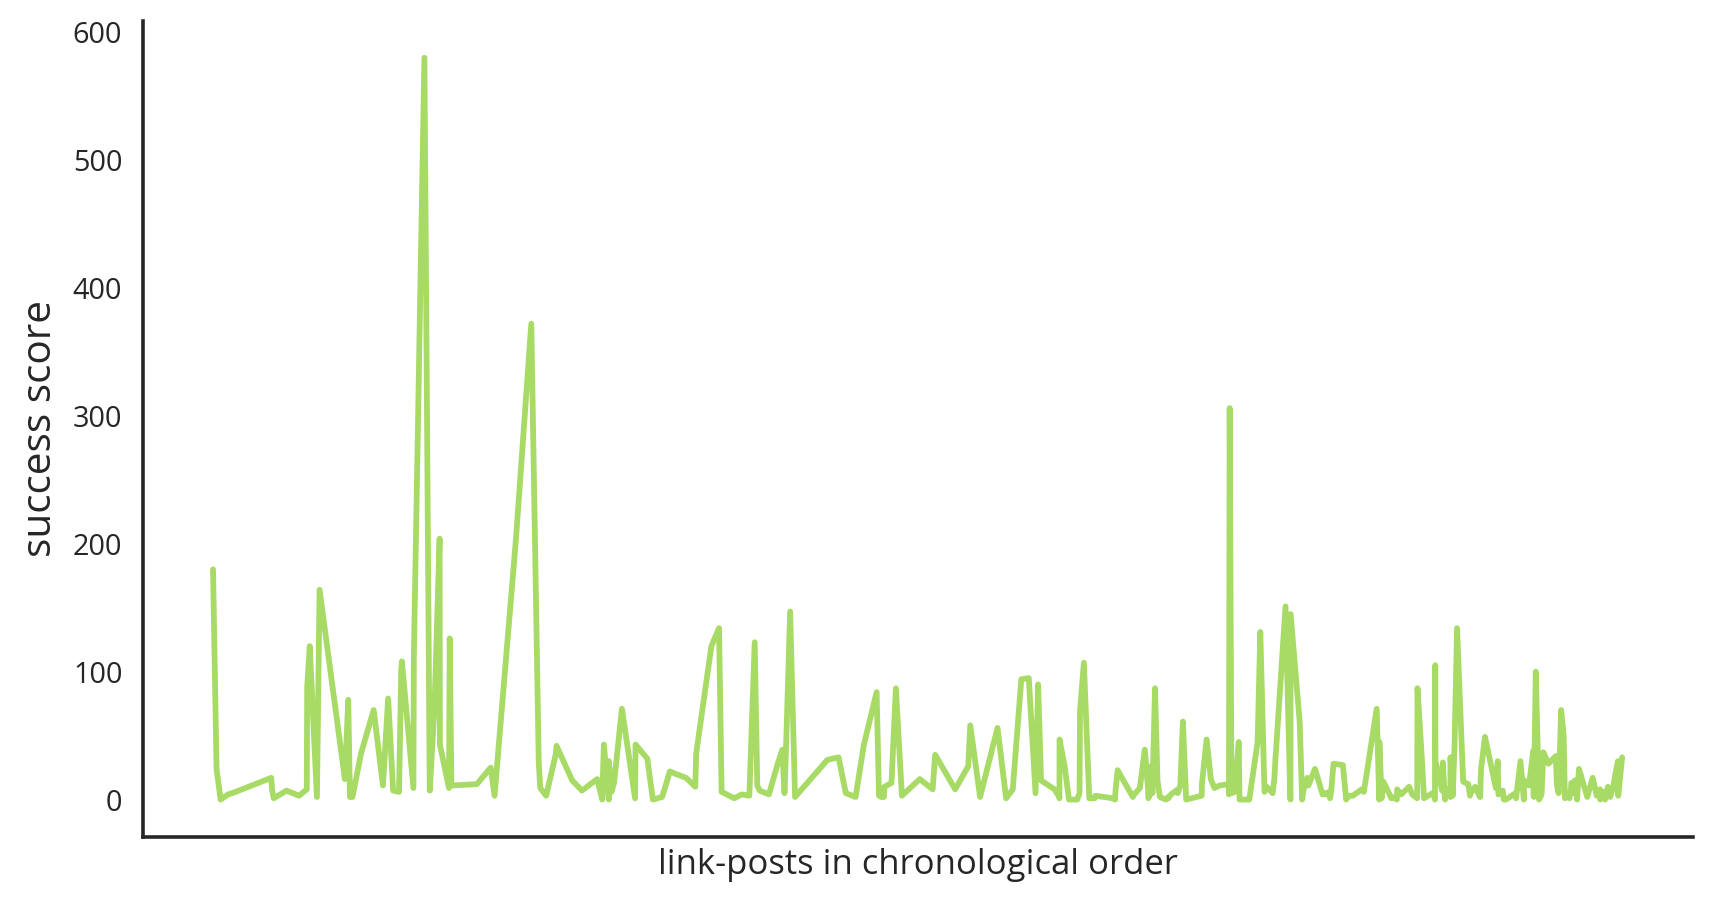

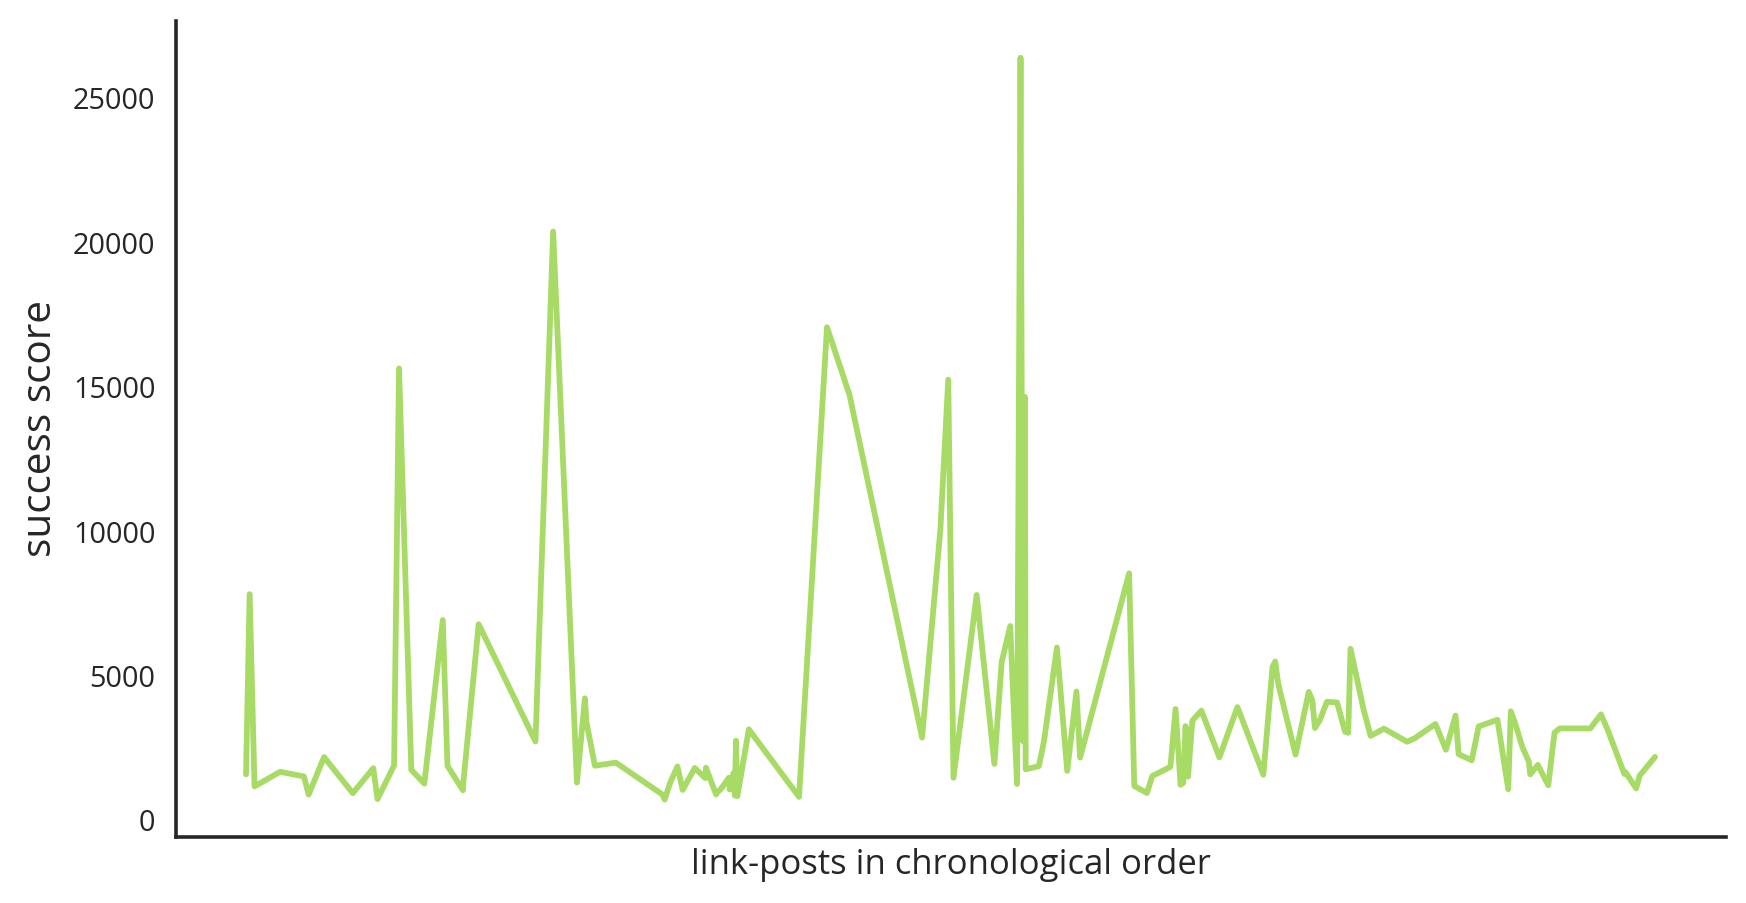

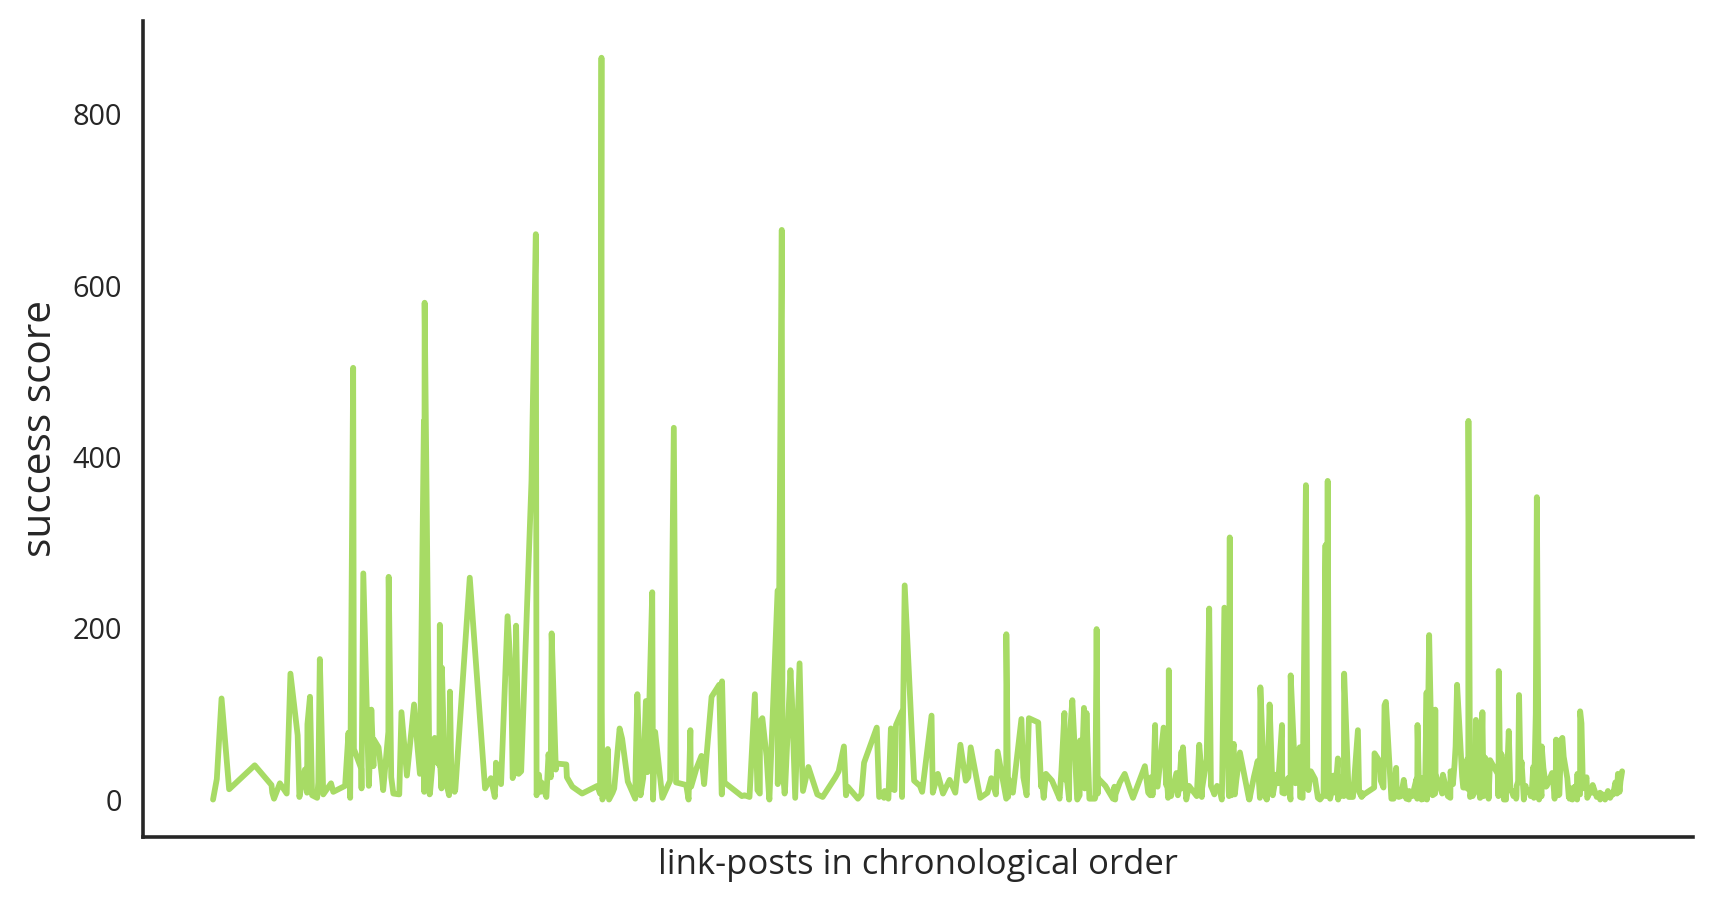

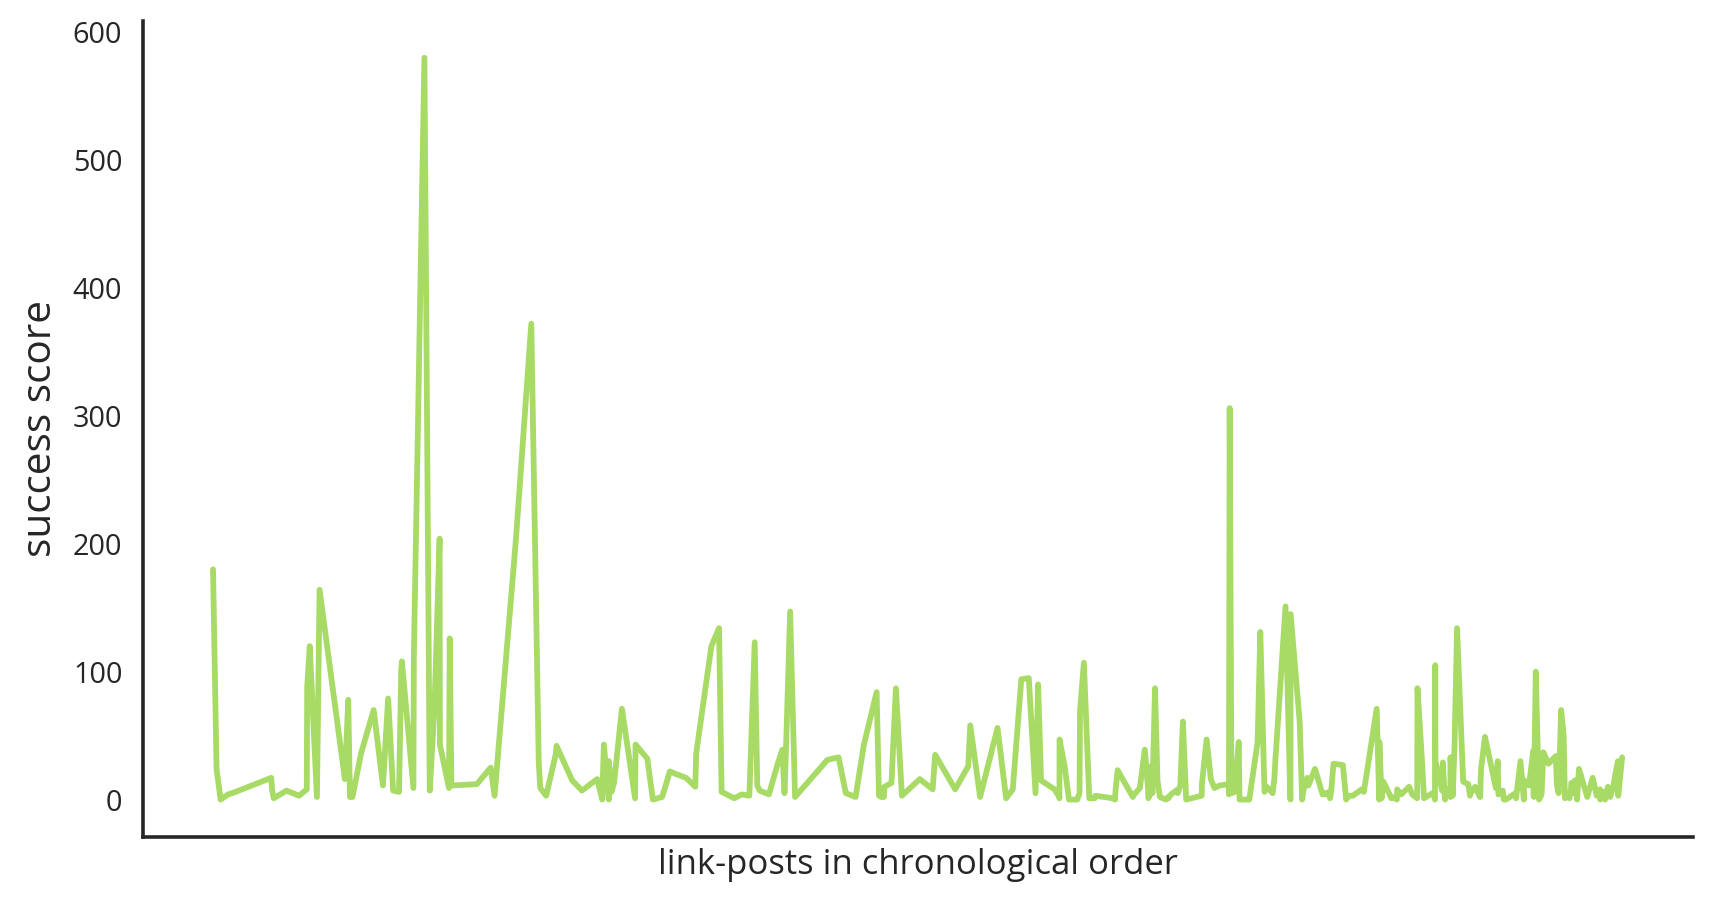

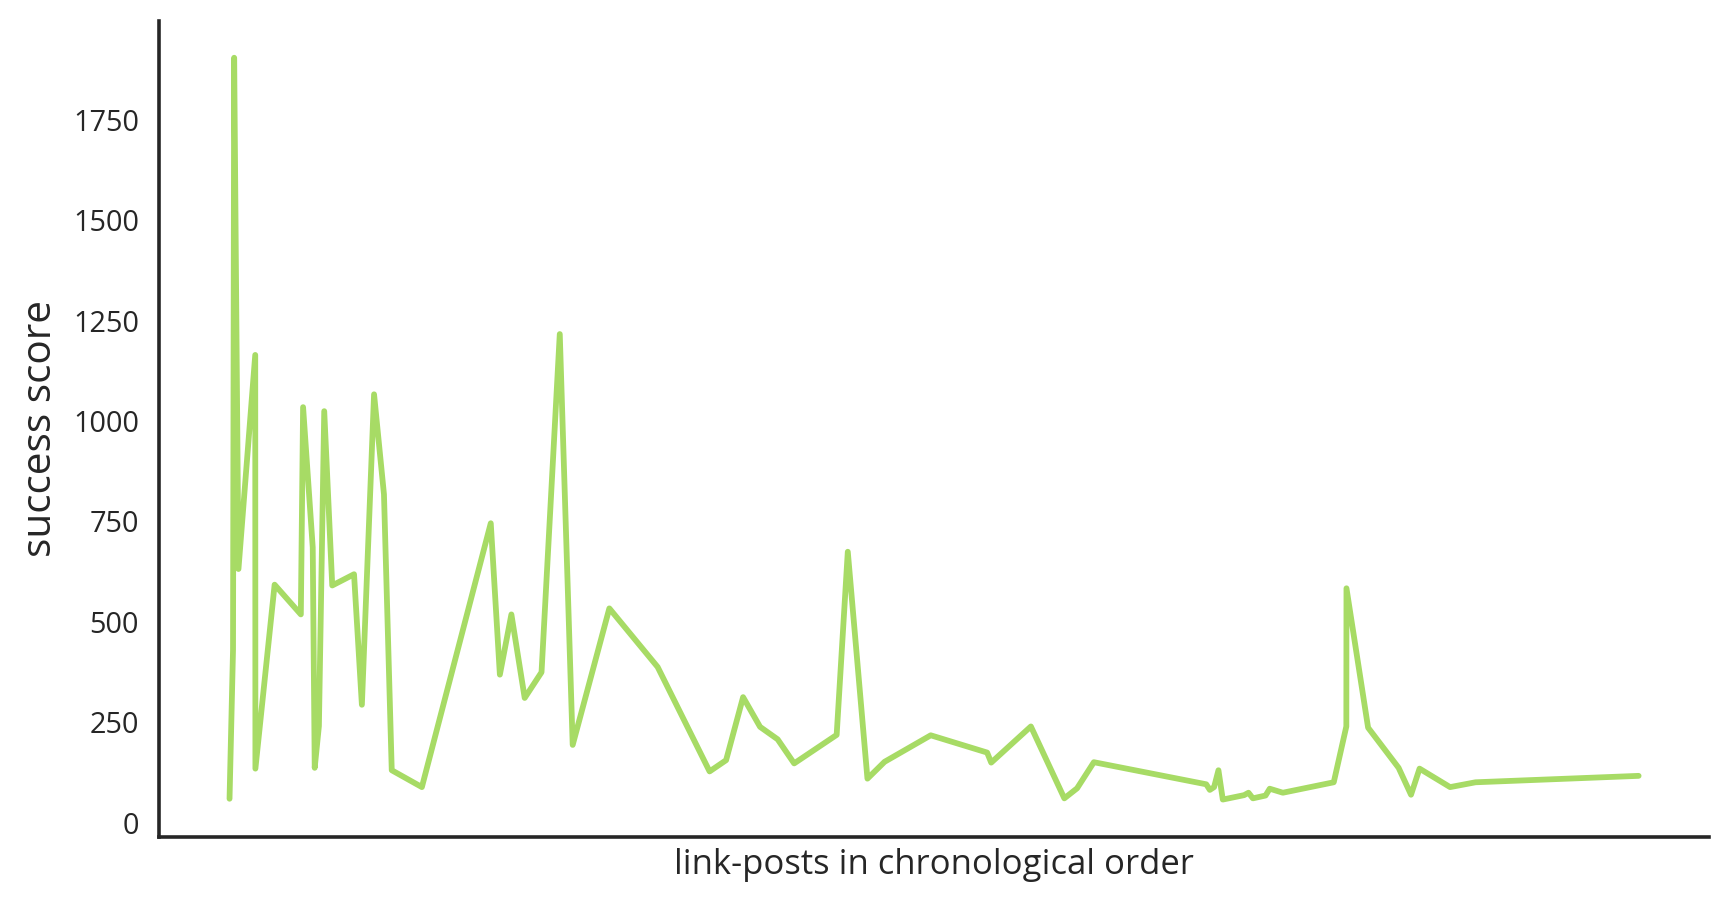

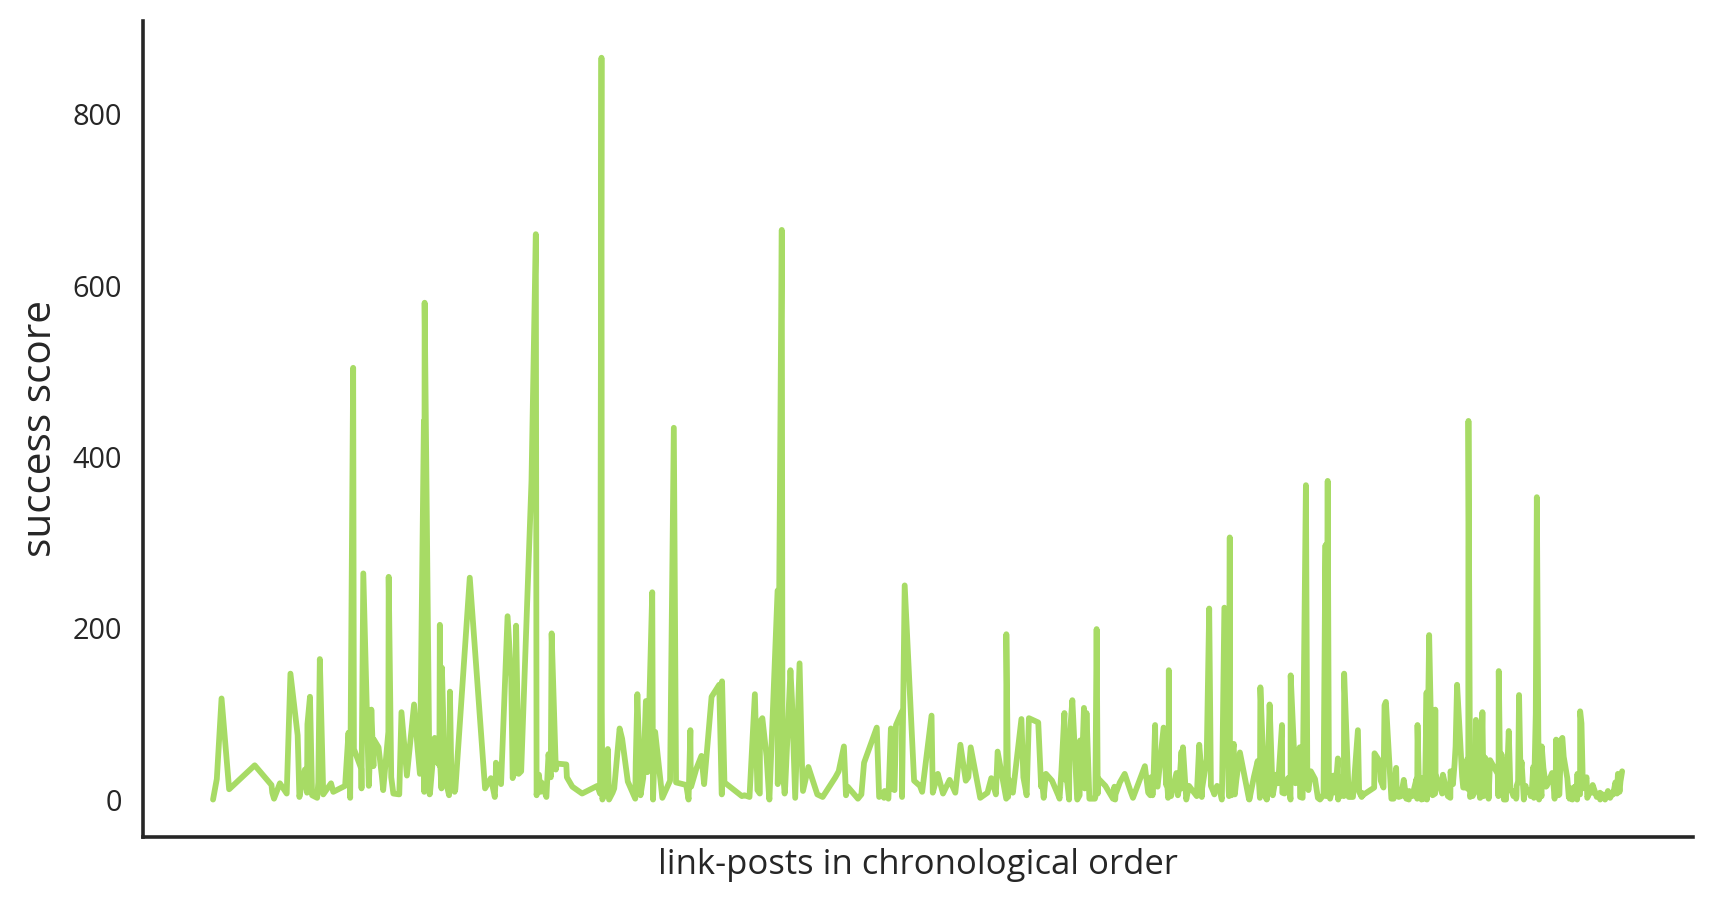

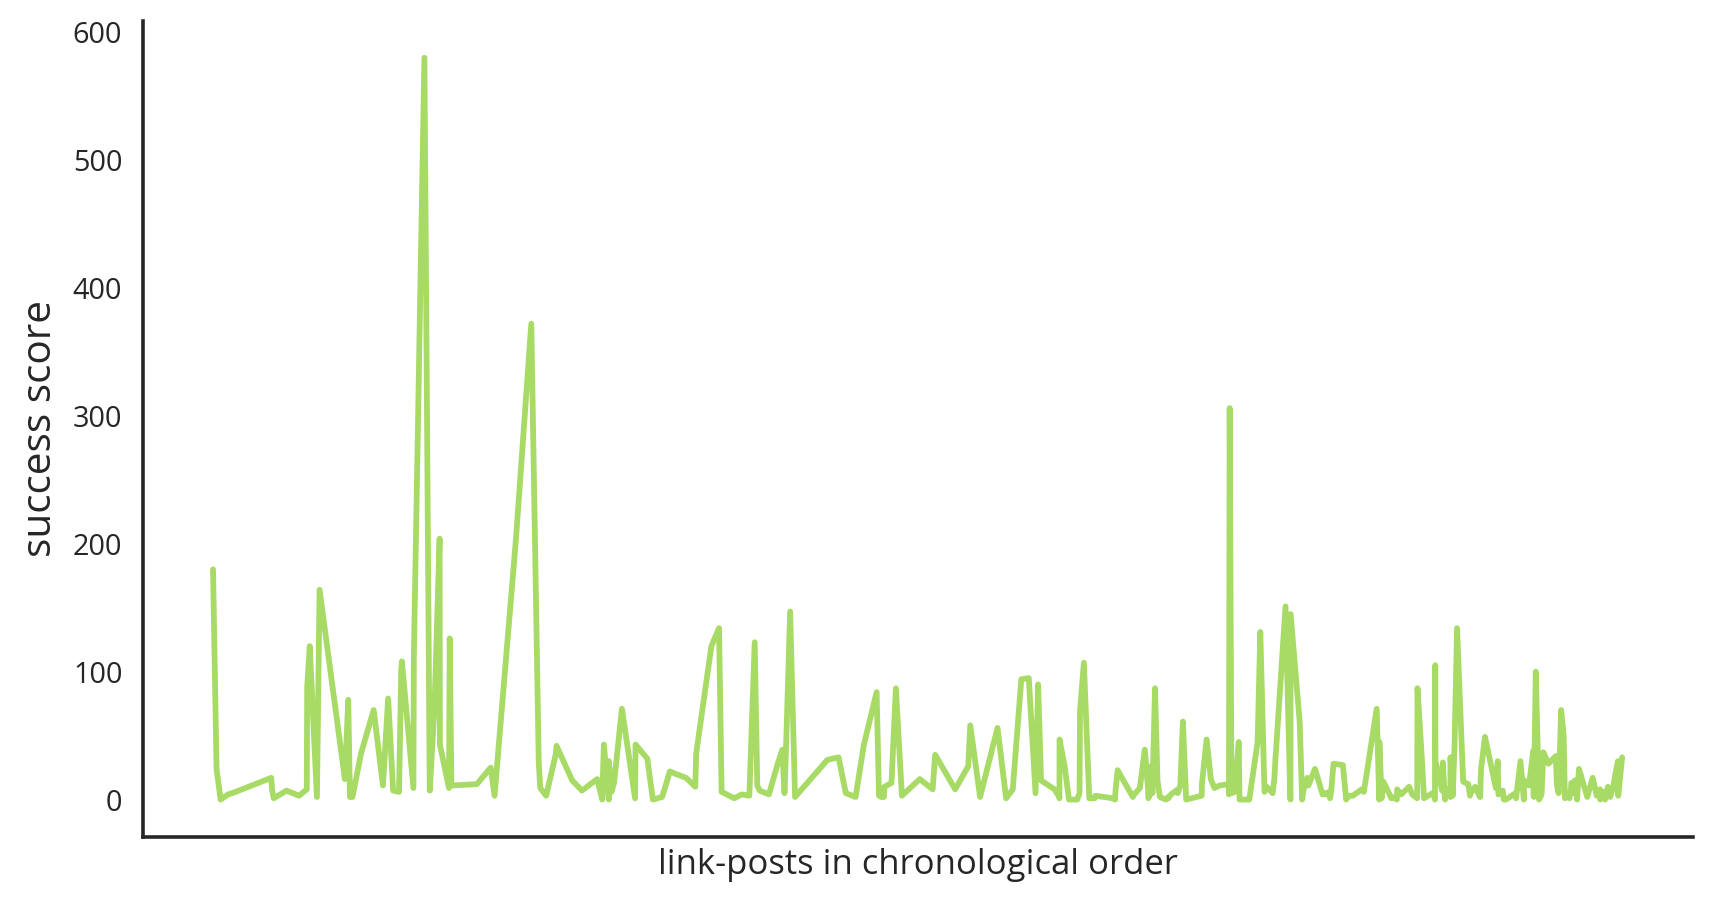

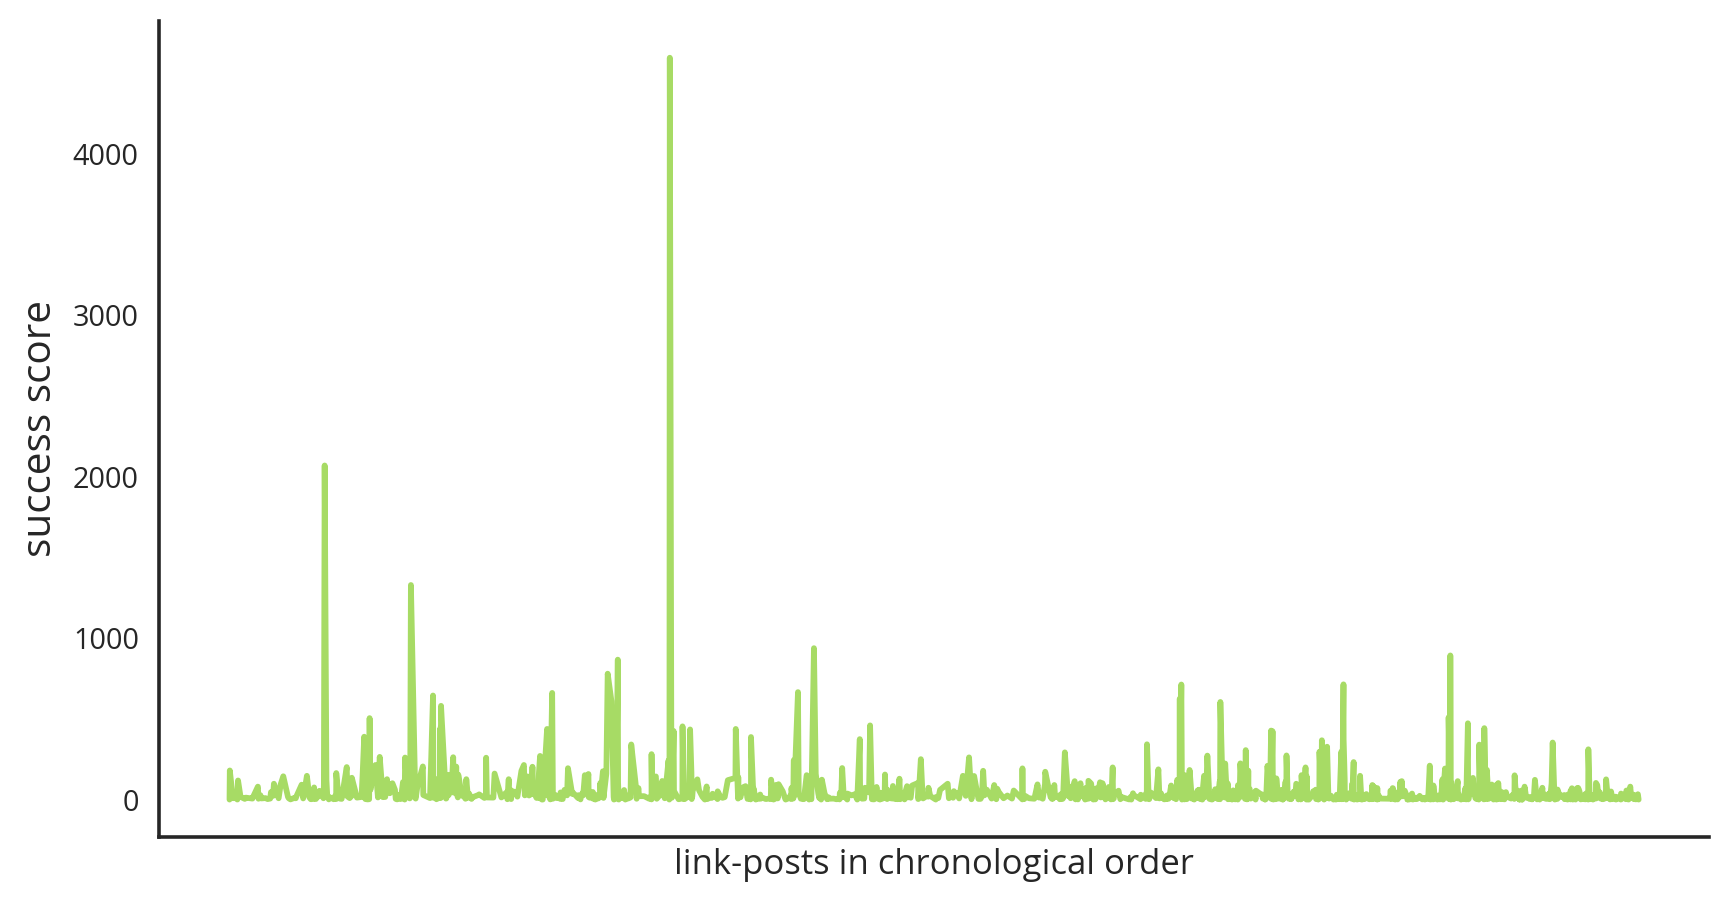

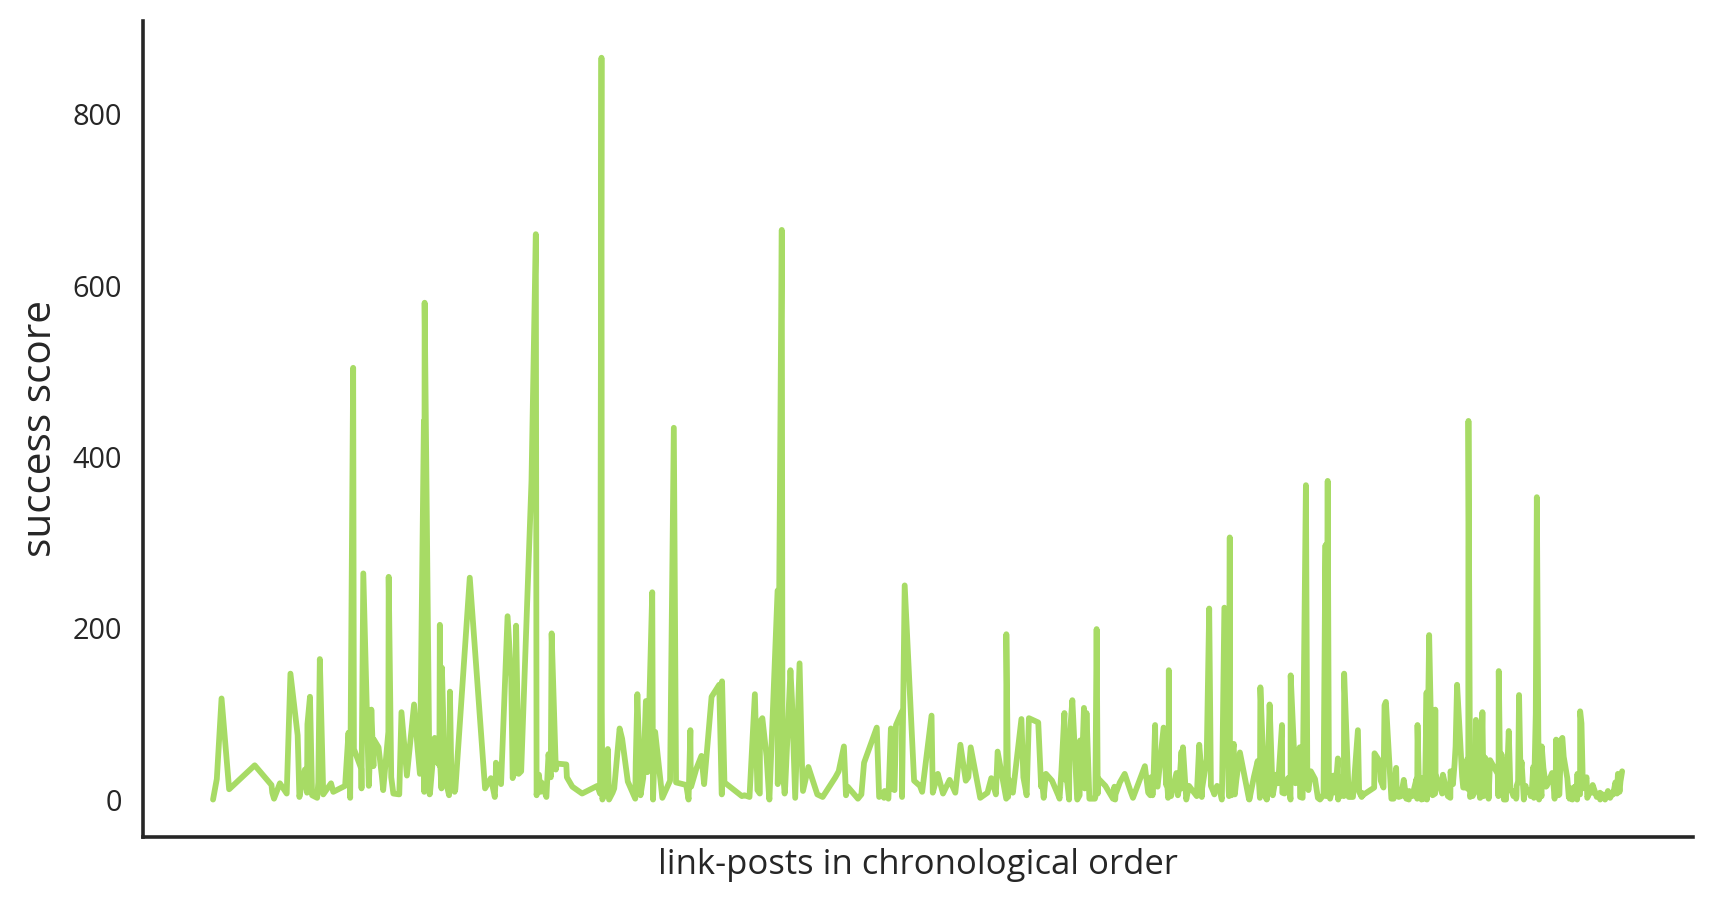

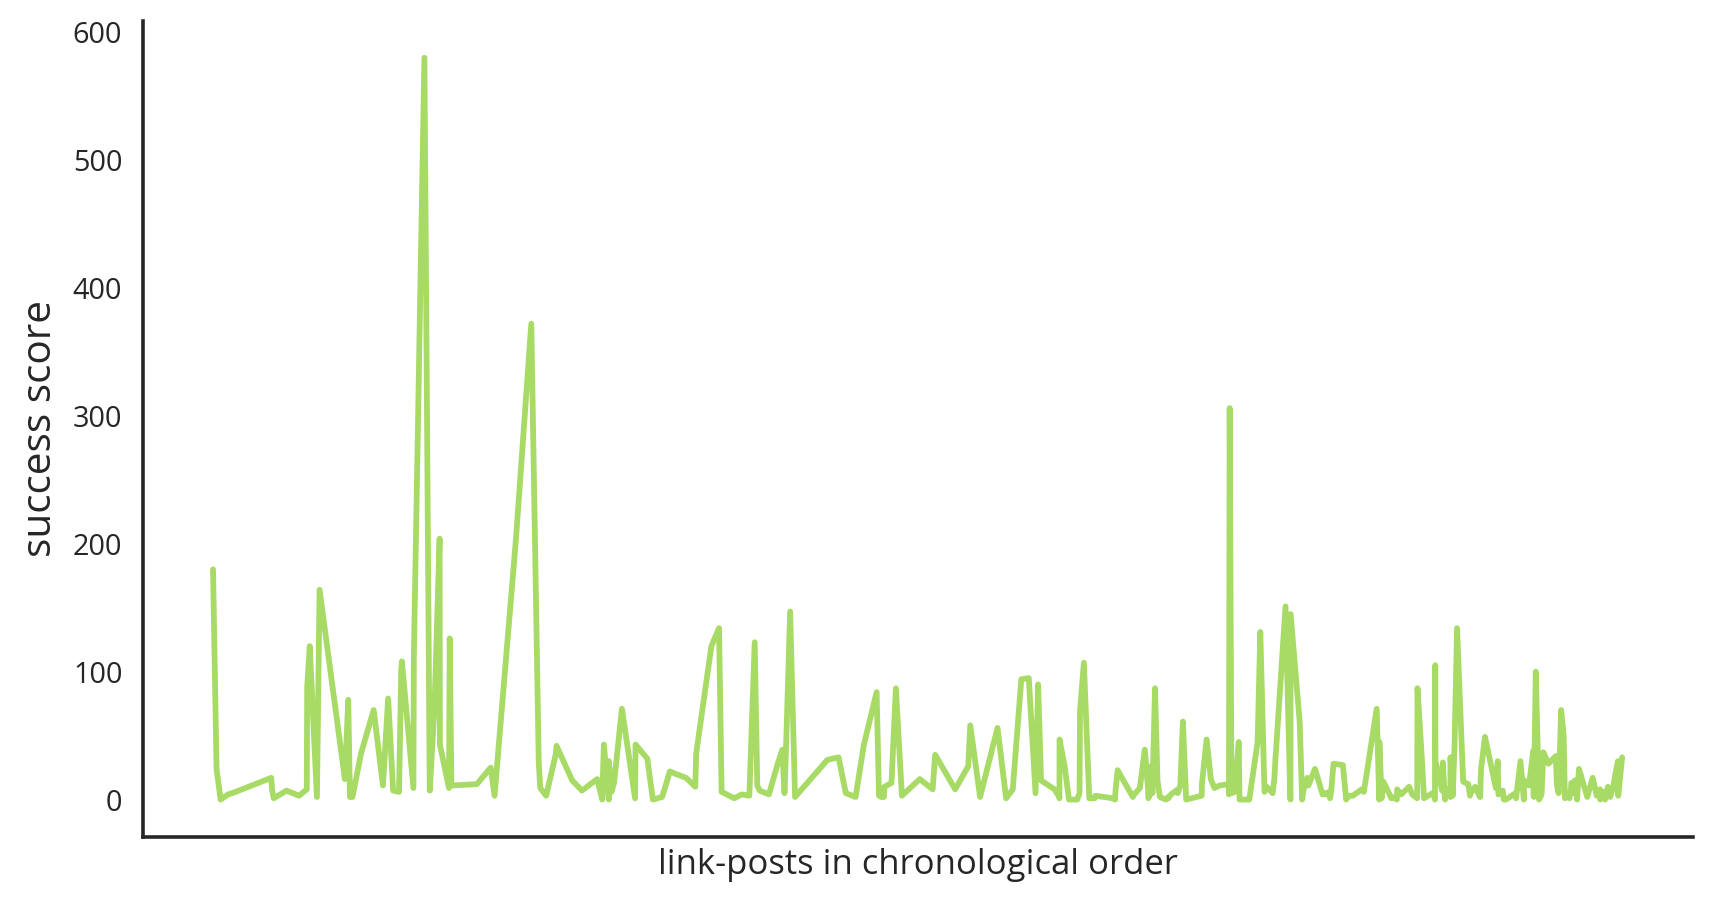

In [40]:
for path in os.listdir('../processed'):
    if path.endswith('.csv'):
        print(path)
        df = pd.read_csv('../processed/' + path)
        label = path[10:-4]
#         plot_overall_engagement(df, label)
        get_line_graph(df, label)
#         migration = df[df['social justice + migration'] >= 0.3]
#         vegan = df[df['social justice + dairy free vegan'] >= 0.3]
#         plot_overall_engagement(vegan, label, metric = 'success', mode = 'vegan')
#         plot_overall_engagement(migration, label, metric = 'success', mode = 'migration')
        get_line_graph(vegan, label, 'vegan')
        get_line_graph(migration, label, 'migration')

In [31]:
dat = pd.read_csv('../processed/' + 'processed_FB_GreenpeaceCH.csv')

In [32]:
dat = dat.sort_values('created_time', ascending=True)


/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


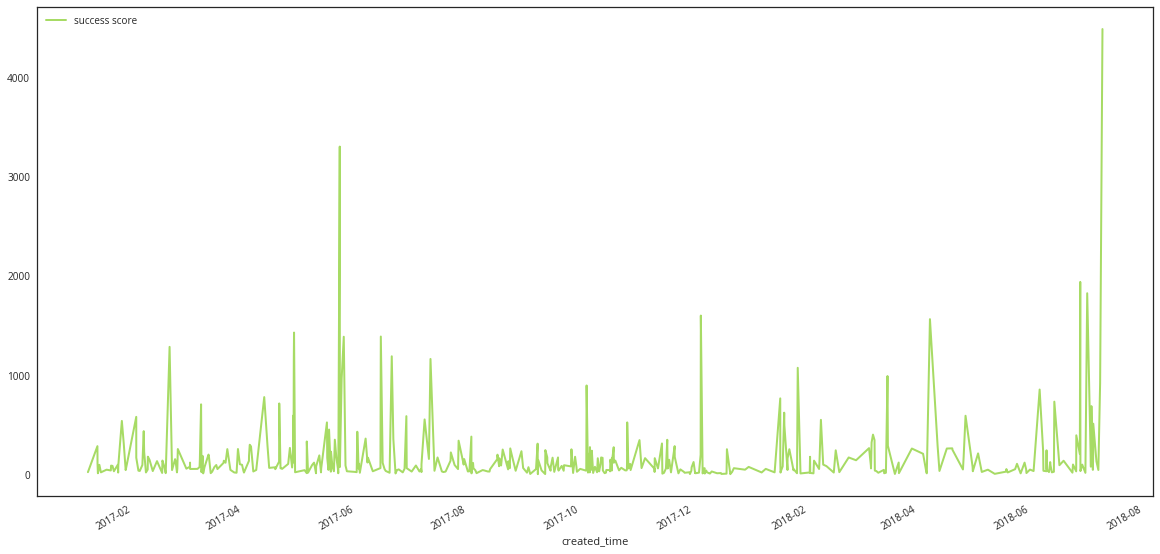

In [38]:
plt.figure(figsize=(20,10))
rel = dat[dat['created_time']>='2017-01']
rel['created_time'] = pd.to_datetime(rel['created_time'])
rel.plot('created_time', 'success', ax=plt.gca(), c = c_success, linewidth=2.0, label = 'success score')


# (4) Heatmap

In [58]:
c_successful = '#7ea54c'#'#A7DB65'
c_unsuccessful = '#d6a92f'#'#E8C35D'

In [59]:
benandjerryness = 'spaß, verspielt, lächeln, klug, überraschend, unerwartet, optimistisch, positiv, mutig, wahr, vertrauenswürdig, transparent, relevant, wendig, zeitgerecht, wirkungsvoll'
benandjerryness_wv = get_average_vector(tokenizer.tokenize(benandjerryness), emb)
fb['benandjerryness'] = fb['wv'].map(lambda x: cosine_similarity(x, benandjerryness_wv))

In [61]:
def get_keyword_dimension_scores(keywords, dimensions, emb, y_dim, x_dim = 'benandjerryness'):
    y_dim_vector = dimensions.loc[dimensions['label']==y_dim, 'dimension'].iloc[0]
    if x_dim == 'benandjerryness':
        x_dim_vector = benandjerryness_wv
    else:
        x_dim_vector = dimensions.loc[dimensions['label']==x_dim, 'dimension'].iloc[0]
    x, y = [], []
    for keyword in keywords:
        y_dim_score = cosine_similarity(y_dim_vector, emb[keyword])
        x_dim_score = cosine_similarity(x_dim_vector, emb[keyword])
        x.append(x_dim_score)
        y.append(y_dim_score)
    return np.array(x), np.array(y)

In [82]:
def plot_heatmap_no_words(df, label, mode = 'default', x_dim = 'benandjerryness', y_dim = 'community'):
    df['benandjerryness'] = df['wv'].map(lambda x: cosine_similarity(x, benandjerryness_wv))
    nonzero = df[df['success'] != 0]
    nonzero['quantile'] = pd.qcut(nonzero['success'], 25, range(25))

    bot = set(itertools.chain.from_iterable(nonzero.loc[nonzero['quantile'] == 0, 'tokens'].values))
    top = set(itertools.chain.from_iterable(nonzero.loc[nonzero['quantile'] == 24, 'tokens'].values))

    bot = set([x for x in bot if x in emb.vocab])
    top = set([x for x in top if x in emb.vocab])

    bot_unique = bot-top
    top_unique = top-bot
    
    x1, y1 = get_keyword_dimension_scores(top_unique, dimensions, emb, y_dim, x_dim)
    x2, y2 = get_keyword_dimension_scores(bot_unique, dimensions, emb, y_dim, x_dim)

    c_1 = c_successful
    c_2 = c_unsuccessful
    # cmap = sns.cubehelix_palette(start=0.2, light=1, as_cmap=True)
    cmap_y = sns.light_palette(c_1, as_cmap=True)
    cmap_x = sns.light_palette(c_2, as_cmap=True)
    # sns.kdeplot(x, y, cmap=cmap, shade=True)
    fig, ax = plt.subplots(figsize=(2000/float(208), 1200/float(208)), dpi=208)
    sns.kdeplot(np.array(x2), np.array(y2), shade=True, cmap=cmap_x, shade_lowest=False, ax=ax, n_levels=7, alpha=0.8, label='bottom keywords', legend=False)
    sns.kdeplot(np.array(x1), np.array(y1), shade=True, cmap=cmap_y, shade_lowest=False, ax=ax, n_levels=7, alpha=0.8, label='top keywords', legend=False)
    #ax.legend(loc="best")
    #ax.legend(handles=ax.lines, labels=["A","B"])
    #ax.legend(labels=["top keywords", "bottom keywords"])
    red_patch = mpatches.Patch(color=c_1, label='successful keywords')
    yellow_patch = mpatches.Patch(color=c_2, label='unsuccessful keywords')
    plt.legend(handles=[red_patch, yellow_patch])

    ax.axis([-0.25, 0.8, -0.25, 0.8])

    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    centerx, centery = 0, 0
    ax.spines['left'].set_position(('data', centerx))
    ax.spines['bottom'].set_position(('data', centery))
    # ax.spines['right'].set_position(('data', centerx - 1))
    # ax.spines['top'].set_position(('data', centery - 1))
    ax.axes.spines['top'].set_visible(False)
    #ax.axes.spines['bottom'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    #ax.axes.spines['left'].set_visible(False)
    ax.set_ylabel(y_dim, fontsize=12)
    ax.set_xlabel('Ben & Jerry-ness', fontsize=12)
    ax.xaxis.set_label_coords(0.92, 0.22)
    ax.yaxis.set_label_coords(0.22, 0.88)
    plt.savefig('../figs/heatmap_nowords_{}.png'.format(label), bbox_inches='tight', transparent=True)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


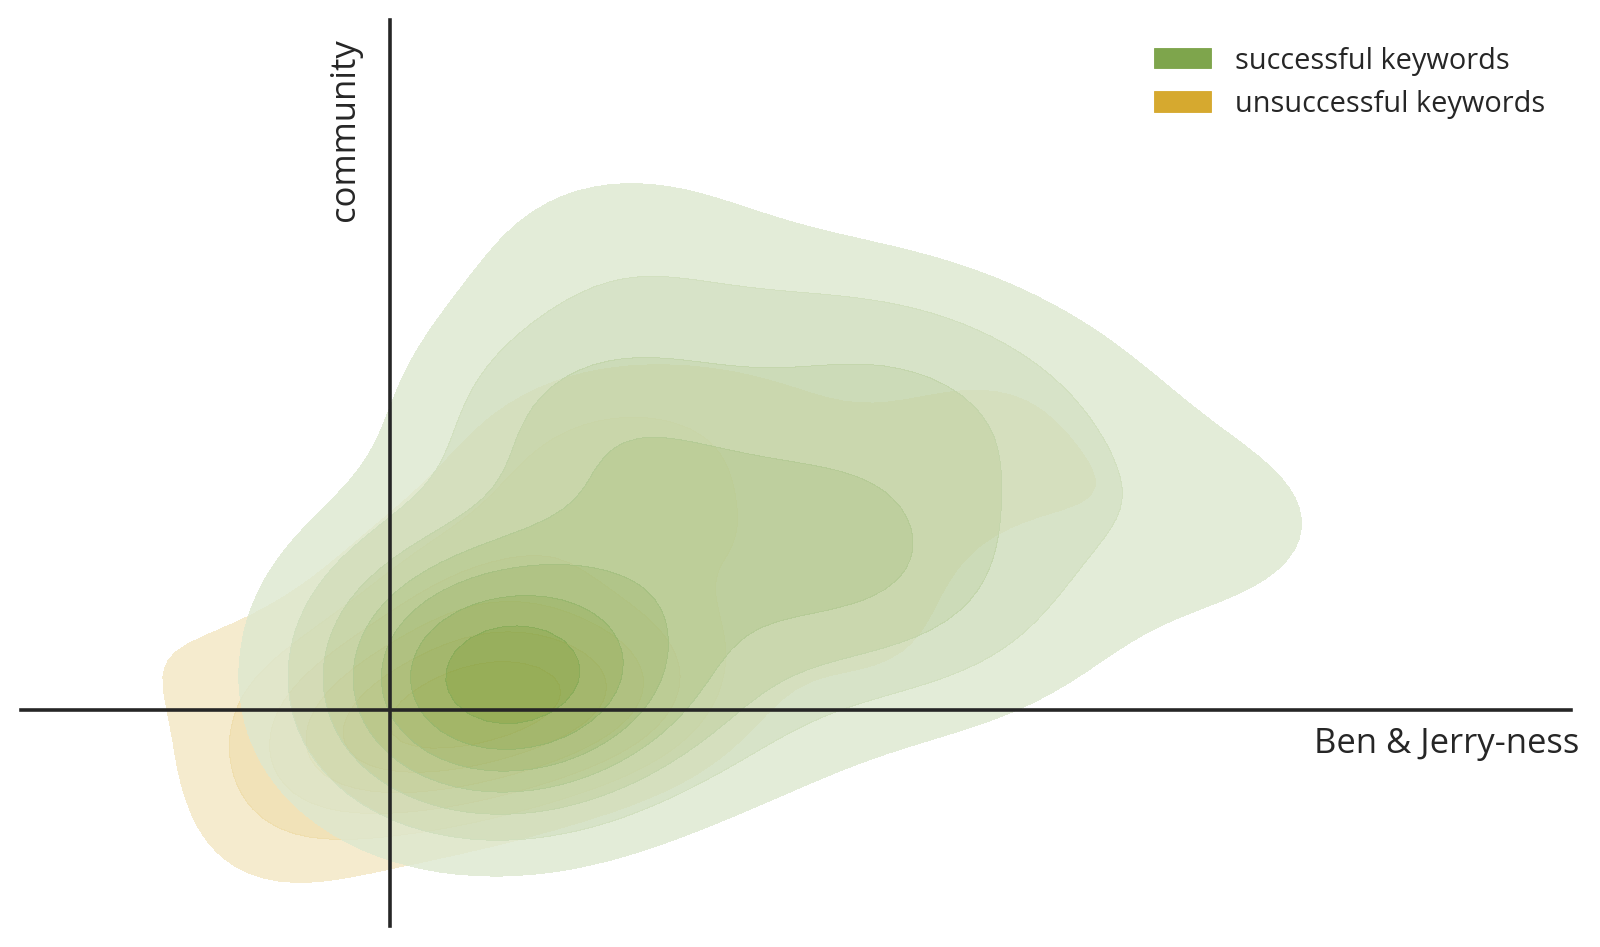

In [83]:
plot_heatmap_no_words(fb[fb['social justice + migration'] >=0.3], 'migration', mode = 'default', x_dim = 'benandjerryness', y_dim = 'community')

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


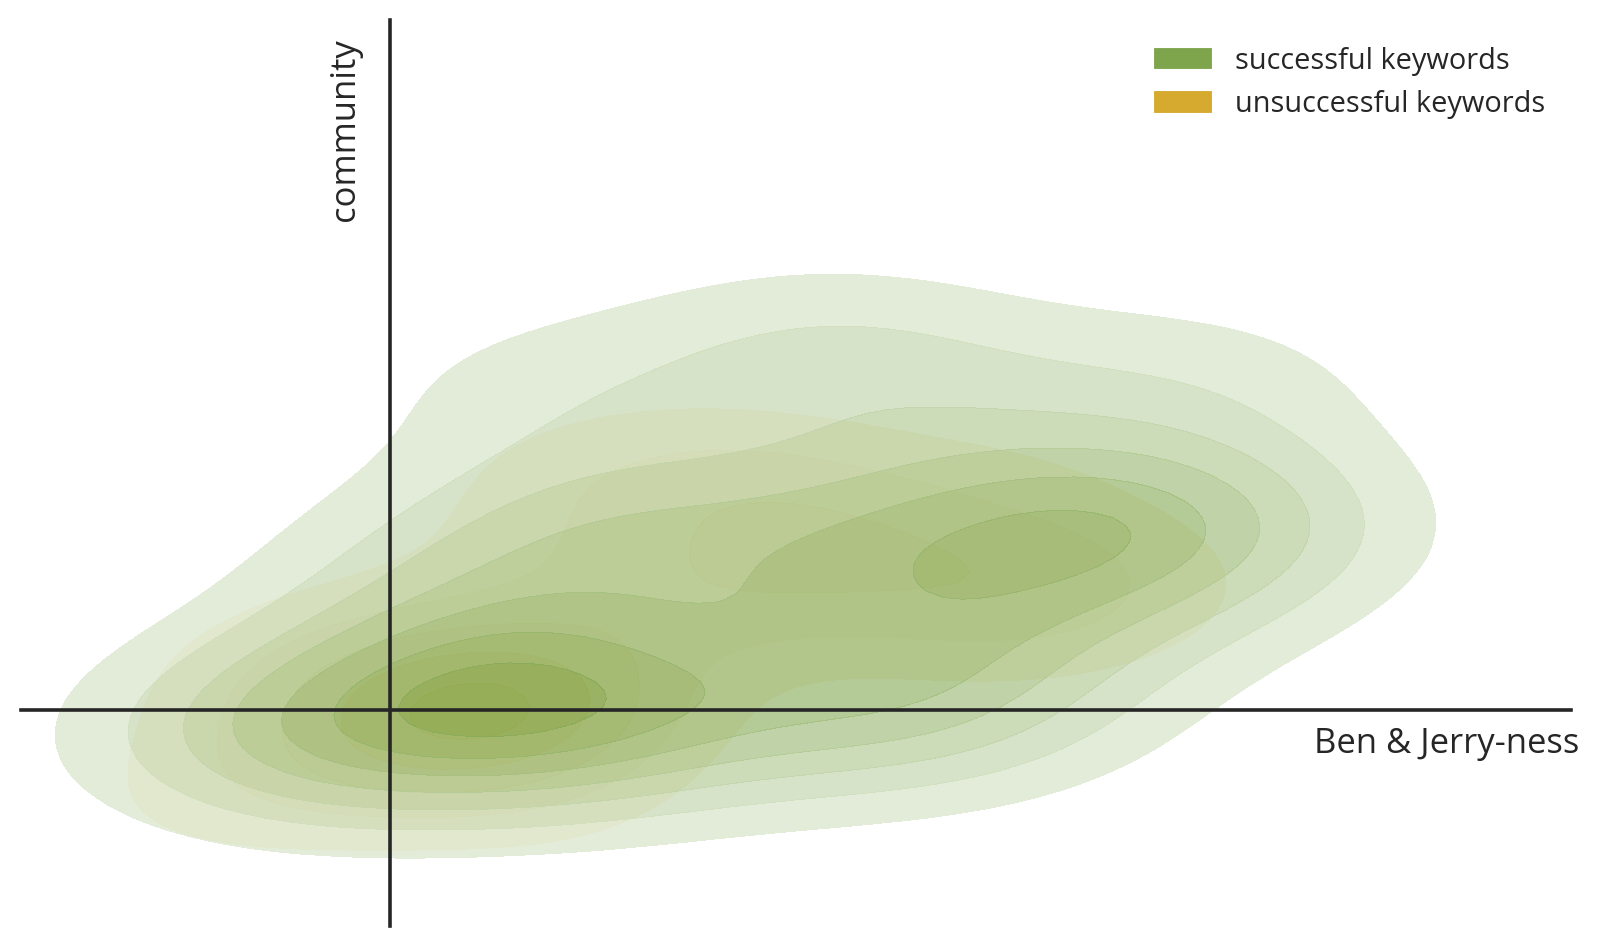

In [84]:
plot_heatmap_no_words(fb[fb['social justice + dairy free vegan'] >=0.3], 'vegan', mode = 'default', x_dim = 'benandjerryness', y_dim = 'community')

In [92]:
def plot_heatmap_recommended_words(df, label, mode = 'default', x_dim = 'benandjerryness', y_dim = 'community'):
    df['benandjerryness'] = df['wv'].map(lambda x: cosine_similarity(x, benandjerryness_wv))
    nonzero = df[df['success'] != 0]
    nonzero['quantile'] = pd.qcut(nonzero['success'], 25, range(25))

    bot = set(itertools.chain.from_iterable(nonzero.loc[nonzero['quantile'] == 0, 'tokens'].values))
    top = set(itertools.chain.from_iterable(nonzero.loc[nonzero['quantile'] == 24, 'tokens'].values))

    bot = set([x for x in bot if x in emb.vocab])
    top = set([x for x in top if x in emb.vocab])

    bot_unique = bot-top
    top_unique = top-bot

    y_dim_vector = dimensions.loc[dimensions['label'] == y_dim, 'dimension'].iloc[0]
    if x_dim == 'benandjerryness':
        x_dim_vector = benandjerryness_wv
    else:
        x_dim_vector = dimensions.loc[dimensions['label']==x_dim, 'dimension'].iloc[0]

    top_1000_y_dim = emb.similar_by_vector(y_dim_vector, topn=1000)
#     print(top_1000_y_dim[:5])

    for i in range(len(top_1000_y_dim)):
        word, y_dim_score = top_1000_y_dim[i]
        bj_score = cosine_similarity(x_dim_vector, emb[word])
        top_1000_y_dim[i] = (word, y_dim_score, bj_score)

    top_1000_y_dim.sort(key=lambda x: x[1]+2*x[2], reverse=True)
    recommended_words = [x[0] for x in top_1000_y_dim[1:5]]
    recommended_words_english = [translator.translate(x, src='de').text for x in recommended_words]

    x1, y1 = get_keyword_dimension_scores(top_unique, dimensions, emb, y_dim, x_dim)
    x2, y2 = get_keyword_dimension_scores(bot_unique, dimensions, emb, y_dim, x_dim)
    x3, y3 = get_keyword_dimension_scores(recommended_words, dimensions, emb, y_dim, x_dim)

    c_1 = c_successful
    c_2 = c_unsuccessful
    # cmap = sns.cubehelix_palette(start=0.2, light=1, as_cmap=True)
    cmap_y = sns.light_palette(c_1, as_cmap=True)
    cmap_x = sns.light_palette(c_2, as_cmap=True)
    # sns.kdeplot(x, y, cmap=cmap, shade=True)
    fig, ax = plt.subplots(figsize=(2000/float(208), 1200/float(208)), dpi=208)
    sns.kdeplot(x2, y2, shade=True, cmap=cmap_x, shade_lowest=False, ax=ax, n_levels=4, alpha=0.8, label='bottom keywords', legend=False)
    sns.kdeplot(x1, y1, shade=True, cmap=cmap_y, shade_lowest=False, ax=ax, n_levels=4, alpha=0.8, label='top keywords', legend=False)
    for i, x, y in zip(range(len(recommended_words)), x3, y3):
        ax.text(x, y, recommended_words[i], label='successful keywords', fontsize=14)
        ax.text(x, y - 0.04, '(' + recommended_words_english[i] + ')', label='successful keywords', fontsize=9)
    ax.scatter([x-0.003 for x in x3], [y-0.003 for y in y3], marker='x', color='black')
    #ax.legend(loc="best")
    #ax.legend(handles=ax.lines, labels=["A","B"])
    #ax.legend(labels=["top keywords", "bottom keywords"])
    #red_patch = mpatches.Patch(color=c_1, label='successful keywords')
    #yellow_patch = mpatches.Patch(color=c_2, label='unsuccessful keywords')
    #plt.legend(handles=[red_patch, yellow_patch])

    ax.axis([-0.3, 0.6, -0.3, 0.6])

    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    centerx, centery = 0, 0
    ax.spines['left'].set_position(('data', centerx))
    ax.spines['bottom'].set_position(('data', centery))
    # ax.spines['right'].set_position(('data', centerx - 1))
    # ax.spines['top'].set_position(('data', centery - 1))
    ax.axes.spines['top'].set_visible(False)
    #ax.axes.spines['bottom'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    #ax.axes.spines['left'].set_visible(False)
    ax.set_ylabel(y_dim, fontsize=14)
    ax.set_xlabel('Ben & Jerry-ness', fontsize=14)
    ax.xaxis.set_label_coords(0.94, 0.3)
    ax.yaxis.set_label_coords(0.3, 0.92)
    plt.savefig('../figs/heatmap_recowords_{}.png'.format(label), bbox_inches='tight', transparent=True)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


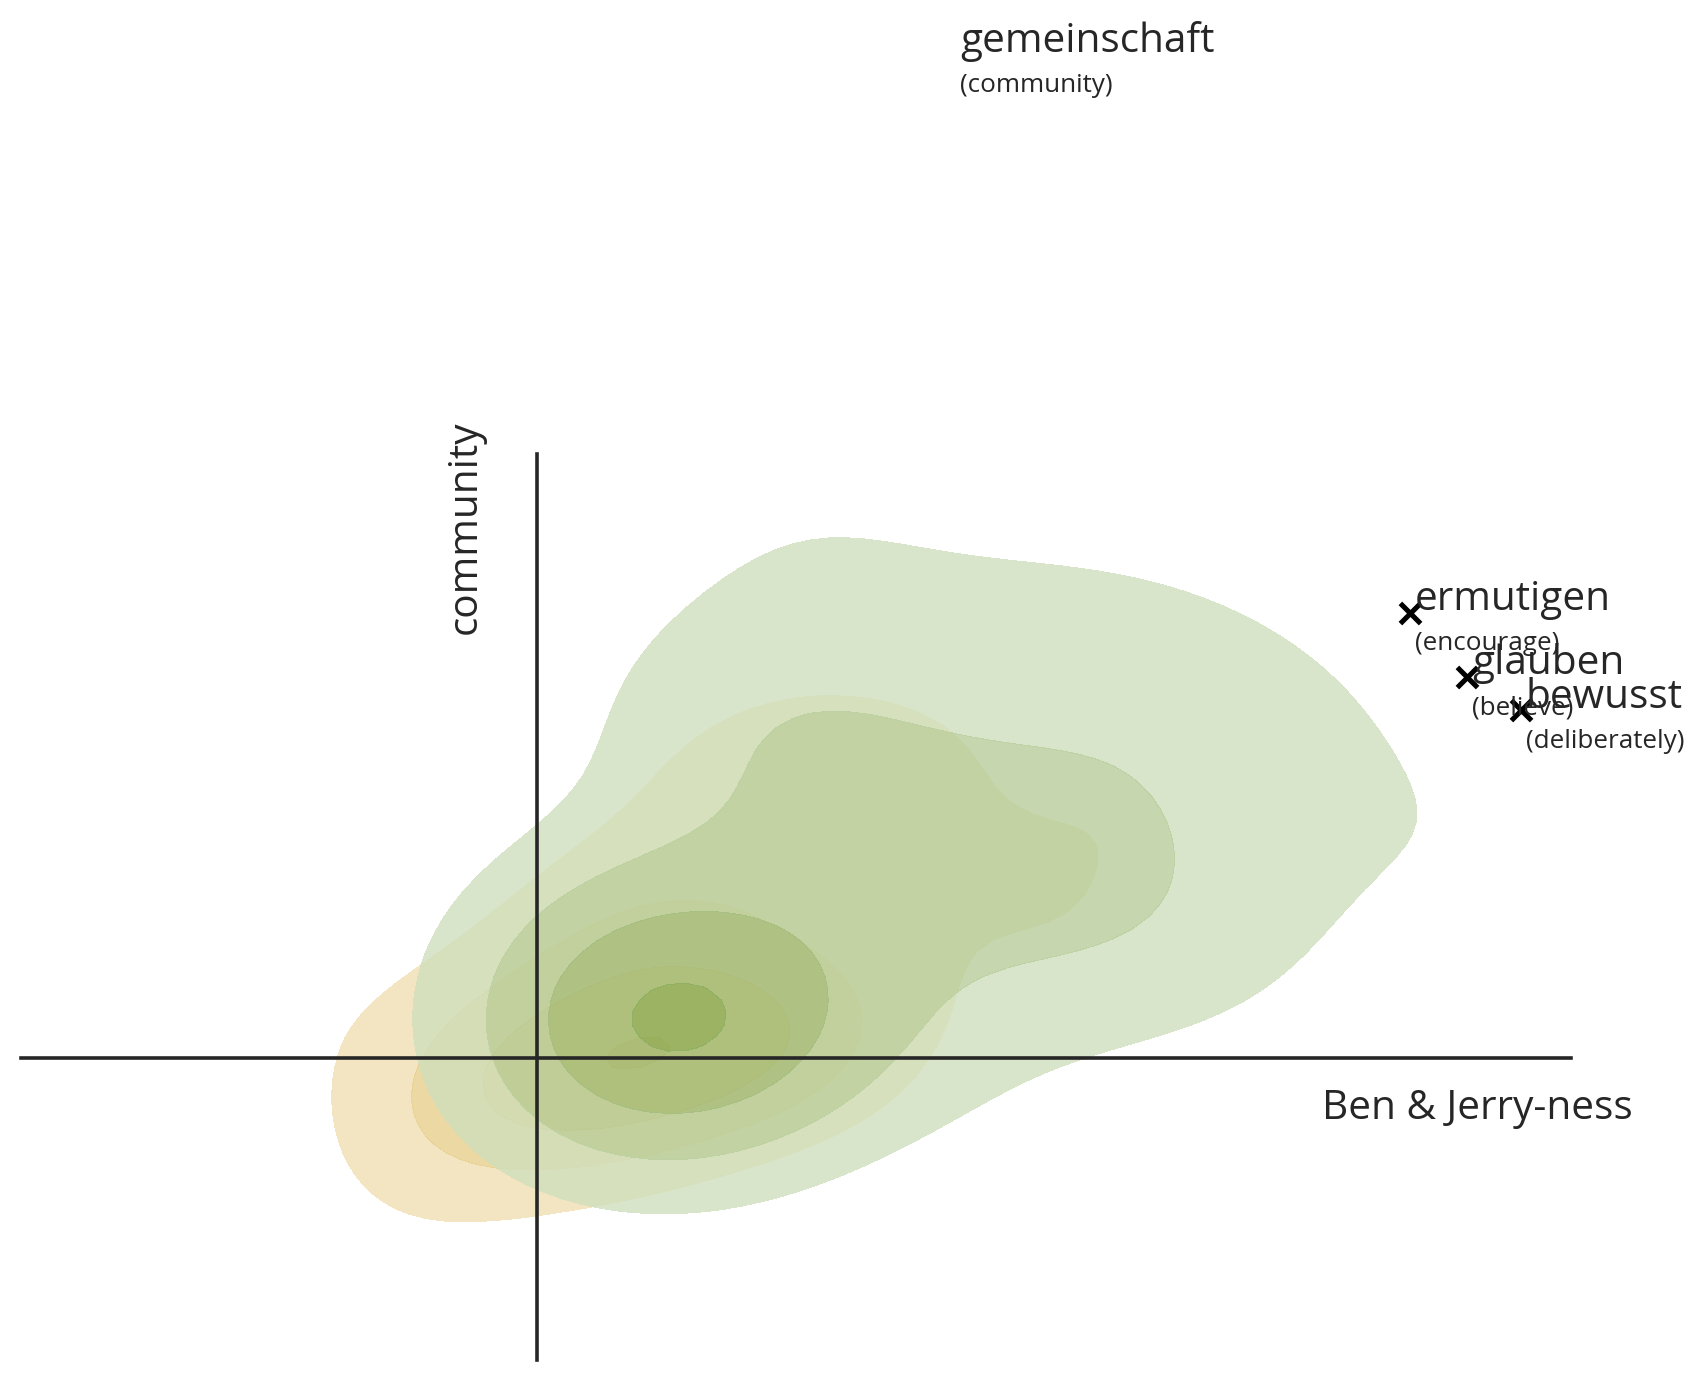

In [93]:
plot_heatmap_recommended_words(fb[fb['social justice + migration'] >=0.3], 'migration', mode = 'default', x_dim = 'benandjerryness', y_dim = 'community')

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


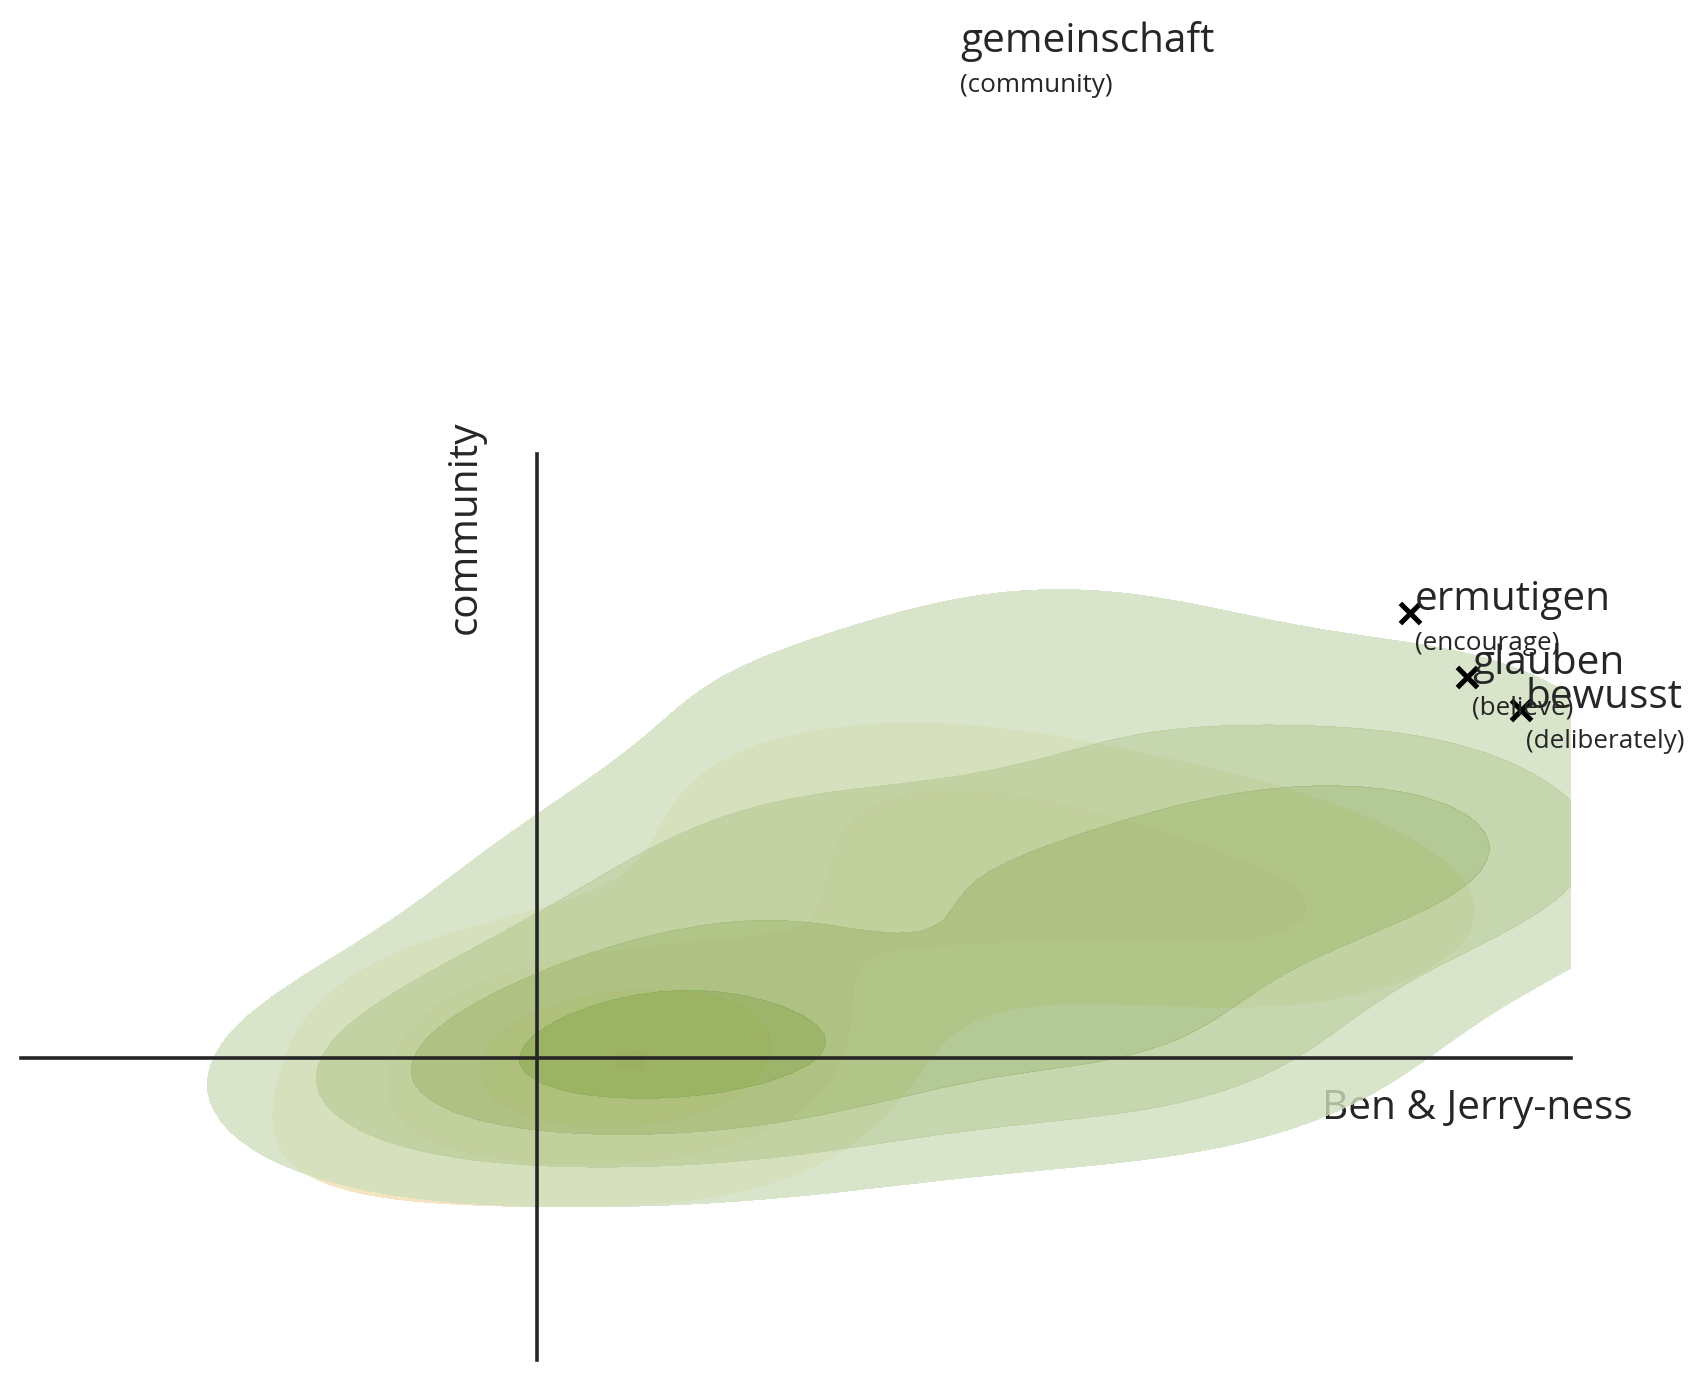

In [94]:
plot_heatmap_recommended_words(fb[fb['social justice + dairy free vegan'] >=0.3], 'vegan', mode = 'default', x_dim = 'benandjerryness', y_dim = 'community')

In [62]:
nonzero_migration = migration[migration['success'] != 0]

In [63]:
nonzero_migration['quantile'] = pd.qcut(nonzero_migration['success'], 25, range(25))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
bot = set(itertools.chain.from_iterable(nonzero_migration.loc[nonzero_migration['quantile'] == 0, 'tokens'].values))
top = set(itertools.chain.from_iterable(nonzero_migration.loc[nonzero_migration['quantile'] == 24, 'tokens'].values))

bot = set([x for x in bot if x in emb.vocab])
top = set([x for x in top if x in emb.vocab])

bot_unique = bot-top
top_unique = top-bot

In [65]:
translator = Translator()
bot_english = [translator.translate(x, src = 'de').text for x in bot]
top_english = [translator.translate(x, src = 'de').text for x in top]

In [66]:
top_english

['r',
 'n',
 'a',
 'm',
 'd',
 'i',
 't',
 'ä',
 'k',
 'v',
 'p',
 's',
 'z',
 'ö',
 'j',
 'c',
 'G',
 'y',
 'ü',
 'b',
 'u',
 'f',
 'H',
 'x',
 'ß',
 'e',
 'l',
 'w',
 'O']

In [427]:
x_dim = 'benandjerryness'
y_dim = 'community'

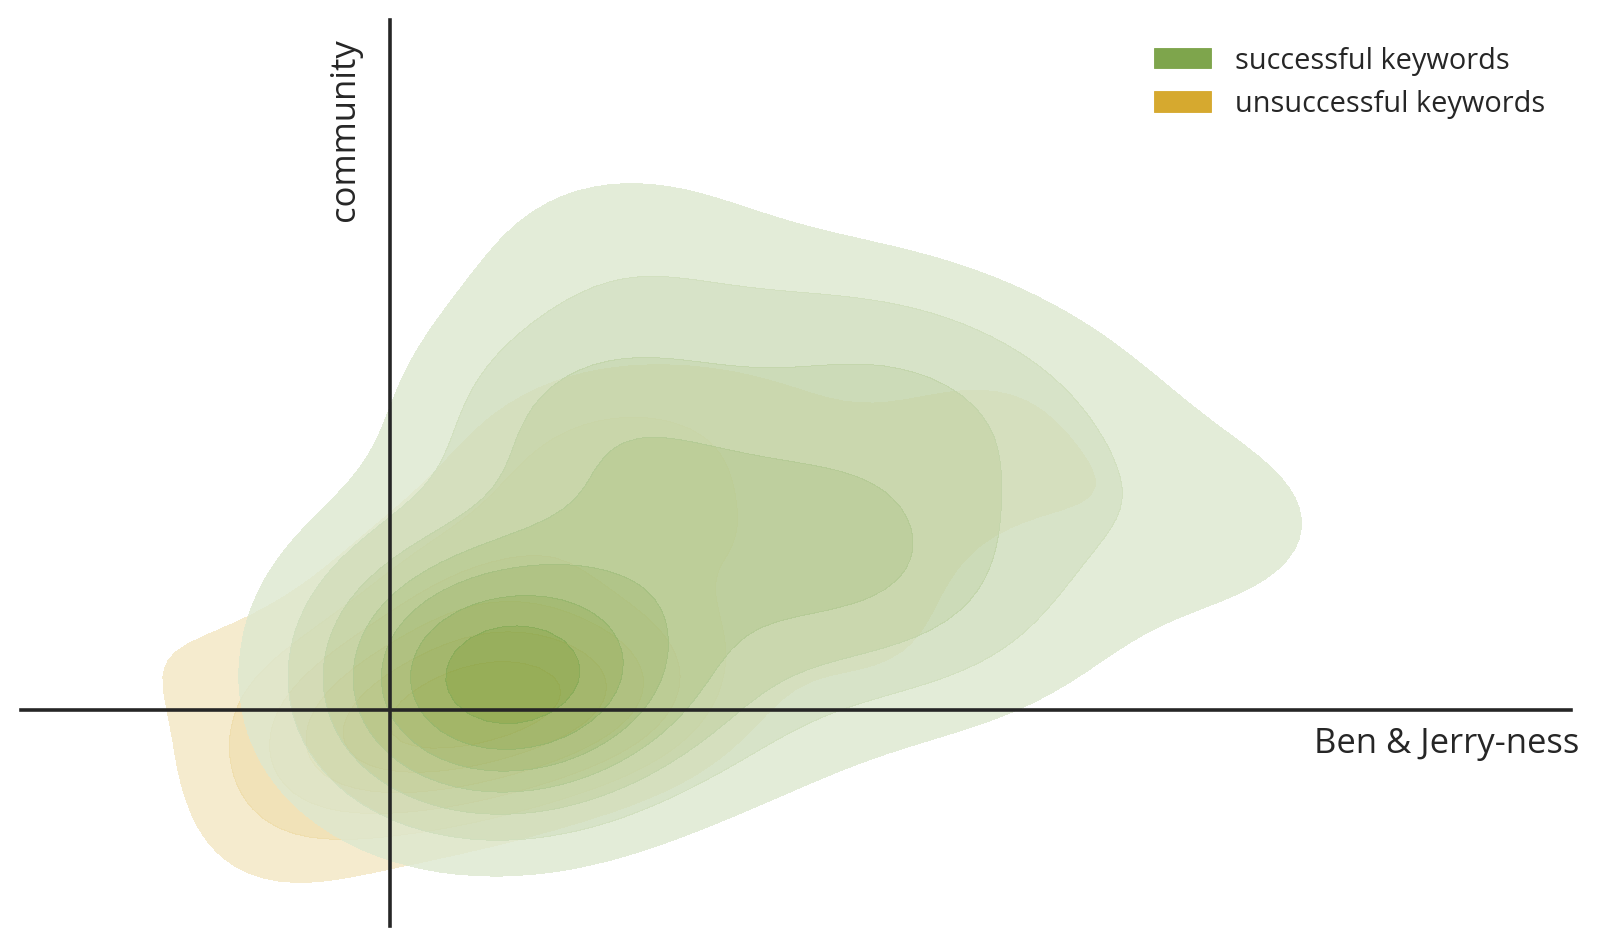

In [428]:
x1, y1 = get_keyword_dimension_scores(top_unique, dimensions, emb, y_dim, x_dim)
x2, y2 = get_keyword_dimension_scores(bot_unique, dimensions, emb, y_dim, x_dim)

c_1 = c_successful
c_2 = c_unsuccessful
# cmap = sns.cubehelix_palette(start=0.2, light=1, as_cmap=True)
cmap_y = sns.light_palette(c_1, as_cmap=True)
cmap_x = sns.light_palette(c_2, as_cmap=True)
# sns.kdeplot(x, y, cmap=cmap, shade=True)
fig, ax = plt.subplots(figsize=(2000/float(208), 1200/float(208)), dpi=208)
sns.kdeplot(np.array(x2), np.array(y2), shade=True, cmap=cmap_x, shade_lowest=False, ax=ax, n_levels=7, alpha=0.8, label='bottom keywords', legend=False)
sns.kdeplot(np.array(x1), np.array(y1), shade=True, cmap=cmap_y, shade_lowest=False, ax=ax, n_levels=7, alpha=0.8, label='top keywords', legend=False)
#ax.legend(loc="best")
#ax.legend(handles=ax.lines, labels=["A","B"])
#ax.legend(labels=["top keywords", "bottom keywords"])
red_patch = mpatches.Patch(color=c_1, label='successful keywords')
yellow_patch = mpatches.Patch(color=c_2, label='unsuccessful keywords')
plt.legend(handles=[red_patch, yellow_patch])

ax.axis([-0.25, 0.8, -0.25, 0.8])

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
centerx, centery = 0, 0
ax.spines['left'].set_position(('data', centerx))
ax.spines['bottom'].set_position(('data', centery))
# ax.spines['right'].set_position(('data', centerx - 1))
# ax.spines['top'].set_position(('data', centery - 1))
ax.axes.spines['top'].set_visible(False)
#ax.axes.spines['bottom'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
#ax.axes.spines['left'].set_visible(False)
ax.set_ylabel(y_dim, fontsize=12)
ax.set_xlabel('Ben & Jerry-ness', fontsize=12)
ax.xaxis.set_label_coords(0.92, 0.22)
ax.yaxis.set_label_coords(0.22, 0.88)
# plt.savefig('../figs/heatmap_fb.png', bbox_inches='tight', transparent=True)

In [429]:
y_dim_vector = dimensions.loc[dimensions['label'] == y_dim, 'dimension'].iloc[0]
if x_dim == 'benandjerryness':
    x_dim_vector = benandjerryness_wv
else:
    x_dim_vector = dimensions.loc[dimensions['label']==x_dim, 'dimension'].iloc[0]

top_1000_y_dim = emb.similar_by_vector(y_dim_vector, topn=1000)
print(top_1000_y_dim[:5])

for i in range(len(top_1000_y_dim)):
    word, y_dim_score = top_1000_y_dim[i]
    bj_score = cosine_similarity(x_dim_vector, emb[word])
    top_1000_y_dim[i] = (word, y_dim_score, bj_score)
print(top_1000_y_dim[:5])
print("")

top_1000_y_dim.sort(key=lambda x: x[1]+2*x[2], reverse=True)
# top_1000_innovative[100:200]

[('gemeinschaft', 1.0), ('gemeinschaften', 0.7303408980369568), ('zusammenhalt', 0.6006556749343872), ('gemeinsam', 0.5862842202186584), ('gemeinschaftlich', 0.5609830617904663)]
[('gemeinschaft', 1.0, 0.24528047291412342), ('gemeinschaften', 0.7303408980369568, 0.09569213053405531), ('zusammenhalt', 0.6006556749343872, 0.3186454230720685), ('gemeinsam', 0.5862842202186584, 0.40362139479790204), ('gemeinschaftlich', 0.5609830617904663, 0.12215486518856739)]



In [454]:
top_1000_y_dim

[('vertrauen', 0.3976806402206421, 0.5836710141929302),
 ('bewusst', 0.34851667284965515, 0.573957494638665),
 ('gemeinschaft', 1.0, 0.24528047291412342),
 ('glauben', 0.38184815645217896, 0.5427396184670868),
 ('ermutigen', 0.4457436800003052, 0.5096772302311444),
 ('aufrichtig', 0.39002352952957153, 0.5215807136437687),
 ('freude', 0.3719668686389923, 0.5244009928820718),
 ('fühlen', 0.35236895084381104, 0.525410617344606),
 ('gemeinsam', 0.5862842202186584, 0.40362139479790204),
 ('wahrhaftig', 0.3333510160446167, 0.5281593393587222),
 ('begegnen', 0.37570658326148987, 0.5011909996011714),
 ('gleichzeitig', 0.3605530560016632, 0.5051469728591795),
 ('vielmehr', 0.36928024888038635, 0.5004073357011136),
 ('bestärken', 0.3377231955528259, 0.513718942325655),
 ('überzeugung', 0.4388855993747711, 0.45738351737202243),
 ('offenheit', 0.4170902669429779, 0.46642768189008205),
 ('wahrnehmen', 0.34702226519584656, 0.5008489184806498),
 ('lebendig', 0.42519834637641907, 0.46054163367599177),

In [450]:
recommended_words = [x[0] for x in top_1000_y_dim[1:5]]

In [451]:
recommended_words_english = [translator.translate(x, src='de').text for x in recommended_words]

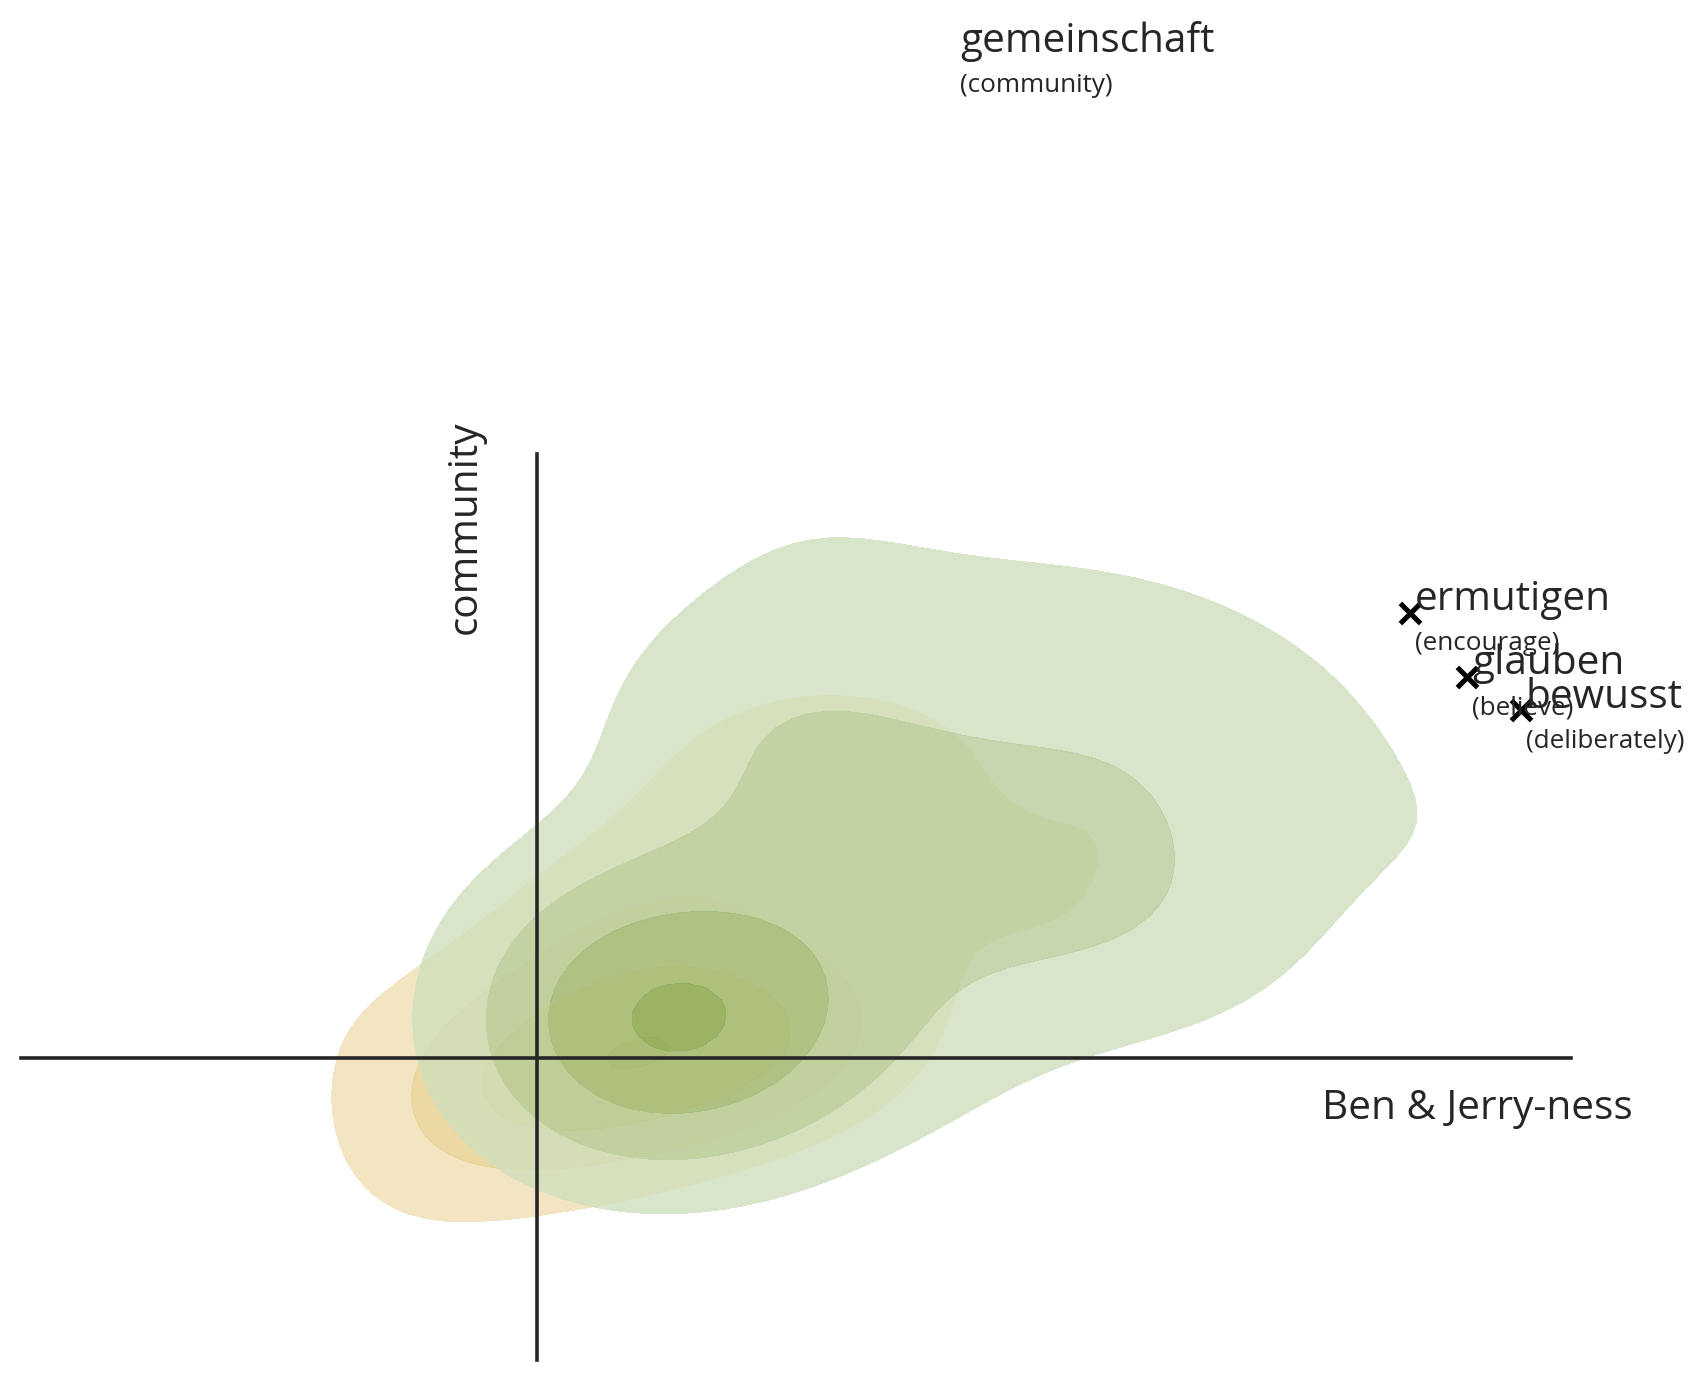

In [452]:
x1, y1 = get_keyword_dimension_scores(top_unique, dimensions, emb, y_dim, x_dim)
x2, y2 = get_keyword_dimension_scores(bot_unique, dimensions, emb, y_dim, x_dim)
x3, y3 = get_keyword_dimension_scores(recommended_words, dimensions, emb, y_dim, x_dim)

c_1 = c_successful
c_2 = c_unsuccessful
# cmap = sns.cubehelix_palette(start=0.2, light=1, as_cmap=True)
cmap_y = sns.light_palette(c_1, as_cmap=True)
cmap_x = sns.light_palette(c_2, as_cmap=True)
# sns.kdeplot(x, y, cmap=cmap, shade=True)
fig, ax = plt.subplots(figsize=(2000/float(208), 1200/float(208)), dpi=208)
sns.kdeplot(x2, y2, shade=True, cmap=cmap_x, shade_lowest=False, ax=ax, n_levels=4, alpha=0.8, label='bottom keywords', legend=False)
sns.kdeplot(x1, y1, shade=True, cmap=cmap_y, shade_lowest=False, ax=ax, n_levels=4, alpha=0.8, label='top keywords', legend=False)
for i, x, y in zip(range(len(recommended_words)), x3, y3):
    ax.text(x, y, recommended_words[i], label='successful keywords', fontsize=14)
    ax.text(x, y - 0.04, '(' + recommended_words_english[i] + ')', label='successful keywords', fontsize=9)
ax.scatter([x-0.003 for x in x3], [y-0.003 for y in y3], marker='x', color='black')
#ax.legend(loc="best")
#ax.legend(handles=ax.lines, labels=["A","B"])
#ax.legend(labels=["top keywords", "bottom keywords"])
#red_patch = mpatches.Patch(color=c_1, label='successful keywords')
#yellow_patch = mpatches.Patch(color=c_2, label='unsuccessful keywords')
#plt.legend(handles=[red_patch, yellow_patch])

ax.axis([-0.3, 0.6, -0.3, 0.6])

ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
centerx, centery = 0, 0
ax.spines['left'].set_position(('data', centerx))
ax.spines['bottom'].set_position(('data', centery))
# ax.spines['right'].set_position(('data', centerx - 1))
# ax.spines['top'].set_position(('data', centery - 1))
ax.axes.spines['top'].set_visible(False)
#ax.axes.spines['bottom'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
#ax.axes.spines['left'].set_visible(False)
ax.set_ylabel(y_dim, fontsize=14)
ax.set_xlabel('Ben & Jerry-ness', fontsize=14)
ax.xaxis.set_label_coords(0.94, 0.3)
ax.yaxis.set_label_coords(0.3, 0.92)

In [453]:
[x-0.003 for x in x3], [y-0.003 for y in y3]

([0.570957494638665,
  0.2422804729141234,
  0.5397396184670868,
  0.5066772302311444],
 [0.3455166689963908,
  0.997000023826068,
  0.3788481826821671,
  0.4427436331100084])

# Word Clouds

In [456]:
fb['tokens']

0       [geburtstag, bekommen, geschenke, büro, uni, w...
1       [geburtstag, bekommen, geschenke, büro, uni, w...
2       [geburtstag, bekommen, geschenke, büro, uni, w...
3       [doppeln, freuen, feiern, nämlich, geburtstag,...
4       [geburtstag, bekommen, geschenke, büro, uni, w...
5       [geburtstag, bekommen, geschenke, büro, uni, w...
6       [voll, ✌🏼❤, 🍦, beid, gewinnerinnen, riesen, ge...
7                   [millionen, jed, weltgeflüchtetentag]
8       [traum, wahren, veganes, ben, jerry, s, geben,...
9                                     [probieren, löffel]
10                             [cool, beifahrer, sommers]
11      [ben, jerry, s, birthday, tour, juli, bern, ge...
12      [ben, jerry, s, birthday, tour, juli, zürich, ...
13      [ben, jerry, s, birthday, tour, juli, linz, ge...
14      [ben, jerry, s, birthday, tour, juli, wien, ge...
15      [ben, jerry, s, birthday, tour, juli, frankfur...
16      [ben, jerry, s, birthday, tour, juli, münchen,...
17      [ben, 